# <span style='color:SteelBlue'>P4 - Anticipez les besoins en consommation de bâtiments</span>

![Logo Seattle](https://login.seattle.gov/static/media/logo.62be6fde.jpg)

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

**Etape 1 : Description des données**
- _Origine des données_
- _Respect du RGPD_
- _Aperçu tableau_
- _Type de données_
- _Nom et description des features_
- _Résumé des données_
  - _Quantitatives_
  - _Qualitatives_
- _Valeurs manquantes_
- _Doublons_<br>

**Etape 2 : Nettoyage des données**
- _1/ Filtrage par taux de remplissage_
- _2/ Suppression features redondantes_
- _3/ Suppression features inutiles_
- _4/ Conservation des bâtiments non destinés à l'habitation_
- _5/ Conservation des bâtiments non recencés en outlier_
- _6/ Filtrage des bâtiments par taux de remplissage >50%_
- _7/ Remplacement valeur abérrantes par Nan_
- _8/ Imputation feature qualitative_
- _9/ Imputation features quantitatives_
- _10/ Bilan dataset nettoyé_<br>

**Etape 3 : Analyse exploratoire**
- _1/ Analyses univariées_
- _2/ Analyses bivariées_
- _3/ Analyses multivariées_

**Etape 4 : Exportation du dataset nettoyé**

Conclusion

# <span style='background:blue'>Introduction</span>

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation puisqu'ils génèrent 33% des émissions de gaz à effet de serre de la ville. Cette dernière a ainsi adopté un plan d'action climatique en 2013. Un relevé annuel des batiments de la ville permet de suivre l'évolution de leurs performances énergétiques. 

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions et les consommations totale d'énergie des batiments. 

___

**Mission**

**Prédire les émissions de CO2 et la consommation totale d’énergie** non-mesurées de bâtiments non destinés à l’habitation de la ville de Seattle à partir d’un dataset de la ville. Pour cela je devrais :
1.  Réaliser une courte analyse exploratoire.
2.  Tester différents modèles de prédiction pour prédire la consommation totale d'énergie.
3.  Tester différents modèles de prédiction pour prédire les émissions de CO2.

Ce notebook présente la 1ère partie. Nous allons donc réaliser **une courte analyse exploratoire** après avoir nettoyé les données si nécessaire. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles (feature engineering).

___

**Source des datasets**<br>
[Seattle Open Data](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)<br>

1 fichier CSV :
- 2016_Building_Energy_Benchmarking.csv
___


# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [2]:
# Librairies
import datetime
import os.path
import sys
import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import time
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy
from scipy import stats
from scipy.stats import shapiro
from IPython.display import display

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('Missingno     : ' + msno.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)

# Afficher heure lancement
maintenant = datetime.datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
Matplotlib    : 3.8.0
Missingno     : 0.5.2
NumPy         : 1.26.0
Pandas        : 2.1.1
Scipy         : 1.11.3
Seaborn       : 0.13.0

Code lancé le : 2023-11-14T11:03:30.648395


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [3]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 300)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

In [4]:
# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [5]:
#                      NOMBRE DE LIGNES ET DE COLONNES
# ****************************************************************************

def print_nbr_ligne_col(df):
    """
    Procédure qui affiche le nombre de lignes et de colonnes du data frame
    
    :param: df : data frame à analyser (df)
    """
    
    # Affichage dimension du dataframe (linge et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [6]:
#                              COMPTEUR TYPE DES VARIABLES
# ****************************************************************************

def compteur_type_variable(df, listing, tableau_repartition, graph):
    """
    Procédure qui affiche :
        - un listing des variables et leur type
        - un tableau de la répartition des variables par type
        - un graphique de répartition des variables par type avec un diagrmme   circulaire
    
    :param: df : data frame à analyser (df)
    :param: listing : True pour afficher le listing des variables (bool)
    :param: tableau_repartition : True pour afficher le tableau de répartition des variables (bool)
    :param: graph : True pour afficher le graph de répartition des variables (bool)
    """
    
    # Liste des variables + type
    if listing :
        print("-" * 100)
        print("Type de variable pour chacune des variables\n")
        display(df.info())
    
    # Type de variable et répartition
    if tableau_repartition :
        print("Répartition des types de variable")
        
        # Calcul du nombre de type de variable et leur répartition
        type_nbr = df.dtypes.value_counts()
        type_nb_tot = type_nbr.sum()
        type_nb_pourcent = round((100 * type_nbr / type_nb_tot), 2)
        
        # Concatenation en 1 data frame
        table = pd.concat([type_nbr, type_nb_pourcent], axis=1)
        table.columns = ['Nombre', 'en %']
        
        # Affichage résultats
        display(table[table['Nombre'] != 0]
                .sort_values('en %', ascending = False,)
                .style.background_gradient('YlGn'))
        
    # Diagramme circulaire 
    if graph :
        df.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Répartition des types de données')
        plt.ylabel('')
        plt.show()

In [7]:
#                             VALEURS MANQUANTES
# ****************************************************************************

def valeur_manquante_text_graph(df, tableau, matrice):
    """
    Procédure qui affiche le nombre de valeurs manquantes, puis :
        - un tableau sur la répartition des valeur manquantes par variable
        - une matrice de répartition des valeurs manquantes par variable
        
    :param: df : data frame à analyser (df)
    :param: tableau : True pour afficher le texte (bool)
    :param: matrice : True pour afficher matrice de répartition (bool)
    """
    
    # Nombre de valeurs manquantes  / nombre de valeur / % de manquantes 
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.prod(df.shape)
    nb_nan_pourcent = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    
    # Affichage résultat
    print('Valeurs manquantes (Nan) : {0} / {1} données ({2} %)'.format(nb_nan_tot, nb_donnees_tot, nb_nan_pourcent))
    
    # Calcul du nombre de valeur manquante et leur pourcentage
    nan_nbr = df.isnull().sum()
    nan_pourcent = nan_nbr / len(df) * 100
    
    # Concatenation en 1 data frame
    table = pd.concat([nan_nbr, nan_pourcent.round(2)], axis=1)
    table.columns = ['Nombres de valeurs manquantes', 
                    '% de valeurs manquantes']
    
    # Nombre colonnes concernées
    nb_col = df.columns.size
    nb_col_nan = table[table['Nombres de valeurs manquantes'] != 0]['Nombres de valeurs manquantes'].size
    
    # tableau sur la répartition des valeur manquantes par variable
    if tableau:
        
        # Affichage texte et tableau
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending = True)
                .style.background_gradient('YlGn'))
    
    # matrice de répartition des valeurs manquantes par variable
    if matrice:
        
        # Séparateur graphique
        print('{0} / {1} colonne(s) sont concernés'.format(nb_col_nan, nb_col))
        print("-" * 100)        
        print("Heatmap de visualisation des valeurs manquantes")
        
        # Matrix de Missingno
        msno.matrix(df)

In [8]:
#                          DETECTION DES DOUBLONS
# ****************************************************************************

def detect_doublon(df, var, keep_value):
    """
    Fonction qui détecte les doublons d'un data frame sur une variable (colonne) et qui retourne le nombre de doublon.
    
    :param: df : data frame à analyser (df)
    :param: var : nom de la variable (str)
    :param: keep_value : nom de méthode pour 'keep' (str)
    
    :return: nb_doublons : nombre de doublons (float)
    :return: doublons : doublons trouvés (df)
    """
    
    # Méthode 'first'
    if keep_value == 'first':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "first" sur "{0}" : {1}'.format(var, nb_doublons))
        
    # Méthode 'last'
    elif keep_value == 'last':
        
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec "last" sur "{0}" : {1}'.format(var, nb_doublons))
    
    # Méthode False
    else:
    
        # Détection des doublons sur la variable
        doublons = df[df.duplicated([var], keep=keep_value)]
        
        # Compteur des doublons
        nb_doublons = doublons.shape[0]
        
        # Affichage résultat
        print('Doublons détecté(s) avec False sur "{0}" : {1}\n'.format(var, nb_doublons))
    
    # Output
    return nb_doublons, doublons

In [9]:
#                          FILTRE NAN PAR SEUIL
# ****************************************************************************

def filtre_nan_par_seuil(df: pd.DataFrame, taux, fig_detector):
    """
    Fonction qui filtre les col du df en fonction du nombre de NaN présent dedans, selon un seuil minimum. Il peut afficher le taux de remplissage par col. 
    
    :param: df : data frame à analyser (df)
    :param: taux : seuil minimum de NaN (int)
    :param: fig_detector : détecteur d'affichage de plot (bool)
    
    :return: df_Nan_par_ligne : data frame des NaN par col (df)
    :return: df_to_supp : data frame des col à supprimer (df)
    """
    
    # comptage nombre de lignes
    num_rows = len(df.index)
    
    # Compteur de NaN par colonne (classés dans ordre croissant)
    df_Nan_par_ligne = pd.DataFrame({
        col : {'nombre': df[col].isna().sum(), 
               'pourcent': round(df[col].isna().sum() / num_rows * 100, 1)} 
        for col in df.columns}).transpose().sort_values(by=['nombre'])
    
    # Création df des col à supprimer
    df_to_supp = df_Nan_par_ligne[df_Nan_par_ligne["pourcent"] > taux]
    nbr_col_suppr = len(df_to_supp.index)
    
    # Print nombre col au dessus du taux
    print("Il y a {0} colonnes > {1} % de NaN".format(nbr_col_suppr, taux))
    
    # Plot des NaN par col
    if fig_detector:
        fig = px.bar(df_Nan_par_ligne, color='pourcent', y='pourcent',
            labels={'index':'Nom colonne',
                    'pourcent':'% de NaN',
                    'nombre':'Nombre de NaN'},
            hover_data=['nombre'],
            title='Taux de NaN par colonne',
            width=1500,
            height=800)
        fig.show()
    
    # Outputs
    return df_Nan_par_ligne, df_to_supp

In [10]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe

    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    print("Voici l'aspect de '{0}' après nettoyage {1}".format( str_df, str_explication)) 
    
    display(df.head(nb_head))
    
    print_nbr_ligne_col(df)

In [11]:
#                          REMPLACE NEGATIVES PAR NAN
# ****************************************************************************

def remplace_negatives_par_nan(df, col):
    """
    Fonction qui remplace les valeurs négatives par NaN dans un DataFrame pandas.
    
    :param df: Le DataFrame à traiter (df)    
    :return: nouveau DataFrame avec valeurs négatives remplacées par NaN (df)
    """
    
    # Copiez le DataFrame pour éviter de modifier l'original
    df_copy = df.copy()
    
    # Remplacez les valeurs négatives par NaN
    df_copy[df_copy[col] < 0] = np.nan
    
    # outputs
    return df_copy

In [12]:
#                          AFFICHE NAN HORS ENERGYSCORE
# ****************************************************************************

def affiche_nan_hors_energyscore(df: pd.DataFrame, feature_nan_list):
    """
    Procédure qui affiche les Nan sans prendre en compte la feature "ENERGYSTARScore"
    
    :param: df : data frame à analyser (df)
    :param: feature_nan_list : nom des features à analyser (list)
    
    :return: lignes_avec_nan : data frame avec uniquement les Nan (df)
    """
    
    # Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
    masque_nan = df.drop(columns="ENERGYSTARScore").isna().any(axis=1)
    
    # Appliquez le masque pour filtrer les lignes
    lignes_avec_nan = df[masque_nan]
    
    # Affichez les lignes avec des NaN (à l'exception de la colonne ENERGYSTARScore)
    print(" Voici {} les lignes de bâtiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :".format(len(lignes_avec_nan)))
    display(lignes_avec_nan[feature_nan_list])
    
    # Outputs
    return lignes_avec_nan

In [13]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:

        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col,sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=True, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=True, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()

In [14]:
# #                            CLASSE MODALE
# # ****************************************************************************

def classe_modale(serie, arrondi_nb):
    """
    Fonction qui détermine la classe modale d'une série et le nombre d'élements à l'intérieur.
    
    :param df: series à analyser (df)
    :param nb_classe: nombre de classe à créer (int)
    :param arrondi_nb: nombre de chiffre arrondi après la virgule (int)
    
    :return classe_modale: classe modale (tuple)
    :return classe_modale: nombre d'élement dans la classe modale (int)
    """
    
    # Utilisez la fonction np.histogram() pour regrouper les données en classes
    hist, bin_edges = np.histogram(serie, bins='auto')
    
    # Trouvez l'indice du bin (classe) ayant la fréquence maximale
    indice_mode = np.argmax(hist)
    
    # Trouver la hauteur du bin (classe) ayant la fréquence maximale
    nb_elements = max(hist)
    
    # Classe modale (arrondi à quelques chiffres après la virgule)
    classe_modale = (round(bin_edges[indice_mode], arrondi_nb), round(bin_edges[indice_mode + 1], arrondi_nb))
    
    # Outputs
    return classe_modale, nb_elements

In [15]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats (ajouter 'classe modale' si besoin)
    stat_list = ['Q1', 'moyenne', 'médiane', 'Q3', 'ecart-type', 'CV', 'skewness', 'kurtosis']  
    
    # Stats descriptives (arrondis après la virgule)
    # Calcul des quartiles (Q1 et Q3)
    q1 = df[col].quantile(0.25).round(1)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    q3 = df[col].quantile(0.75).round(1)
    # mode, nb_element = classe_modale(df[col], arrondi_nb=1)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    # classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste (ajouter 'classe modale' si besoin)
    list_stat = [q1, mean, median, q3, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

In [16]:
# #                            DETERMINE MEILLEUR VOISIN KNN
# # ****************************************************************************

def determine_meilleur_voisin_knn(df, k_min, k_max):
    """
    Fonction pour déterminer le meilleur nombre de voisins (k) pour l'imputation KNN.
    
    :param df: DataFrame contenant les données à imputer (DataFrame)
    :param k_min: Valeur minimale de k pour la recherche (int)
    :param k_max: Valeur maximale de k pour la recherche (int)
    
    :return errors: Liste des erreurs (MSE) pour chaque valeur de k (list)
    """
    
    # Liste pour stocker les erreurs
    errors = []
    
    # Plage de valeurs pour le nombre de voisins
    k_range = range(k_min, k_max)
    
    # POUR chaque chiffre de k_range
    for k in k_range:
        
        # Créez objet d'imputation KNN (k voisins, valeurs manquantes=NaN)
        imputerKNN = KNNImputer(n_neighbors=k, missing_values=np.nan)
        
        # Entraînez et applique le modèle d'imputation KNN 
        df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df), columns=df.columns)
        
        # Calcul de l'erreur en utilisant une métrique de performance
        mse = np.mean((df_datas_imputed - df) ** 2)
        
        # Sauvegarde mse dans la liste "errors"
        errors.append(mse)
    
    # Tracez les erreurs en fonction du nombre de voisins (k)
    plt.plot(k_range, errors, 'o-')
    plt.xlabel('Nombre de voisins (k)')
    plt.ylabel('Erreur (MSE)')
    plt.title('Recherche du meilleur nombre de voisins pour imputation KNN')
    plt.show()
    
    # Trouvez le meilleur nombre de voisins (k) avec la plus faible erreur
    best_k = k_range[errors.index(min(errors))]
    print(f"Le meilleur nombre de voisins est : {best_k}")
    
    return errors

In [17]:
# #                            DETECTEUR CORRELATION SUP TARGET
# # ****************************************************************************

def detecteur_correlation_sup_target(corr_matrix, target_feature=None, seuil=0.5):
    """
    Cette fonction détecte et affiche les corrélations supérieures à un seuil donné dans une matrice de corrélation
    impliquant une feature cible donnée.
    
    :param corr_matrix: La matrice de corrélation (df)
    :param target_feature: La feature cible pour laquelle les corrélations sont calculées (str) (optionnelle)
    :param seuil: Le seuil de corrélation à partir duquel une paire de variables est considérée comme corrélée (par défaut 0.5) (int)
    """
    
    # Créer un ensemble pour stocker les features déjà traitées
    deja_traites = set()
    
    # Créer une liste pour stocker les corrélations supérieures au seuil
    corr_sup_seuil = []
    
    # SI une feature cible est spécifiée
    if target_feature:
        
        # Parcourir la matrice de corrélation en fonction de la feature cible
        for feature1 in corr_matrix.columns:
            if feature1 != target_feature and feature1 not in deja_traites:
                
                # SI la corrélation est supérieure au seuil
                if corr_matrix.loc[target_feature, feature1] > seuil:
                    
                    # Ajout la paire de features et la corrélation à la liste
                    corr_sup_seuil.append([target_feature, feature1, corr_matrix.loc[target_feature, feature1]])
                
                # Ajout la paire à l'ensemble des paires déjà traitées
                deja_traites.add(feature1)
    else:
        # Parcourir la matrice de corrélation pour toutes les paires de features
        for feature1 in corr_matrix.columns:
            for feature2 in corr_matrix.columns:
                
                # SI features sont différentes ET paire n'a pas déjà été traitée
                if feature1 != feature2 and feature2 not in deja_traites:
                    
                    # SI la corrélation est supérieure au seuil
                    if corr_matrix.loc[feature1, feature2] > seuil:
                        
                        # Ajout la paire de features et la corrél. à la liste
                        corr_sup_seuil.append([feature1, feature2, corr_matrix.loc[feature1, feature2]])
                    
                    # Ajout la paire à l'ensemble des paires déjà traitées
                    deja_traites.add(feature1)
    
    # Créez un DataFrame à partir de la liste des corrélations
    corr_df = pd.DataFrame(corr_sup_seuil, columns=['Feature cible', 'Feature associée', 'Corrélation'])
    
    # Afficher les corrélations supérieures au seuil
    display(corr_df)

In [18]:
# #                            SUPPRIMER OUTLIERS IQR
# # ****************************************************************************

def supprimer_outliers_iqr(df, feature, seuil=1.5):
    """
    Fonction qui supprime les outliers d'un DataFrame en utilisant la méthode IQR (Interquartile Range): toutes les valeurs situées en dehors de la plage [Q1 - seuil * IQR, Q3 + seuil * IQR] sont considérées comme des outliers et sont supprimées du DataFrame. Par défaut, le seuil est de 1,5.
    
    :param df: Le DataFrame à nettoyer (pd.DataFrame).
    :param seuil: Le facteur d'échelle pour déterminer la limite IQR (par défaut 1.5) (float).
    
    :return: Le DataFrame nettoyé sans les outliers (pd.DataFrame).
    """
    
    # Calculer les quartiles
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    # Calculer l'écart interquartile (IQR)
    IQR = Q3 - Q1
    
    # Définir la plage IQR pour chaque colonne
    borne_inferieure = Q1 - seuil * IQR
    borne_superieure = Q3 + seuil * IQR
    
    # Identifiez les lignes avec des outliers
    lignes_outliers = df.loc[(df[feature] < borne_inferieure) | (df[feature] > borne_superieure)]
    
    # Supprimez les lignes avec des outliers
    df_sans_outliers = df.drop(index=lignes_outliers.index)

    # Réinitialiser l'index
    df_sans_outliers = df_sans_outliers.reset_index(drop=True)
    
    # Outputs
    return df_sans_outliers

In [19]:
# #                           EBOULIS VALEURS PROPRES
# # ****************************************************************************

def eboulis_valeurs_propres(acp, features):
    """
    Fonction qui calcule et affiche le diagramme d'éboulis des valeurs propres
    de l'ACP pour aider à déterminer le nombre optimal de composantes principales à conserver. Elle affiche également des informations sur le seuil de Kaiser et les composantes principales retenues.
    
    :param acp: objet ACP préalablement entraîné (sklearn.decomposition.PCA)
    :param features: noms des caractéristiques (variables) originales (list)
    
    :return composante_sup_kaiser_list: numéros de composantes principales à retenir (list)
    :return x_list: index de composantes principales à retenir (list)
    """
    
    # Obtenir les valeurs propre (% inertie totale) et la somme cumulée des inerties
    eigenvalues = (acp.explained_variance_ratio_ * 100).round(2)
    eigenvalues_cum = eigenvalues.cumsum().round()
    
    print("L'ACP a trouvé {0} composantes qui déterminent {1} % du dataframe.".format(len(eigenvalues), eigenvalues_cum[-1]))
    
    # Identifier le seuil de Kaiser et les valeurs propres qui lui sont supérieures
    seuil_kaiser = round(100 / len(eigenvalues), 2)
    composante_sup_kaiser_list = np.where(eigenvalues > seuil_kaiser)[0] + 1
    
    print("\nSoit un seuil de Kaiser = {0}, les composantes principales à conserver sont les composantes {1} à {2}.".format(seuil_kaiser, composante_sup_kaiser_list[0], composante_sup_kaiser_list[-1]))
    
    # Filtrage des valeurs propres retenues (> seuil de Kaiser)
    eigenvalues_retenus = eigenvalues[0:composante_sup_kaiser_list[-1]]
    eigenvalues_cum_retenus = eigenvalues_cum[0:composante_sup_kaiser_list[-1]]
    features_retenus = features[0:composante_sup_kaiser_list[-1]]
    
    # Création axe X des éboulis
    x_list = range(1, composante_sup_kaiser_list[-1] + 1)
    list(x_list)
    
    # Création du diagramme (barplot + lineplot)
    plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(x_list, eigenvalues_retenus, label='Valeur propre individuelle')
    plt.plot(x_list, eigenvalues_cum_retenus, c="red", marker='o', label='Valeur propre cumulée')
    
    # Ajout titre du graphique et des axes, les étiquettes de valeur, la légende
    plt.title("Éboulis des Valeurs Propres", fontdict=font_title)
    plt.xlabel("Composante principale", fontdict=font_axe)
    plt.ylabel("Pourcentage d'inertie (%)", fontdict=font_axe)
    for x, y in zip(x_list, eigenvalues_retenus):
        plt.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(0, -15), ha='center', color="white", fontsize=10, fontweight="bold")
    plt.xticks(x_list)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Outputs
    return composante_sup_kaiser_list, x_list

In [20]:
# #                           PLAN FACTORIEL
# # ****************************************************************************

def plan_factoriel( X_projected,
                    x_y,
                    pca=None,
                    labels = None,
                    clusters=None,
                    alpha=1,
                    figsize=[10,8],
                    marker="." ):
    """
    Procédure qui affiche la projection des individus sur un plan principal d'une Analyse en Composantes Principales (ACP).
    
    :param X_projected: Matrice des points projetés (np.array, pd.DataFrame, list of list).
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    
    Paramètres optionnels :
    -----------------------
    :pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA), permet d'afficher la variance de chaque composante, valeur par défaut = None.
    :labels: Liste ou tuple des labels des individus à projeter, valeur par défaut = None.
    :clusters: Liste ou tuple indiquant à quel cluster appartient chaque individu, valeur par défaut = None.
    :alpha: Valeur de transparence en [0,1] (0=100% transparent, 1=0% transparent), valeur par défaut = 1.
    :figsize: Couple width, height qui définit la taille de la figure en inches, valeur par défaut = [10, 8].
    :marker: Type de marqueur utilisé pour représenter les individus (par exemple, ".", "x"), valeur par défaut = ".".
    """
    
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)
    
    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e
    
    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")
    
    # on définit x et y
    x, y = x_y
    
    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
    
    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)
    
    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100 * pca.explained_variance_ratio_[x], 1)) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y], 1)) + " %"
    else :
        v1 = v2 = ''
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x + 1} ({v1})', fontdict=font_axe, fontsize=20)
    ax.set_ylabel(f'F{y + 1} ({v2})', fontdict=font_axe, fontsize=20)
    
    # Taille écriture des chiffres des axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() * 1.1
    y_max = np.abs(X_[:, y]).max() * 1.1
    
    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)
    
    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x, y]]):
            plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center',va='center')
    
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontdict=font_title, fontsize=24)
    plt.legend(fontsize=16)
    plt.show()

In [21]:
# #                           CERCLE CORRELATION
# # ****************************************************************************

def cercle_correlation(pca, x_y, features) :
    """
    Procédure qui affiche un cercle des corrélations entre les composantes principales d'une Analyse en Composantes Principales (ACP).
    
    :param pca: Objet ACP préalablement ajusté (sklearn.decomposition.PCA)
    :param x_y: index du couple de dimensions à afficher (list ou tuple)
    :param features: Noms des caractéristiques (variables) à représenter (list ou tuple).
    """
    
    # Extrait x et y
    x, y=x_y
    
    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))
    
    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):
        
        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )
        
        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    
    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100 * pca.explained_variance_ratio_[x], 1)), fontdict=font_axe)
    plt.ylabel('F{} ({}%)'.format(y+1, round(100 * pca.explained_variance_ratio_[y], 1)), fontdict=font_axe)
    
    # Le Titre du graphique
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontdict=font_title)
    
    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an)) 
    
    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [22]:
# #                           REGRESSION LINEAIRE EMISSION ENERGIE
# # ****************************************************************************

def regression_lineaire_emission_energie(df, feat1, feat2, var1, var2, outliers_statut="sans", ):
    """
    Procédure qui effectue une régression linéaire entre deux variables et affiche un scatter plot avec une ligne de régression.

    :param df: Le DataFrame contenant les données (pd.DataFrame).
    :param feat1: Le nom de la première col à utiliser pour la régression (str).
    :param feat2: Le nom de la deuxième col à utiliser pour la régression (str).
    :param var1: Le nom de la première var à afficher dans l'équation (str).
    :param var2: Le nom de la deuxième var à afficher dans l'équation (str).
    :param outliers_statut: Le statut des outliers dans la régression ("avec" ou "sans", par défaut "sans") (str).
    """

    # Calcul de la régression linéaire
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[feat1], df[feat2])
    
    # Textes de l'équation, la corrélation et la p_value
    equation_text = f"{var1} = {slope:.1f} * {var2} + {intercept:.1f}"
    correlation_text = f"Corrélation Pearson (r) = {r_value:.2f}"
    p_value_text = f"p_value = {p_value:.2f}"
    text_pour_graph = equation_text + "\n" + correlation_text + "\n" + p_value_text
    
    # Créez un scatter plot avec une ligne de régression en rouge
    sns.regplot(x=df[feat1], y=df[feat2], scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})
    
    # Ajout texte, titre graphique, titre des axess X et Y
    plt.text(df[feat1].max() + 1, df[feat2].max() - 5, text_pour_graph, fontsize=12, color='red')
    plt.title(f"Régression linéaire {outliers_statut} les outliers", fontdict=font_title)
    plt.xlabel('Emissions gaz à effet de serre (tCO2e)', fontdict=font_axe)
    plt.ylabel('Energie (kBtu)', fontdict=font_axe)
    plt.show()

# <span style='background:grey'>Importation des données</span>

Importation du fichier CSV avec Pandas

In [23]:
# chemin et nom du fichier brut
path = "./data/source/"
csv_nomFichier = '2016_Building_Energy_Benchmarking.csv'

# Importation du fichier 
df_data_brut = pd.read_csv(path + csv_nomFichier, sep=",", encoding='utf-8')

# <span style='background:blue'>Etape 1 : Description des données</span>
___

1 fichier : **2016_Building_Energy_Benchmarking.csv**

## <span style='background:green'>Origine des données</span>

- **Créateur des données** : les agents de la ville de Seattle

- **Méthode de collecte des données** : non-précisé

- **Type du fichier** : fichier CSV

- **Taille du fichier** : 1_204 Mo

- **Date de dernière modification des données du fichier** : 15 mars 2018

## <span style='background:green'>Respect du RGPD</span>

Le RGPD ne s'applique que sur les données personnelles qui concernent des résidents de l'Union Européenne. Ce qui n'est pas le cas ici.

A noter qu'il existe la Washington State Privacy Act (WPA) qui protège les données personnelles des résidents de l'Etat de Washington. Cependant, les données de ce dataset ne concernent pas des personnes mais des bâtiments.

**Ces données ne sont donc pas soumises au RGPD et sont donc totalement exploitables**.

## <span style='background:green'>Aperçu tableau</span>

In [24]:
# Aperçu du dataframe
display(df_data_brut.head(5))
print_nbr_ligne_col(df_data_brut)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0              81.7   
1                      NaN             61.0              94.8   
2                      NaN             43.0              96.0   
3                      NaN             56.0             110.8   
4                      NaN             75.0             114.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   
2

3376 ligne(s) x 46 colonne(s)



## <span style='background:green'>Type de données</span>

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10

None

Répartition des types de variable


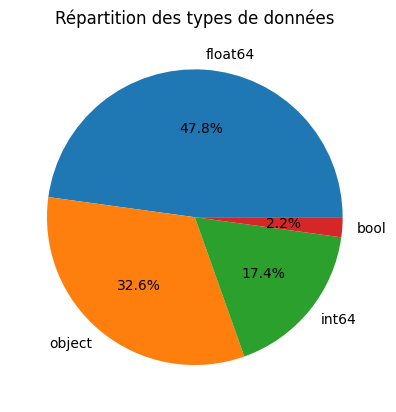

In [25]:
# Répartition du type de variable
compteur_type_variable(df_data_brut, True, True, True)

## <span style='background:green'>Nom et description des features</span>

Voici la définition de chaque variable :

1. **OSEBuildingID**: Identifiant unique attribué à chaque propriété couverte par l'ordonnance de benchmarking de Seattle à des fins de suivi et d'identification.

2. **DataYear**: Année civile (janvier-décembre) représentée par chaque enregistrement de données.

3. **BuildingType**: Classification des types de bâtiments de la ville de Seattle.

4. **PrimaryPropertyType**: L'utilisation principale d'une propriété (par exemple, bureau, magasin de détail). L'utilisation principale est définie comme une fonction qui représente plus de 50 % d'une propriété. Il s'agit du champ "Type de Propriété" calculé par l'EPA dans le Gestionnaire de Portefeuille.

5. **PropertyName**: Nom officiel ou courant de la propriété tel qu'indiqué dans le Gestionnaire de Portefeuille de l'EPA.

6. **Address**: Adresse de la propriété.

7. **City**: Ville de la propriété.

8. **State**: État de la propriété.

9.  **ZipCode**: Code postal de la propriété.

10. **TaxParcelIdentificationNumber**: Numéro d'identification de la parcelle du comté de King de la propriété.

11. **CouncilDistrictCode**: Code du district du conseil de la ville de Seattle de la propriété.

12. **Neighborhood**: Zone de voisinage de la propriété définie par le Département des Quartiers de la Ville de Seattle.

13. **Latitude**: Latitude de la propriété.

14. **Longitude**: Longitude de la propriété.

15. **YearBuilt**: Année de construction d'une propriété ou de sa rénovation complète.

16. **NumberofBuildings**: Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est signalée comme un campus, plusieurs bâtiments peuvent être inclus dans un seul rapport.

17. **NumberofFloors**: Nombre d'étages déclarés auprès de Agence de la protection environnemental des USA (EPA).

18. **PropertyGFATotal**: Surface brute totale (mesurées entre les murs extérieurs) du bâtiment et du parking.

19. **PropertyGFAParking**: Espace total en pieds carrés (ft²) de tous types de stationnement (entièrement fermé, partiellement fermé et ouvert).

20. **PropertyGFABuilding(s)**: Espace total en pieds carrés (ft²) entre les surfaces extérieures des murs d'enceinte d'un bâtiment. Cela inclut toutes les zones à l'intérieur du ou des bâtiments, telles que l'espace du locataire, les espaces communs, les cages d'escalier, les sous-sols, le stockage, etc.

21. **ListOfAllPropertyUseTypes**: Toutes les utilisations de propriété rapportées auprès de l'Agence de la protection environnemental des USA (EPA).

22. **LargestPropertyUseType**: La plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

23. **LargestPropertyUseTypeGFA**: La surface brute (GFA) de la plus grande utilisation de la propriété.

24. **SecondLargestPropertyUseType**: La deuxième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

25. **SecondLargestPropertyUseTypeGFA**: La surface brute (GFA) de la deuxième plus grande utilisation de la propriété.

26. **ThirdLargestPropertyUseType**: La troisième plus grande utilisation d'une propriété (par exemple, un bureau, un magasin de détail) en termes de surface brute (GFA).

27. **ThirdLargestPropertyUseTypeGFA**: La surface brute (GFA) de la troisième plus grande utilisation de la propriété.

28. **YearsENERGYSTARCertified**: Années où la propriété a reçu la certification ENERGY STAR.

29. **ENERGYSTARScore**: Un indice calculé par l'EPA de 1 à 100 qui évalue les performances énergétiques globales d'une propriété, basé sur des données nationales pour corriger les différences entre le climat, les utilisations des bâtiments et les opérations. Un score de 50 représente la médiane nationale.

30. **SiteEUI(kBtu/sf)**: L'intensité d'utilisation d'énergie (EUI) du site, exprimeé en kBtu/ft².

31. **SiteEUIWN(kBtu/sf)**: L'EUI sur le site normalisée par les conditions météorologiques (WN). L'utilisation d'énergie du site WN est l'utilisation d'énergie du site que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. Exprimé en kBtu/ft².

32. **SourceEUI(kBtu/sf)**: L'EUI provenant de la source d'une propriété divisée par sa surface brute. L'utilisation d'énergie provenant de la source est l'énergie annuelle utilisée pour faire fonctionner la propriété, y compris les pertes de génération, de transmission et de distribution. Exprimé en kBtu/ft².

33. **SourceEUIWN(kBtu/sf)**: L'EUI provenant de la source normalisée par les conditions météorologiques (WN). L'utilisation d'énergie provenant de la source WN est l'énergie provenant de la source que la propriété aurait consommée au cours de conditions météorologiques moyennes sur 30 ans. en kBtu/ft².

34. **SiteEnergyUse(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. Exprimée en kBtu. 

35. **SiteEnergyUseWN(kBtu)**: La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé au cours des conditions météorologiques moyennes sur 30 ans.  Exprimée en kBtu.

36. **SteamUse(kBtu)**: La quantité annuelle de vapeur de district consommée par la propriété sur place. Exprimée en kBtu.

37. **Electricity(kWh)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kilowattheures (kWh).

38. **Electricity(kBtu)**: La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée sur le réseau et générée par des systèmes d'énergie renouvelable sur place, exprimée en kBtu.

39. **NaturalGas(therms)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en therms.

40. **NaturalGas(kBtu)**: La quantité annuelle de gaz naturel fourni par l'entreprise de services publics consommée par la propriété, mesurée en kBtu.

41. **DefaultData**: La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété. Exprimé en booléen. 

42. **Comments**: Commentaires d'un propriétaire ou d'un agent immobilier pour fournir un contexte sur l'utilisation d'énergie du bâtiment.

43. **ComplianceStatus**: Indique si une propriété a satisfait aux exigences de benchmarking énergétique pour l'année de déclaration en cours.

44. **Outlier**: Indique si une propriété est un écart élevé ou faible (O/N).

45. **TotalGHGEmissions**: La quantité totale d'émissions de gaz à effet de serre, y compris le CO2, le méthane et les gaz d'oxyde nitreux, rejetée dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e). <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light. <br>Le facteur d'émissions de CO2e de 52,44 lb/MWh de Seattle City Light jusqu'à ce que le facteur de 2016 soit disponible. <br>Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. <br>Le facteur de gaz est fourni par l'EPA Portfolio Manager = 53,11 kg CO2e/MBtu*.

46. **GHGEmissionsIntensity**: Les émissions totales de gaz à effet de serre divisées par la superficie brute de la propriété, mesurée en kg CO2e/ft². <br><br>*Ce calcul utilise un facteur d'émissions de gaz à effet de serre du portefeuille de ressources de Seattle City Light.*

*Rappel conversion unitées Anglo-Saxonne / Internationales:*
 
1 ft (pied) = 0,305 m<br>
1 m = 3,281 ft

1 ft² = 0,093 m²<br>
1 m² = 10,764 ft²

1 kBtu (kilobritish thermal units) = 0,293 kWh<br>
1 kWh = 3,412 kBtu

1 therm (conso de gaz) = 100 kBtu = 29,3 kWh<br>

1 lb (livre) = 0,454 kg<br>
1 kg = 2,205 lb (livre)

facteur d'émissions de CO2e (Seattle City Light/2015) = 52,44 lb/MWh = 23,78 kg/MWh (kg/mégawattheure)<br>
Le facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu = 77,257 kg CO2e/MMBtu = 0,263 kg CO2e/kWh
<br><br>

*Rappel Acronymes administratifs:*

**GFA** = Gross Floor Area = Surface hors oeuvre brute : somme des surfaces de chaque niveau, des surfaces des toitures-terrasses, des balcons ou loggias et des surfaces non closes situées au rez-de-chaussée, y compris l’épaisseur des murs et des cloisons. 

**EPA** = Environmental Protection Agency = Agence de la protection environnemental des USA : agence qui a lancé le programme 'Energy STAR' en 1992.

**EUI** = Energy Use Intensity = Intensité d'utilisation d'énergie : mesure qui permet d'évaluer l'efficacité énergétique d'un bâtiment ou d'une propriété. Elle est calculée avec l'utilisation d'énergie du site d'une propriété divisée par sa surface brute. L'utilisation d'énergie du site est la quantité annuelle de toute l'énergie consommée par la propriété sur place, telle que rapportée sur les factures d'utilité. L'EUI du site est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré, soit en kBtu/pied².

## <span style='background:green'>Résumé des données</span>

Quantitatives

In [26]:
# Résumé des variables quantitatives
df_data_brut.describe()

OSEBuildingID  DataYear      ZipCode  CouncilDistrictCode    Latitude  \
count     3376.00000    3376.0   3360.00000           3376.00000  3376.00000   
mean     21208.99111    2016.0  98116.94911              4.43928    47.62403   
std      12223.75701       0.0     18.61520              2.12063     0.04776   
min          1.00000    2016.0  98006.00000              1.00000    47.49917   
25%      19990.75000    2016.0  98105.00000              3.00000    47.59986   
50%      23112.00000    2016.0  98115.00000              4.00000    47.61867   
75%      25994.25000    2016.0  98122.00000              7.00000    47.65712   
max      50226.00000    2016.0  98272.00000              7.00000    47.73387   

        Longitude   YearBuilt  NumberofBuildings  NumberofFloors  \
count  3376.00000  3376.00000         3368.00000      3376.00000   
mean   -122.33480  1968.57316            1.10689         4.70912   
std       0.02720    33.08816            2.10840         5.49446   
min    -122.41425  1900.00000            0.00000         0.00000   
25%    -122.35066  1948.00000            1.00000         2.00000   
50%    -122.33249  1975.00000            1.00000         4.00000   
75%    -122.31941  1997.00000            1.00000         5.00000   
max    -122.22097  2015.00000          111.00000        99.00000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count       3.37600e+03          3376.00000             3.37600e+03   
mean        9.48335e+04          8001.52607             8.68320e+04   
std         2.18838e+05         32326.72393             2.07940e+05   
min         1.12850e+04             0.00000             3.63600e+03   
25%         2.84870e+04             0.00000             2.77560e+04   
50%         4.41750e+04             0.00000             4.32160e+04   
75%         9.09920e+04             0.00000             8.42762e+04   
max         9.32016e+06        512608.00000             9.32016e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count                3.35600e+03                       1679.00000   
mean                 7.91776e+04                      28444.07582   
std                  2.01703e+05                      54392.91793   
min                  5.65600e+03                          0.00000   
25%                  2.50948e+04                       5000.00000   
50%                  3.98940e+04                      10664.00000   
75%                  7.62002e+04                      26640.00000   
max                  9.32016e+06                     686750.00000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                       596.00000       2533.00000        3369.00000   
mean                      11738.67517         67.91867          54.73212   
std                       29331.19929         26.87327          56.27312   
min                           0.00000          1.00000           0.00000   
25%                        2239.00000         53.00000          27.90000   
50%                        5043.00000         75.00000          38.60000   
75%                       10138.75000         90.00000          60.40000   
max                      459748.00000        100.00000         834.40002   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count          3370.00000          3367.00000            3367.00000   
mean             57.03380           134.23285             137.78393   
std              57.16333           139.28755             139.10981   
min               0.00000             0.00000              -2.10000   
25%              29.40000            74.70000              78.40000   
50%              40.90000            96.20000             101.10000   
75%              64.27500           143.89999             148.35000   
max             834.40002          2620.00000            2620.00000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count          3.

Qualitatives

In [27]:
# Résumé des variables qualitatives
df_data_brut.describe(exclude=[np.number])

BuildingType   PrimaryPropertyType     PropertyName  \
count             3376                  3376             3376   
unique               8                    24             3362   
top     NonResidential  Low-Rise Multifamily  Northgate Plaza   
freq              1460                   987                3   

                  Address     City State TaxParcelIdentificationNumber  \
count                3376     3376  3376                          3376   
unique               3354        1     1                          3268   
top     2600 SW Barton St  Seattle    WA                    1625049001   
freq                    4     3376  3376                             8   

       Neighborhood ListOfAllPropertyUseTypes LargestPropertyUseType  \
count          3376                      3367                   3356   
unique           19                       466                     56   
top        DOWNTOWN       Multifamily Housing    Multifamily Housing   
freq            573                       866                   1667   

       SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
count                          1679                         596   
unique                           50                          44   
top                         Parking                Retail Store   
freq                            976                         110   

       YearsENERGYSTARCertified DefaultData ComplianceStatus      Outlier  
count                       119        3376             3376           32  
unique                       65           2                4            2  
top                        2016       False        Compliant  Low outlier  
freq                         14        3263             3211           23

## <span style='background:green'>Valeurs manquantes</span>

Valeurs manquantes (Nan) : 19952 / 155296 données (12.85 %)
26 / 46 colonne(s) sont concernés


26 / 46 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


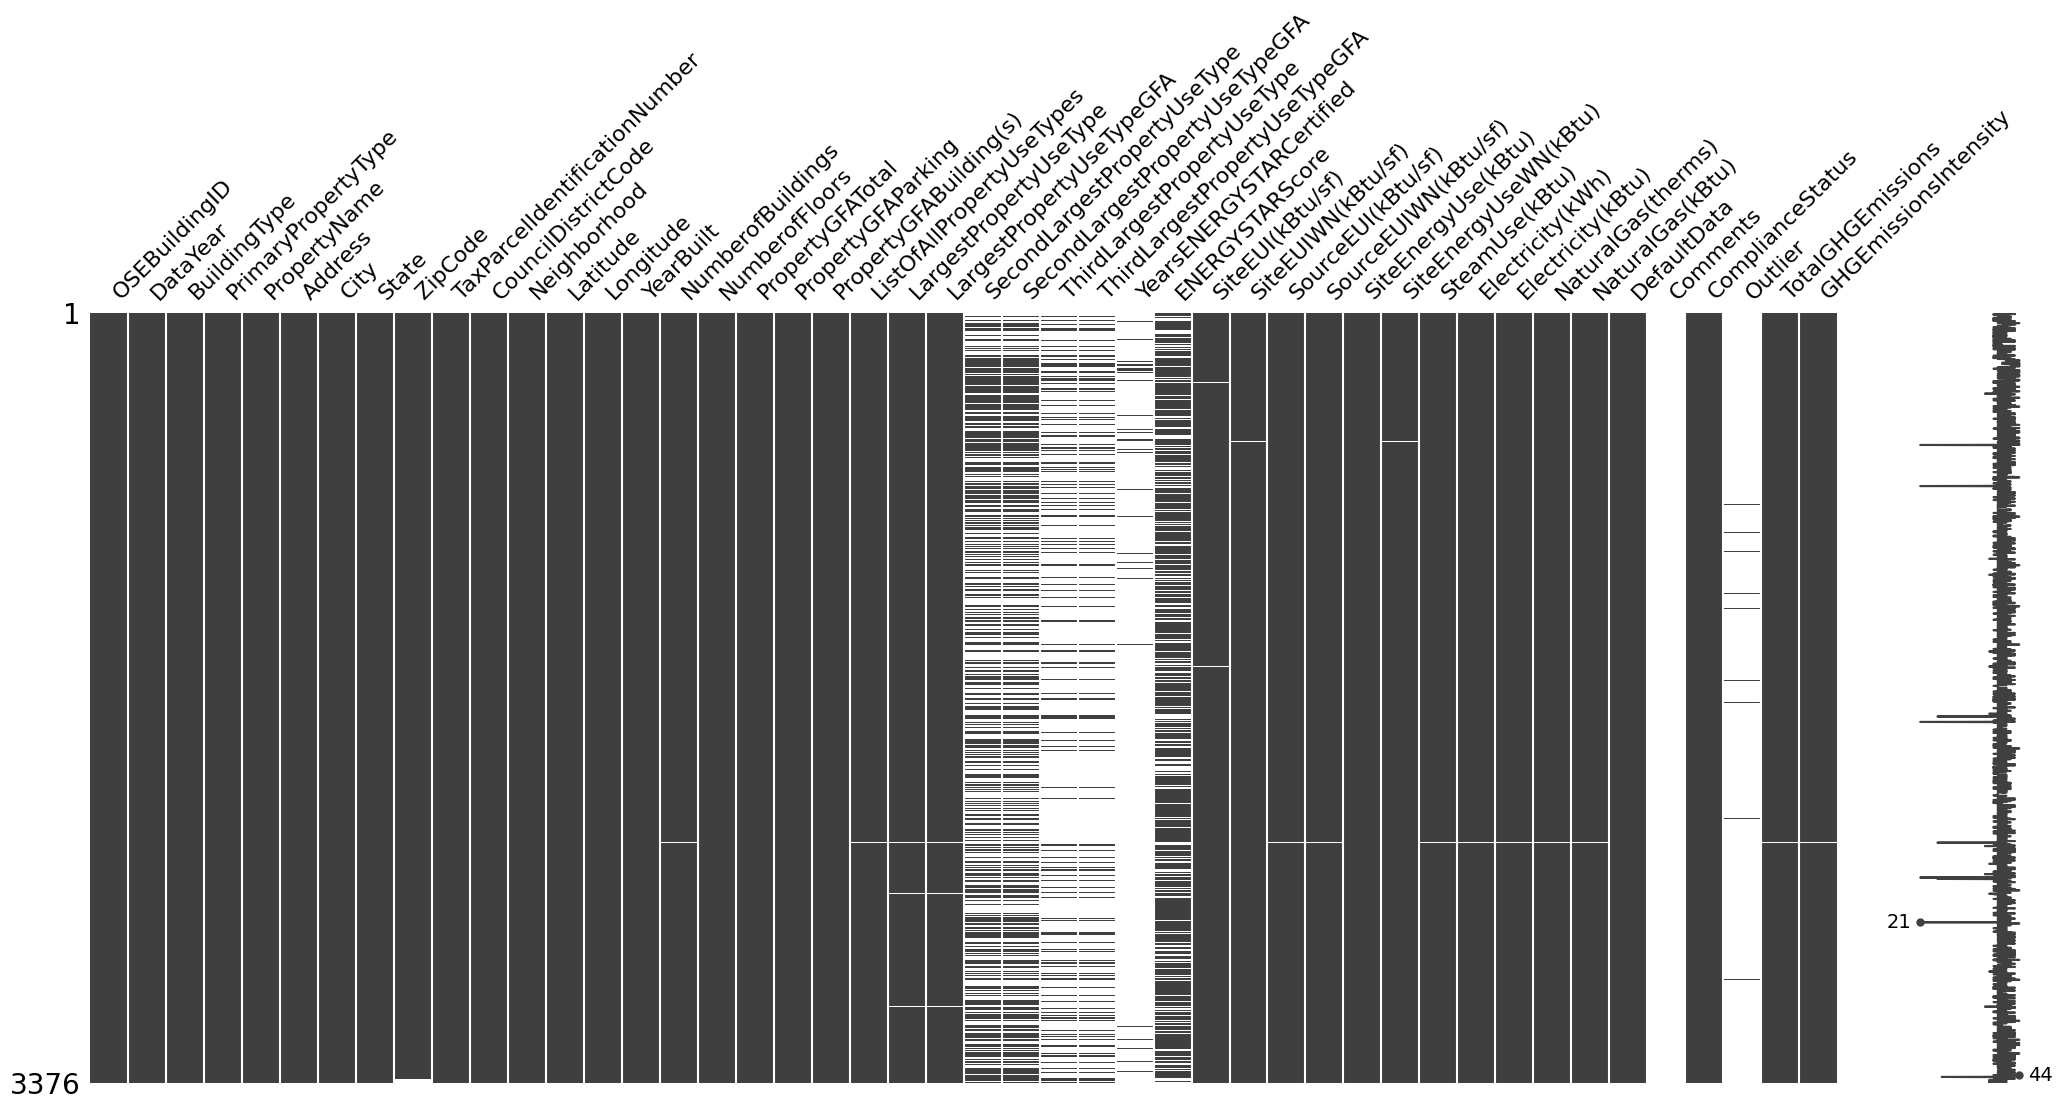

In [28]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_brut, True, True)

## <span style='background:green'>Doublons</span>

In [29]:
# Detection des doublons sur la variable du code
first = detect_doublon(df_data_brut, 'OSEBuildingID', 'first')

Doublons détecté(s) avec "first" sur "OSEBuildingID" : 0


___
**Bilan sur le jeu de données '2016_Building_Energy_Benchmarking.csv'**: 
___
-   Le jeu de données contient **3_376 lignes et 46 colonnes**.
<br><br>
- Le dataset contient des informations sur les batiments : 
  - **administratif** : type de bâtiment, types de commerce installés 
  - **géographique** : nom et localisation du bâtiment, type de voisinage
  - **temporelle** : date de construction du bâtiment, de la mesure
  - **structurelle** : superficie (avec et sans parking), nombre de batiments séparés, nombre d'étage, superficie par commerce
  - **qualité énergétique** : ENERGY STAR Score et sa date d'obtention
  - **quantité énergétique** : quantité d'énergie, normalisé par la météo, ratio énergie/superficie, vapeur, électricié, gaz
  - **émissions** : quantité d'émission de gaz à effet de serre, ration émission/superficie
<br><br>
- type de données :
  - **47,8% de nombre décimaux numérique** : 
  - **32,6% de texte**
  - 17,7% d'entier numériques
  - 2,2% de booléen
<br><br>
-   valeurs manquantes : 
    -   19_952  de NaN pour 155_296  observations (**12.85 %**).
    -   26 / 46 colonnes concernées
<br><br>
-   **Pas de doublons** sur la col 'OSEBuildingID'.
<br><br><br>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>
___

## <span style='background:green'>1/ Filtrage par taux de remplissage</span>

Nous identifions les colonnes qui présentent un taux de valeurs manquantes (NaN) > 50%. 

In [30]:
# Seuil_NaN
seuil_nan = 50

# Affichage graphique des NaN
df_Nan_par_ligne, df_to_supp = filtre_nan_par_seuil(df_data_brut, seuil_nan, False)

# Affichage
print("Voici les colonnes qui vont être supprimées: ")
display(df_to_supp)

Il y a 7 colonnes > 50 % de NaN
Voici les colonnes qui vont être supprimées: 


nombre  pourcent
SecondLargestPropertyUseTypeGFA  1697.0      50.3
SecondLargestPropertyUseType     1697.0      50.3
ThirdLargestPropertyUseTypeGFA   2780.0      82.3
ThirdLargestPropertyUseType      2780.0      82.3
YearsENERGYSTARCertified         3257.0      96.5
Outlier                          3344.0      99.1
Comments                         3376.0     100.0

Nous allons supprimer toutes ces features car il y a trop de valeurs manquantes pour parvenir à imputer des valeurs assez fiables. Une exception tout de même pour la feature "Outlier" qui, malgré son faible taux de remplissage, peut nous permettre d'avoir des informations intérressantes pour exclure les quelques outliers du dataset. Nous conservons cet feature. 

In [31]:
# Suppression de la ligne "Outlier" des features à effacer
df_to_supp = df_to_supp.drop("Outlier", axis=0)

# Suppression des features sélectionnées
df_data_clean_nan = df_data_brut.drop(columns=df_to_supp.index)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_nan, "df_data_clean_nan", "des nan", 2)

Voici l'aspect de 'df_data_clean_nan' après nettoyage des nan


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   

           PropertyName          Address     City State  ZipCode  \
0  Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1       Paramount Hotel  724 Pine street  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   

   PropertyGFAParking  PropertyGFABuilding(s)   ListOfAllPropertyUseTypes  \
0                   0                   88434                       Hotel   
1               15064                   88502  Hotel, Parking, Restaurant   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                  Hotel                    88434.0             60.0   
1                  Hotel                    83880.0             61.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              81.7                84.3           182.50000   
1              94.8                97.9           176.10001   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0             189.00000            7226362.5              7456910.0   
1             179.39999            8387933.0              8664479.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0       2003882.0       1.15651e+06          3946027.0         12764.52930   
1             0.0       9.50425e+05          3242851.0         51450.81641   

   NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  TotalGHGEmissions  \
0         1276453.0        False        Compliant     NaN             249.98   
1         5145082.0        False        Compliant     NaN             295.86   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86

3376 ligne(s) x 40 colonne(s)



## <span style='background:green'>2/ Suppression features redondantes</span>

### Liste des utilisation du batiment

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple de la feature qui liste les utilisations du bâtiment et qui est repris dans les features de chaque utilisation du bâtiment. 

Voici un échantillon pour preuve :

In [32]:
# Liste des colonnes sélectionnées
category_col = ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]

# Afficher un échantillon (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].sample(5)

ListOfAllPropertyUseTypes LargestPropertyUseType
894         College/University     College/University
482     Office, Other, Parking                 Office
2672       Multifamily Housing    Multifamily Housing
2323       Multifamily Housing    Multifamily Housing
1749       Multifamily Housing    Multifamily Housing

Manifestement, la première feature comprend les élements de la deuxième mais elle en contient d'autres également. Nous vérifions le taux de remplissage de ces features :

In [33]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 29 / 6752 données (0.43 %)
2 / 2 colonne(s) sont concernés


Dans le doute, nous allons garder ces features en l'état car nous ne savons pas laquelle possèdent le plus d'information pertinente. 

### Quantité d'énergie

Certaines features dans le dataset sont des features redondantes. C'est le cas par exemple des features qui indiquent la quantité d'énergie dans différentes unités. 

Voici un échantillon pour preuve :

In [34]:
# Liste des features sélectionnées
category_col = ["Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)"]

# Afficher le début (sans NaN)
df_data_clean_nan[df_data_clean_nan[category_col].notnull().any(axis=1)][category_col].head(3)

Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)
0       1.15651e+06          3946027.0         12764.52930         1276453.0
1       9.50425e+05          3242851.0         51450.81641         5145082.0
2       1.45154e+07         49526664.0         14938.00000         1493800.0

Sachant que:<br>
1 kBtu = 0,293 kWh => ALORS 3_946_027 kBtu = 1_156_185 kWh<br>
**Donc le feature "Electricity(kBtu)" est une conversion de la feature "Electricity(kWh)"**

Sachant que:<br>
1 therm = 100 kBtu => ALORS 12_764.52 therm = 1_276_452 kWh<br>
**Donc le feature "NaturalGas(kBtu)" est une conversion de la feature "NaturalGas(therms)"**

Si nous regardons le taux de remplissage de ces 4 features, nous pouvons constater qu'elles sont toutes les 4 remplies de façon similaire. Ce qui suppose que chacune d'elle contient les mêmes données, qui sont donc redondantes.

In [35]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_nan[category_col], True, False)

Valeurs manquantes (Nan) : 36 / 13504 données (0.27 %)
4 / 4 colonne(s) sont concernés



Dans un soucis d'harmonisation des unités de quantité d'énergie du dataset (en kBtu), nous supprimons les features qui ne sont pas en kBtu.

In [36]:
# Suppression des features redondantes
df_data_clean_tampon = df_data_clean_nan.drop(columns=["Electricity(kWh)", "NaturalGas(therms)"])

### Localisation

Les features "Address", "TaxParcelIdentificationNumber", "Latitude" et "Longitude" sont des features qui permettent de localiser le batiment.

Voici un échantillon pour preuve :

In [37]:
# Liste des features sélectionnées
category_col = ["Address", "TaxParcelIdentificationNumber", "Latitude", "Longitude"]

# Afficher le début (sans NaN)
df_data_clean_tampon[df_data_clean_tampon[category_col].notnull().any(axis=1)][category_col].head(3)

Address TaxParcelIdentificationNumber  Latitude  Longitude
0    405 Olive way                    0659000030  47.61220 -122.33799
1  724 Pine street                    0659000220  47.61317 -122.33393
2  1900 5th Avenue                    0659000475  47.61393 -122.33810

La simple connaissance de la latitude et de la longitude suffit pour localiser correctement le bâtiment. L'adresse et le numéro de parcelle (numéro généré à partir de différents informations telles que le canton, la zone géographique, etc) ne sont donc pas nécessaires. 

Si nous regardons le taux de remplissage de ces 4 features, nous constatons qu'elles sont toutes les 4 entièrement remplies. Ce qui suppose que chacune d'elle contiennent les mêmes données, qui sont donc redondantes.

In [38]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_tampon[category_col], True, False)

Valeurs manquantes (Nan) : 0 / 13504 données (0.0 %)
0 / 4 colonne(s) sont concernés


Nous supprimons donc les features "Address" et "TaxParcelIdentificationNumber". 

In [39]:
# Suppression des features redondantes
df_data_clean_redondant = df_data_clean_tampon.drop(columns=["Address", "TaxParcelIdentificationNumber"])

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_redondant, "df_data_clean_redondant", "des features redondantes", 2)

Voici l'aspect de 'df_data_clean_redondant' après nettoyage des features redondantes


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   

           PropertyName     City State  ZipCode  CouncilDistrictCode  \
0  Mayflower park hotel  Seattle    WA  98101.0                    7   
1       Paramount Hotel  Seattle    WA  98101.0                    7   

  Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
0     DOWNTOWN  47.61220 -122.33799       1927                1.0   
1     DOWNTOWN  47.61317 -122.33393       1996                1.0   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0              12             88434                   0   
1              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  \
0          3946027.0         1276453.0        False        Compliant     NaN   
1          3242851.0         5145082.0        False        Compliant     NaN   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

3376 ligne(s) x 36 colonne(s)



## <span style='background:green'>3/ Suppression features inutiles</span>

### Année de mesure, Ville, code postal et état

Nous remarquons que 3 features ne présentent chacun qu'une seule valeur avec la totalité du dataset

In [40]:
# Résumé d'une variable quantitative
df_data_clean_redondant[["DataYear"]].describe()

DataYear
count    3376.0
mean     2016.0
std         0.0
min      2016.0
25%      2016.0
50%      2016.0
75%      2016.0
max      2016.0

In [41]:
# Résumé de variables qualitatives
df_data_clean_redondant[["City", "State"]].describe()

City State
count      3376  3376
unique        1     1
top     Seattle    WA
freq       3376  3376

Il n'est donc pas utile de garder ces features. Il suffit de se rappeler que tous les batiments sont dans la ville de Seattle dans l'état de Washington. Le code postal est également inutile pour la suite des traitements. Nous pouvons supprimer ces features. 

In [42]:
# Liste des features inutiles à supprimer
col_to_supp = ["DataYear", "City", "State", "ZipCode"]

# Suppression des features inutiles
df_data_clean_inutile = df_data_clean_redondant.drop(columns=col_to_supp)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_inutile, "df_data_clean_inutile", "des features inutiles", 2)

Voici l'aspect de 'df_data_clean_inutile' après nettoyage des features inutiles


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  \
0          3946027.0         1276453.0        False        Compliant     NaN   
1          3242851.0         5145082.0        False        Compliant     NaN   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

3376 ligne(s) x 32 colonne(s)



## <span style='background:green'>4/ Conservation des batiments non destinés à l'habitation</span>

Notre mission ne concerne que les **bâtiments non destinés à l’habitation de la ville de Seattle**. Nous allons donc supprimer toutes les lignes qui sont des habitations dans la feature "BuildingType". 

Visualisons toutes les valeurs possible de cet feature :

In [43]:
df_data_clean_inutile['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Nous détectons 3 types de bâtiment qui sont destinées à l'habitation :
- 'Multifamily MR (5-9)'
- 'Multifamily LR (1-4)'
- 'Multifamily HR (10+)'

Nous supprimons les lignes de ces habitation 'Multifamily'. 

In [44]:
# Filtrage bâtiment non habitation
df_data_clean_habitation = df_data_clean_inutile[~df_data_clean_inutile['BuildingType'].str.contains("Multifamily")]

# Valeurs restantes de "BuildingType"
df_data_clean_habitation['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

Nous avons bien conservé uniquement les batiments non destinés à l'habitation.

In [45]:
# Mise à jour des index
df_data_clean_habitation.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_habitation, "df_data_clean_habitation", "des habitations", 2)

Voici l'aspect de 'df_data_clean_habitation' après nettoyage des habitations


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  \
0          3946027.0         1276453.0        False        Compliant     NaN   
1          3242851.0         5145082.0        False        Compliant     NaN   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

1668 ligne(s) x 32 colonne(s)



## <span style='background:green'>5/ Conservation des batiments non recencés en outlier</span>

La feature "outlier' nous indique les batiments qui peuvent être utile d'exclure pour éviter que leurs valeurs atypiques affectent nos calculs à venir. 

Visualisons toutes les valeurs possible de cet feature :

In [46]:
# Dataframe des lignes non nulle sur la feature "Outlier"
df_outlier_all = df_data_clean_habitation[df_data_clean_habitation["Outlier"].notnull()]

# Afficher les valeurs possibles
outlier_unique = df_outlier_all["Outlier"].unique()
display(outlier_unique)

# Affichage aperçu et dimension du dataframe
display(df_outlier_all)
print_nbr_ligne_col(df_outlier_all)

array(['High outlier', 'Low outlier'], dtype=object)

OSEBuildingID        BuildingType          PrimaryPropertyType  \
220             350      NonResidential                 Large Office   
378             539      NonResidential                 Retail Store   
442             608      NonResidential                 Large Office   
507             704      NonResidential                 Large Office   
698           19967   SPS-District K-12                  K-12 School   
777           20617      NonResidential                 Retail Store   
868           21315      NonResidential  Small- and Mid-Sized Office   
910           21474      NonResidential                        Other   
1033          22830      NonResidential             Worship Facility   
1134          23912      NonResidential  Small- and Mid-Sized Office   
1238          24547      NonResidential                  K-12 School   
1273          24717      NonResidential                        Other   
1285          24825      NonResidential  Small- and Mid-Sized Office   
1346          25553      NonResidential                        Hotel   
1365          25674      NonResidential         Low-Rise Multifamily   
1475          27007      NonResidential             Worship Facility   
1581          43948  Nonresidential COS                        Other   

                        PropertyName  CouncilDistrictCode  \
220       Second And Spring Building                    7   
378                University Center                    4   
442           411 1ST AVE  S (ID608)                    2   
507             401 Elliott Ave West                    7   
698                   Queen Anne Gym                    7   
777            Seattle Habitat Store                    2   
868                  1518 Fifith Ave                    7   
910                   The Lusty Lady                    7   
1033                  Freedom Church                    1   
1134                  1416 S Jackson                    3   
1238       Islamic School of Seattle                    3   
1273        1701 First Ave South LLC                    2   
1285                   2233 Building                    2   
1346  J & M HOTEL BUILDING (ID25553)                    7   
1365          (ID25674) COMET TAVERN                    3   
1475        Seattle Community Church                    4   
1581           Georgetown Steamplant                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
220                DOWNTOWN  47.60642 -122.33581       1958   
378               NORTHEAST  47.66178 -122.31812       1987   
442                DOWNTOWN  47.59878 -122.33458       1913   
507   MAGNOLIA / QUEEN ANNE  47.62235 -122.36378       2000   
698   MAGNOLIA / QUEEN ANNE  47.63203 -122.35337       2001   
777        GREATER DUWAMISH  47.56535 -122.34054       1953   
868                DOWNTOWN  47.61119 -122.33581       1903   
910                DOWNTOWN  47.60711 -122.33886       1900   
1033              SOUTHWEST  47.51709 -122.37797       1971   
1134                CENTRAL  47.59973 -122.31331       1947   
1238                CENTRAL  47.60885 -122.29990       1929   
1273       GREATER DUWAMISH  47.58788 -122.33458       1910   
1285       GREATER DUWAMISH  47.58292 -122.33468       1910   
1346               DOWNTOWN  47.60035 -122.33379       1900   
1365                   EAST  47.61427 -122.31977       1910   
1475              NORTHEAST  47.66146 -122.27880       1954   
1581       GREATER DUWAMISH  47.54277 -122.31626       1906   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
220                 1.0               6            172842               25920   
378                 1.0               2             69492                   0   
442                 5.0               7            154159                   0   
507                 1.0               4            129551               42500   
698                 1.0               1             35805             

17 ligne(s) x 32 colonne(s)



Nous supprimons ces batiments qui sont spécifiés comme étant des outliers

In [47]:
# Filtrage bâtiment outlier
df_data_clean_outlier = df_data_clean_habitation[~df_data_clean_habitation['Outlier'].isin(outlier_unique)]

L'information contenue dans la feature "Outlier" ayant été traitée, nous supprimons cet feature qui est faiblement remplie.

In [48]:
# Suppression des features inutiles
df_data_clean_outlier = df_data_clean_outlier.drop(columns=["Outlier"])

# Mise à jour des index
df_data_clean_outlier.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 2)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus  \
0          3946027.0         1276453.0        False        Compliant   
1          3242851.0         5145082.0        False        Compliant   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

1651 ligne(s) x 31 colonne(s)



## <span style='background:green'>6/ Filtrage des batiments par taux de remplissage > 50%</span>

Nous identifions les lignes des batiments qui présentent > 50% de valeurs manquantes. 

In [49]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean_outlier.select_dtypes(include=['int', 'float']).columns
feat_quanti_nb = len(feat_quanti_list)

# Définissez le seuil pour le % de NaN
seuil_valeur = 0.50
seuil_nb_feat = seuil_valeur * feat_quanti_nb

# Somme des NaN par ligne
nan_par_ligne_nb = df_data_clean_outlier.isna().sum(axis=1)

# Sélection et affichage des ligne au dessus du seuil
ligne_to_suppr = df_data_clean_outlier[nan_par_ligne_nb >= seuil_nb_feat]

print("Il y a {} features quantitatives, donc le seuil de {:.0f} % de NaN correspond à {:.0f} features minimum par ligne de bâtiment. Voici les lignes de bâtiment qui ne remplissent pas cette condition :".format(feat_quanti_nb, seuil_valeur * 100, seuil_nb_feat))
display(ligne_to_suppr)

Il y a 23 features quantitatives, donc le seuil de 50 % de NaN correspond à 12 features minimum par ligne de batiment. Voici les lignes de batiment qui ne remplissent pas cette condition :


OSEBuildingID    BuildingType          PrimaryPropertyType  \
564             773  NonResidential  Small- and Mid-Sized Office   
1408          26532  NonResidential           Mixed Use Property   

          PropertyName  CouncilDistrictCode Neighborhood  Latitude  Longitude  \
564   SEATTLE BUILDING                    7     DOWNTOWN  47.60380 -122.33293   
1408  KALBERG BUILDING                    4    NORTHEAST  47.66182 -122.31345   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
564        1924                NaN               4             63150   
1408       1928                NaN               2             20760   

      PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
564                    0                   63150                       NaN   
1408                   0                   20760                       NaN   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
564                     NaN                        NaN              NaN   
1408                    NaN                        NaN              NaN   

      SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
564                NaN                 NaN                 NaN   
1408               NaN                 NaN                 NaN   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
564                    NaN                  NaN                    NaN   
1408                   NaN                  NaN                    NaN   

      SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
564              NaN                NaN               NaN        False   
1408             NaN                NaN               NaN        False   

     ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  
564     Non-Compliant                NaN                    NaN  
1408    Non-Compliant                NaN                    NaN

Nous supprimons ces lignes de batiment avec > 50% de NaN dans les features quantitatives.

In [50]:
# Utilisez la méthode isin pour créer un masque (mask) des lignes à supprimer
masque = df_data_clean_outlier.isin(ligne_to_suppr.to_dict(orient='list')).all(axis=1)

# Appliquez le masque pour sélectionner les lignes à conserver
df_data_clean_batiment_nan = df_data_clean_outlier[~masque]

# Mise à jour des index
df_data_clean_batiment_nan.reset_index(drop=True, inplace=True)

# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_batiment_nan, "df_data_clean_batiment_nan", "des batiments avec >50% de caleurs manquantes", 2)

Voici l'aspect de 'df_data_clean_batiment_nan' après nettoyage des batiments avec >50% de caleurs manquantes


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus  \
0          3946027.0         1276453.0        False        Compliant   
1          3242851.0         5145082.0        False        Compliant   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

1649 ligne(s) x 31 colonne(s)



## <span style='background:green'>7/ Remplacement valeur abérrantes par Nan</span>

Nous vérifions les valeurs abérrantes dans les features quantitatives. Notamment les valeurs négatives qui ne sont pas possibles (à l'exception de la longitude). Or nous en observons dans les valeurs min de 4 features :

In [51]:
# Isolement des colonnes quantitatives
features_quantitatives_pos = df_data_clean_batiment_nan[feat_quanti_list]

# Exclusion de la feature 'Longitude' 
if 'Longitude' in features_quantitatives_pos:
    features_quantitatives_pos = features_quantitatives_pos.drop(columns='Longitude')

# Isolement des features avec valeurs négatives
features_avec_neg = features_quantitatives_pos.columns[(features_quantitatives_pos < 0).any()]

# Affichez le résumé des features avec des valeurs négatives
resume_negatif = df_data_clean_batiment_nan[features_avec_neg]
display(resume_negatif.describe())

SourceEUIWN(kBtu/sf)  Electricity(kBtu)  TotalGHGEmissions  \
count            1649.00000        1.64900e+03         1649.00000   
mean              178.63050        5.86101e+06          186.50008   
std               184.30114        2.08735e+07          755.63498   
min                -2.10000       -1.15417e+05           -0.80000   
25%                80.50000        7.29477e+05           20.48000   
50%               135.10001        1.63310e+06           49.98000   
75%               205.89999        4.87889e+06          144.41000   
max              2620.00000        6.57074e+08        16870.98000   

       GHGEmissionsIntensity  
count             1649.00000  
mean                 1.62131  
std                  2.34443  
min                 -0.02000  
25%                  0.36000  
50%                  0.88000  
75%                  1.90000  
max                 34.09000

Nous remplaçons ces valeurs négatives par des NaN pour pouvoir les imputer par la suite.

In [52]:
# Remplacement des valeurs négatives par des NaN
df_data_clean_negative = remplace_negatives_par_nan(df_data_clean_batiment_nan, resume_negatif.columns)

Nous vérifions les valeurs min des features concernées.

In [53]:
# Affichez le résumé des colonnes avec des valeurs négatives
resume_negatif = df_data_clean_negative[features_avec_neg]
display(resume_negatif.describe())

SourceEUIWN(kBtu/sf)  Electricity(kBtu)  TotalGHGEmissions  \
count            1648.00000        1.64800e+03         1648.00000   
mean              178.74017        5.86464e+06          186.61373   
std               184.30326        2.08793e+07          755.85024   
min                 0.00000        0.00000e+00            0.00000   
25%                80.57500        7.29584e+05           20.60000   
50%               135.10001        1.63321e+06           50.01500   
75%               205.89999        4.88288e+06          144.50500   
max              2620.00000        6.57074e+08        16870.98000   

       GHGEmissionsIntensity  
count             1648.00000  
mean                 1.62231  
std                  2.34479  
min                  0.00000  
25%                  0.36000  
50%                  0.88000  
75%                  1.90250  
max                 34.09000

Nous affichons le dataframe nettoyé

In [54]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_negative, "df_data_clean_negative", "des valeurs négatives", 2)

Voici l'aspect de 'df_data_clean_negative' après nettoyage des valeurs négatives


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   

   LargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                    88434.0             60.0              81.7   
1                    83880.0             61.0              94.8   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                84.3           182.50000             189.00000   
1                97.9           176.10001             179.39999   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   

   Electricity(kBtu)  NaturalGas(kBtu)  DefaultData ComplianceStatus  \
0          3946027.0         1276453.0        False        Compliant   
1          3242851.0         5145082.0        False        Compliant   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86

1649 ligne(s) x 31 colonne(s)



## <span style='background:green'>8/ Imputation feature qualitative</span>

Le dataframe actuel ne comporte plus beaucoup de valeurs manquantes.

In [55]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_negative, True, False)

Valeurs manquantes (Nan) : 581 / 51119 données (1.14 %)
10 / 31 colonne(s) sont concernés


Nous remarquons qu'il n'y a que la feature "ENERGYSTARScore" pour laquelle de nombreuses lignes de bâtiment présentent des valeurs manquantes. Nous traiterons cet feature dans un second temps. 

Affichons d'abord le type de donnée des lignes de batiment qui présentent une valeur manquante sur d'autres features.

Puis affichons les lignes concernées par ces NaN. 

In [56]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_nan_list = df_data_clean_negative.columns[df_data_clean_negative.isna().any()].tolist()

# Supprimer la colonne 'ENERGY' de la liste
feat_a_supprimer = 'ENERGYSTARScore'
feature_nan_list = [col for col in feature_nan_list if col != feat_a_supprimer]

# Répartition du type de variable
compteur_type_variable(df_data_clean_negative[feature_nan_list], True, False, False)

# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_negative, feature_nan_list)

----------------------------------------------------------------------------------------------------
Type de variable pour chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LargestPropertyUseType     1645 non-null   object 
 1   LargestPropertyUseTypeGFA  1645 non-null   float64
 2   SiteEUI(kBtu/sf)           1648 non-null   float64
 3   SiteEUIWN(kBtu/sf)         1648 non-null   float64
 4   SourceEUIWN(kBtu/sf)       1648 non-null   float64
 5   SiteEnergyUseWN(kBtu)      1648 non-null   float64
 6   Electricity(kBtu)          1648 non-null   float64
 7   TotalGHGEmissions          1648 non-null   float64
 8   GHGEmissionsIntensity      1648 non-null   float64
dtypes: float64(8), object(1)
memory usage: 116.1+ KB


None

 Voici 7 les lignes de batiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


LargestPropertyUseType  LargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  \
297       Convention Center                  1072000.0               NaN   
346                     NaN                        NaN              47.8   
549                  Office                   120248.0              39.5   
814                     NaN                        NaN              52.2   
1335                    NaN                        NaN              72.2   
1352                    NaN                        NaN              31.2   
1586                 Office                    48159.0               7.1   

      SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  \
297                  0.0               0.00000            0.00000e+00   
346                 51.0             106.40000            6.07696e+06   
549                  NaN               0.00000                    NaN   
814                 53.5             154.39999            2.96843e+06   
1335                74.7             234.60001            3.28096e+06   
1352                32.5              62.80000            9.35833e+05   
1586                 5.0                   NaN            2.40132e+05   

      Electricity(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
297                 0.0               0.00                   0.00  
346           3007514.0             163.83                   1.47  
549           4871126.0             109.16                   0.83  
814           2534592.0              36.92                   0.60  
1335          3168131.0              22.09                   0.46  
1352           402907.0              29.21                   1.01  
1586                NaN                NaN                    NaN

Nous remarquons que seul la feature "LargestPropertyUseType" contient des données qualitatives. Nous avons vu précedement que la feature "ListOfAllPropertyUseTypes" présente les valeurs des 3 features de la famille de "LargestPropertyUseType".  

Affichons les valeurs de ces 2 features à l'endroit où il y a des NaN :

In [57]:
# Liste des features avec des Nan (hors "ENERGYSTARScore")
feature_usetype_list = ["ListOfAllPropertyUseTypes", "LargestPropertyUseType"]

# Création masque pour identifier les lignes avec NaN (hors feature spécifiée)
masque_nan = df_data_clean_negative[feature_usetype_list].isna().any(axis=1)

# Appliquez le masque pour filtrer les lignes
lignes_nan_usetype = df_data_clean_negative[masque_nan]

# Affichez les lignes avec NaN dans la colonne 'LargestPropertyUseType'
display(lignes_nan_usetype[feature_usetype_list])

ListOfAllPropertyUseTypes LargestPropertyUseType
346   Fitness Center/Health Club/Gym, Office, Other ...                    NaN
814                                               Hotel                    NaN
1335                                             Office                    NaN
1352                                         Restaurant                    NaN

Nous pouvons implémenter les valeurs manquantes de la feature "LargestPropertyUseType" avec celle de la feature "ListOfAllPropertyUseTypes" puisqu'il n'y a qu'une seule valeur. A l'exception de la ligne 346 car il n'y a pas qu'une seule valeur (nous la supprimons). 

In [58]:
# Copie du dataframe
df_data_clean_usetype_nan = df_data_clean_negative.copy()

# Suppression de la ligne 346
df_data_clean_usetype_nan.drop(346, inplace=True)

# Mise à jour des index
df_data_clean_usetype_nan.reset_index(drop=True, inplace=True)

# Remplacez NaN de 'LargestPropertyUseType' par valeur 'ListOfAllPropertyUseTypes'
df_data_clean_usetype_nan['LargestPropertyUseType'].fillna(df_data_clean_usetype_nan['ListOfAllPropertyUseTypes'], inplace=True)

Nous affichons à nouveau les lignes qui étaient concernées par les NaN (sauf "ENERGYSTARScore"). 

In [59]:
# Affichage NaN (sans prendre en compte "ENERGYSTARScore")
lignes_avec_nan = affiche_nan_hors_energyscore(df_data_clean_usetype_nan, feature_nan_list)

 Voici 6 les lignes de batiment qui présentent des Nan, hors feature 'ENERGYSTARScore' :


LargestPropertyUseType  LargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  \
297       Convention Center                  1072000.0               NaN   
548                  Office                   120248.0              39.5   
813                   Hotel                        NaN              52.2   
1334                 Office                        NaN              72.2   
1351             Restaurant                        NaN              31.2   
1585                 Office                    48159.0               7.1   

      SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  \
297                  0.0               0.00000            0.00000e+00   
548                  NaN               0.00000                    NaN   
813                 53.5             154.39999            2.96843e+06   
1334                74.7             234.60001            3.28096e+06   
1351                32.5              62.80000            9.35833e+05   
1585                 5.0                   NaN            2.40132e+05   

      Electricity(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
297                 0.0               0.00                   0.00  
548           4871126.0             109.16                   0.83  
813           2534592.0              36.92                   0.60  
1334          3168131.0              22.09                   0.46  
1351           402907.0              29.21                   1.01  
1585                NaN                NaN                    NaN

Nous remarquons que la feature "LargestPropertyUseType" est bien remplie. Nous pouvons supprimer cet feature de la liste des features présentant des Nan.

In [60]:
# Enlevez 'LargestPropertyUseType' de la liste
feature_nan_list.remove("LargestPropertyUseType")

# Affichez la liste mise à jour
print(feature_nan_list)

['LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


Nous supprimons la feature "ListOfAllPropertyUseTypes" du dataframe puisqu'elle ne nous apporte plus d'information utiles car elle est désormais redondantes avec la feature "LargestPropertyUseType". 

In [61]:
# Suppression des features sélectionnées
df_data_clean_usetype_nan = df_data_clean_usetype_nan.drop(columns="ListOfAllPropertyUseTypes")


Les NaN restantes ne concernent plus que des données quantitatives. 

In [62]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_usetype_nan, True, False)

Valeurs manquantes (Nan) : 575 / 49440 données (1.16 %)
9 / 30 colonne(s) sont concernés


In [63]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_usetype_nan, "df_data_clean_usetype_nan", "des Nan des features qualitatifs", 2)

Voici l'aspect de 'df_data_clean_usetype_nan' après nettoyage des Nan des features qualitatifs


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   

   PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                   88434                  Hotel                    88434.0   
1                   88502                  Hotel                    83880.0   

   ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0             60.0              81.7                84.3           182.50000   
1             61.0              94.8                97.9           176.10001   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0             189.00000            7226362.5              7456910.0   
1             179.39999            8387933.0              8664479.0   

   SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  DefaultData  \
0       2003882.0          3946027.0         1276453.0        False   
1             0.0          3242851.0         5145082.0        False   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  
0        Compliant             249.98                   2.83  
1        Compliant             295.86                   2.86

1648 ligne(s) x 30 colonne(s)



## <span style='background:green'>9/ Imputation features quantitatives</span>

Nous isolons les features quantitatives dans un dataframe de travail pour l'imputation. 

In [64]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_clean_usetype_nan.select_dtypes(include=['int', 'float']).columns

# df de travail est une copie des features quantitatives du dataframe
df_travail = df_data_clean_usetype_nan[feat_quanti_list]

# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

OSEBuildingID  CouncilDistrictCode  Latitude  Longitude  YearBuilt  \
0              1                    7  47.61220 -122.33799       1927   
1              2                    7  47.61317 -122.33393       1996   
2              3                    7  47.61393 -122.33810       1969   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
2                1.0              41            956110              196718   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                   88434                    88434.0             60.0   
1                   88502                    83880.0             61.0   
2                  759392                   756493.0             43.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              81.7                84.3           182.50000   
1              94.8                97.9           176.10001   
2              96.0                97.7           241.89999   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0             189.00000            7226362.5              7456910.0   
1             179.39999            8387933.0              8664479.0   
2             244.10001           72587024.0             73937112.0   

   SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0       2003882.0          3946027.0         1276453.0             249.98   
1             0.0          3242851.0         5145082.0             295.86   
2      21566554.0         49526664.0         1493800.0            2089.28   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19

(1648, 23)


### Feature avec des valeurs manquantes (hors ENERGYSTARScore)

Nous allons implémenter les NaN des features présentant des Nan par des calculs de machine learning en utilisant l'algorithme KNN. 

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

['LargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'] 



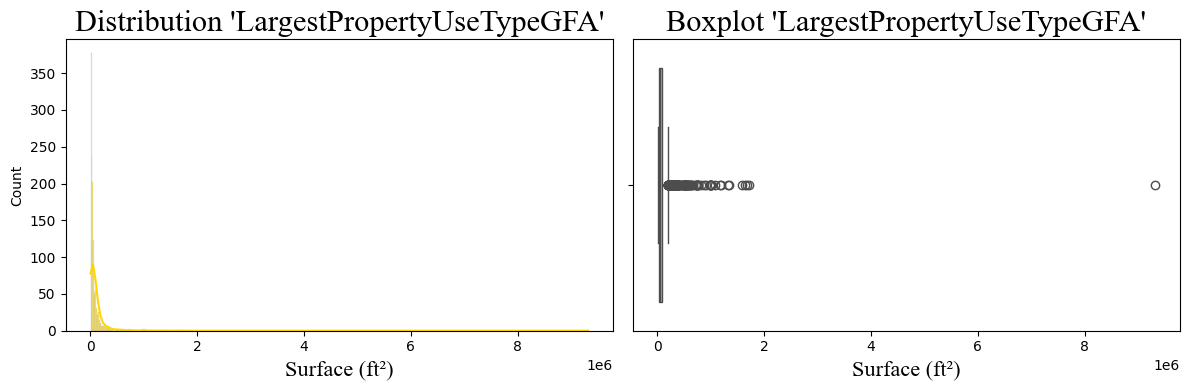

Q1  moyenne  médiane       Q3  ecart-type   CV  skewness  kurtosis
0  25649.0  99299.2  44078.0  92129.0    277968.6  2.8     23.18     739.5

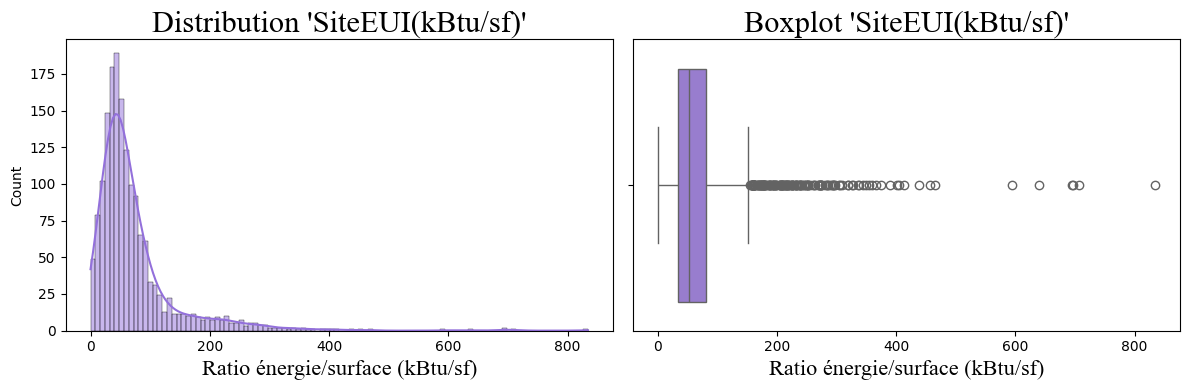

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  34.0     72.5     52.1  81.8        73.7  1.02      3.77      22.7

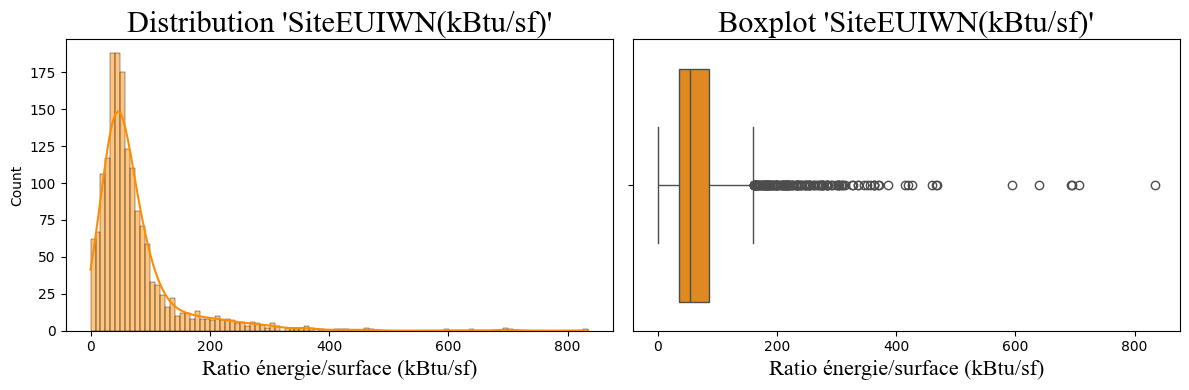

Q1  moyenne  médiane    Q3  ecart-type   CV  skewness  kurtosis
0  36.0     74.9     54.3  85.6        74.7  1.0      3.67      21.5

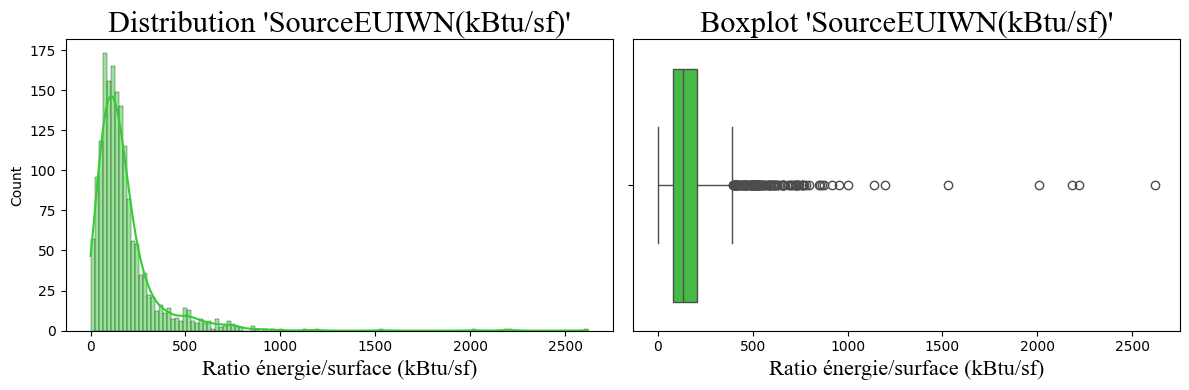

Q1  moyenne  médiane     Q3  ecart-type    CV  skewness  kurtosis
0  80.5    178.8    135.1  205.9       184.3  1.03       5.0      45.1

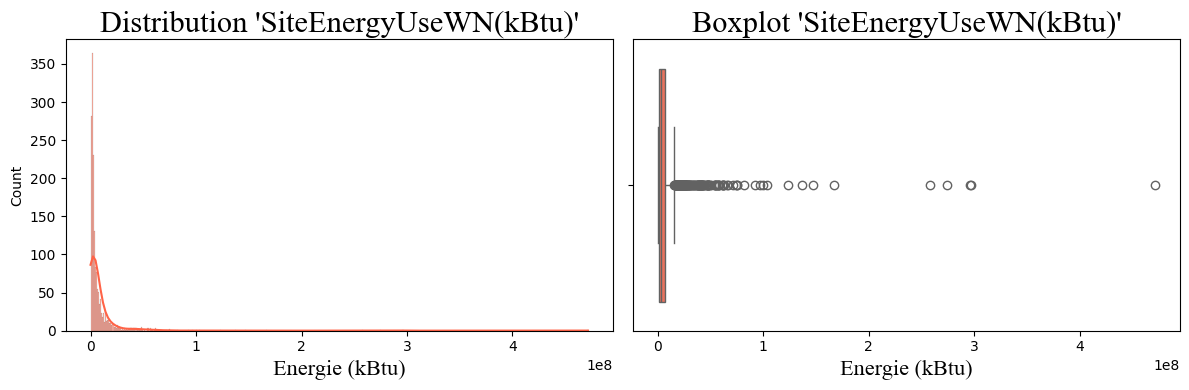

Q1    moyenne    médiane         Q3  ecart-type    CV  skewness  \
0  1319331.9  8099006.3  2726126.8  7172461.8  22119613.4  2.73     11.28   

   kurtosis  
0     177.4

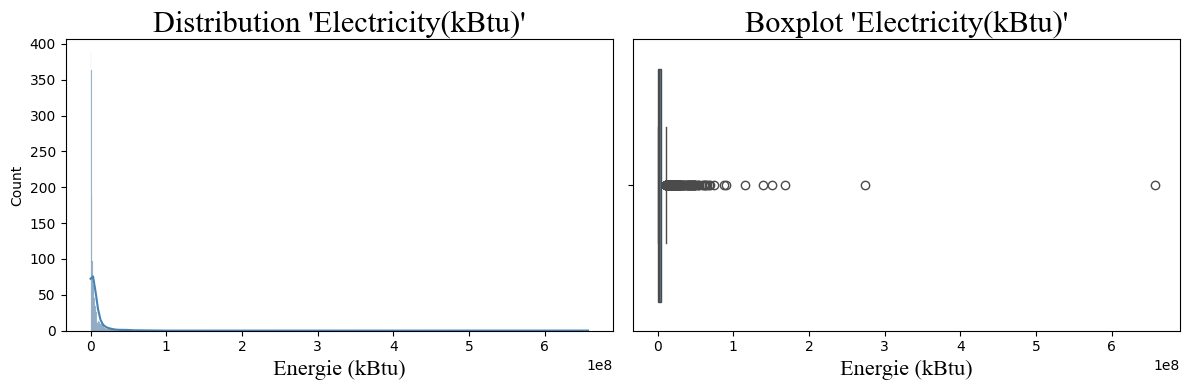

Q1    moyenne    médiane         Q3  ecart-type    CV  skewness  \
0  729548.5  5866370.8  1633105.0  4886868.5  20879190.4  3.56     20.82   

   kurtosis  
0     596.1

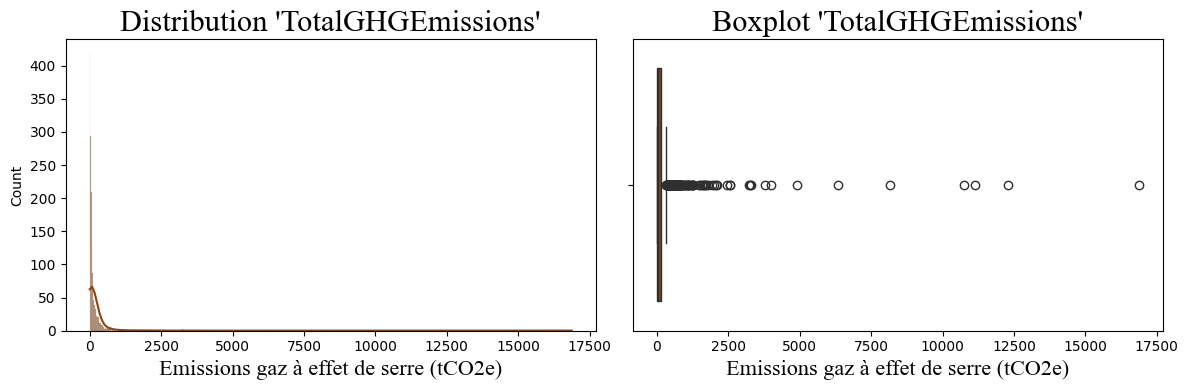

Q1  moyenne  médiane     Q3  ecart-type    CV  skewness  kurtosis
0  20.6    186.6     50.0  143.9       755.9  4.05     14.14     244.4

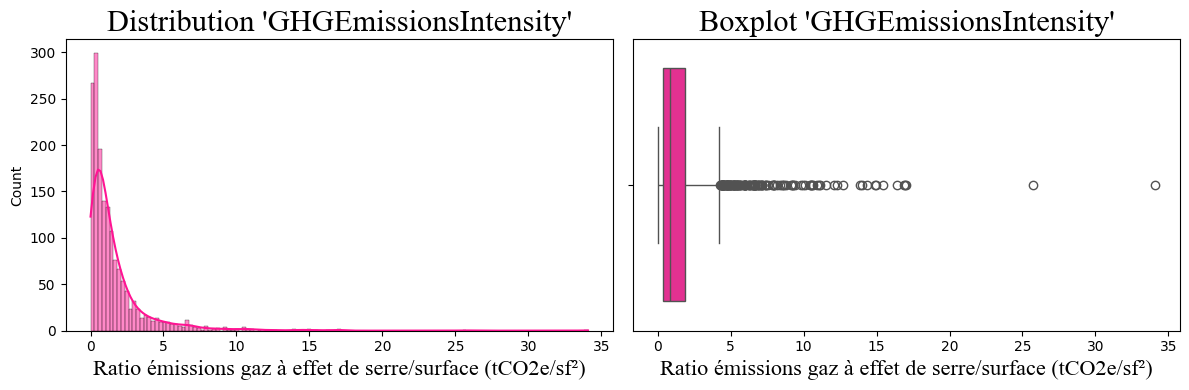

Q1  moyenne  médiane   Q3  ecart-type    CV  skewness  kurtosis
0  0.4      1.6      0.9  1.9         2.3  1.44      4.69      37.8

In [65]:
# Liste des features avec des Nan
print(feature_nan_list, "\n")

# POUR chaque feature avec NaN
for idx, col in enumerate(feature_nan_list): 
    
    # Courbe (axe des X adapté à chaque feature)
    if "sf" in col[-5:]:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio énergie/surface (kBtu/sf)")

    elif "Largest" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Surface (ft²)")
    
    elif "TotalGHGE" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Emissions gaz à effet de serre (tCO2e)")

    elif "Intensity" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio émissions gaz à effet de serre/surface (tCO2e/sf²)")

    else:
        plot_distribution(df_travail, col, colors_list[idx], unit="Energie (kBtu)")
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_travail, col)
    display(df_stat)

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

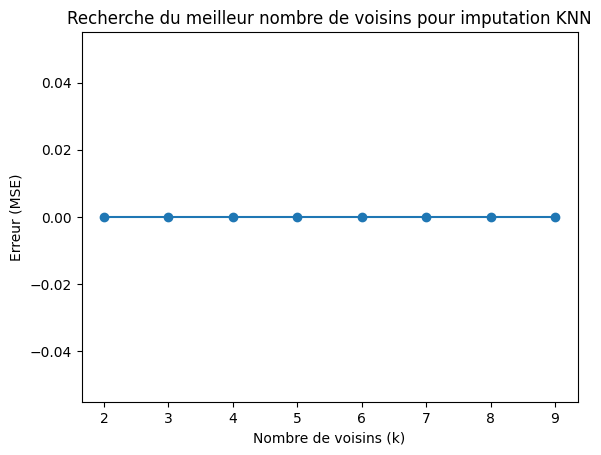

Le meilleur nombre de voisins est : 2


In [66]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail, k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [67]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail[feature_nan_list]), columns=df_travail[feature_nan_list].columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

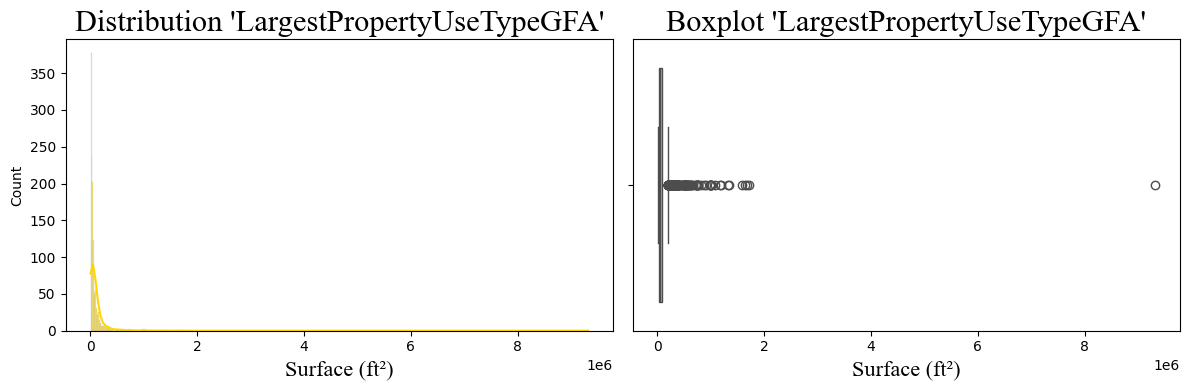

Q1  moyenne  médiane       Q3  ecart-type   CV  skewness  kurtosis
0  25649.0  99299.2  44078.0  92129.0    277968.6  2.8     23.18     739.5

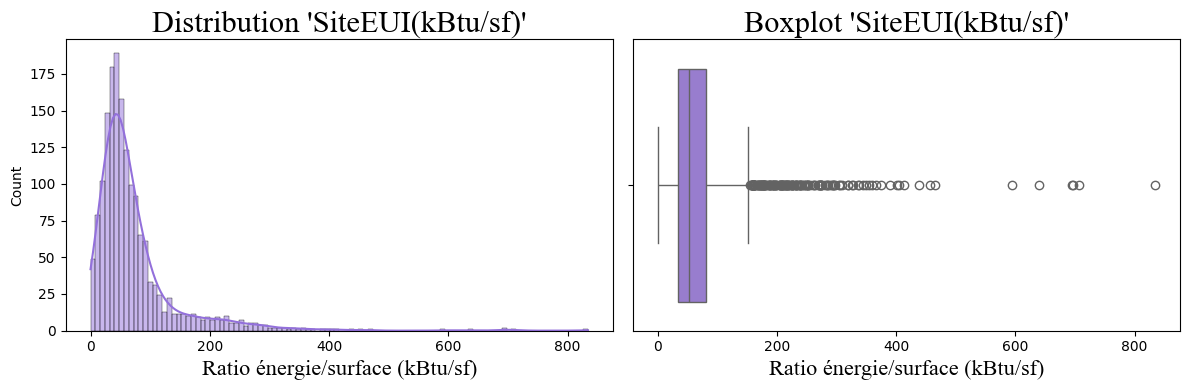

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  34.0     72.5     52.1  81.8        73.7  1.02      3.77      22.7

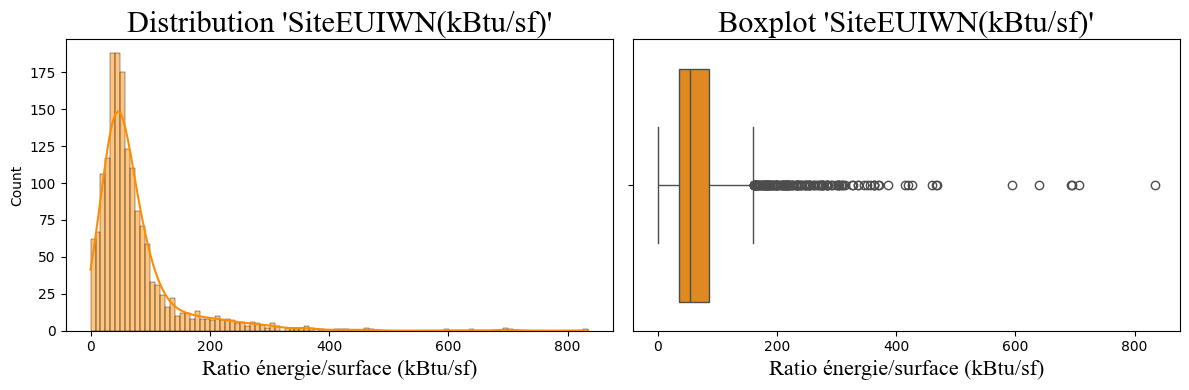

Q1  moyenne  médiane    Q3  ecart-type   CV  skewness  kurtosis
0  36.0     74.9     54.3  85.6        74.7  1.0      3.67      21.5

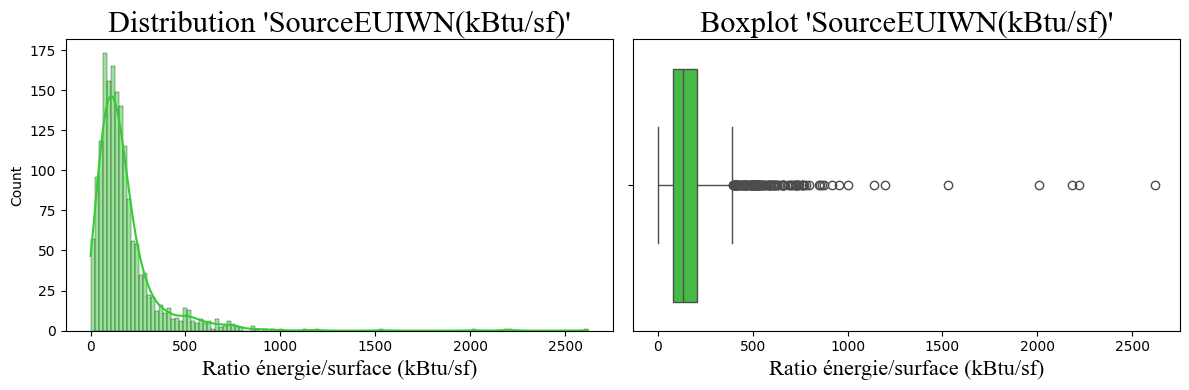

Q1  moyenne  médiane     Q3  ecart-type    CV  skewness  kurtosis
0  80.5    178.8    135.1  205.9       184.3  1.03       5.0      45.1

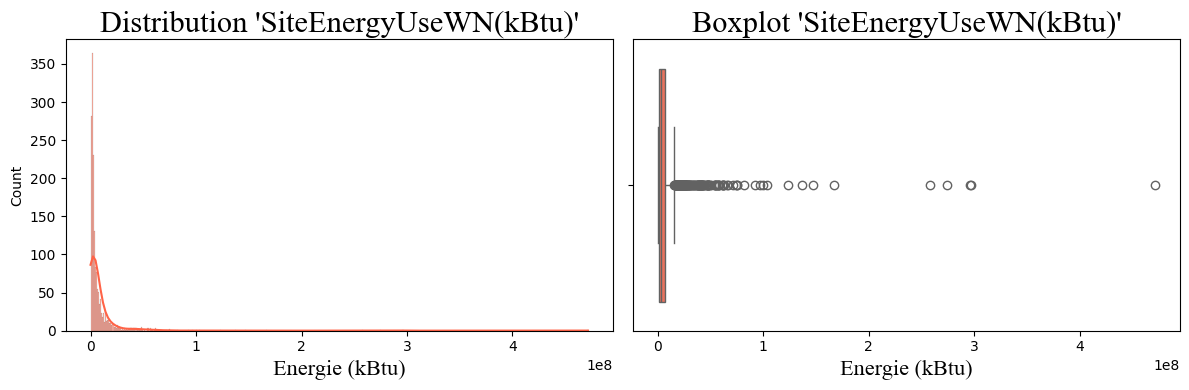

Q1    moyenne    médiane         Q3  ecart-type    CV  skewness  \
0  1319331.9  8099006.3  2726126.8  7172461.8  22119613.4  2.73     11.28   

   kurtosis  
0     177.4

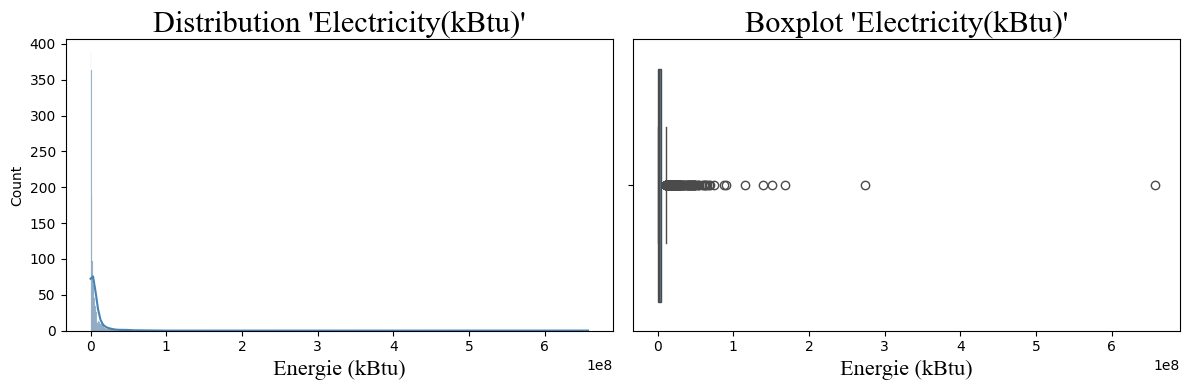

Q1    moyenne    médiane         Q3  ecart-type    CV  skewness  \
0  729548.5  5866370.8  1633105.0  4886868.5  20879190.4  3.56     20.82   

   kurtosis  
0     596.1

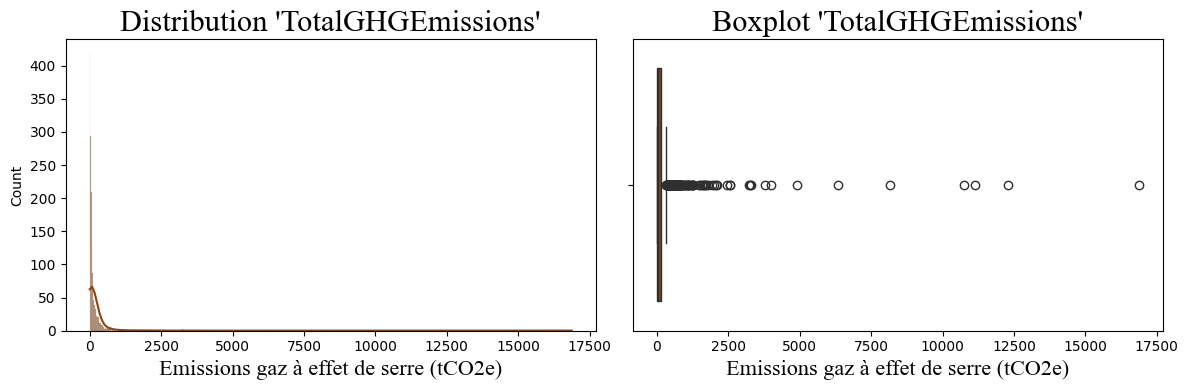

Q1  moyenne  médiane     Q3  ecart-type    CV  skewness  kurtosis
0  20.6    186.6     50.0  143.9       755.9  4.05     14.14     244.4

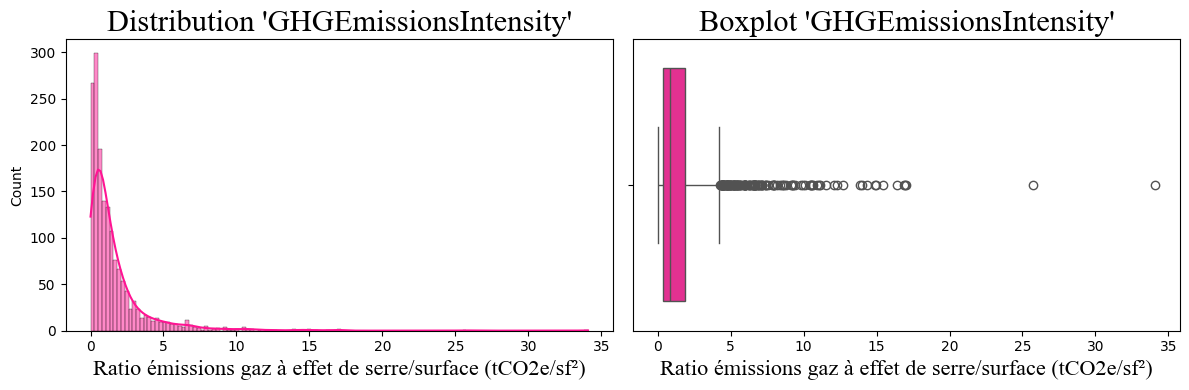

Q1  moyenne  médiane   Q3  ecart-type    CV  skewness  kurtosis
0  0.4      1.6      0.9  1.9         2.3  1.44      4.69      37.8

In [68]:
# POUR chaque feature avec NaN
for idx, col in enumerate(feature_nan_list): 
    
    # Courbe (axe des X adapté à chaque feature)
    if "sf" in col[-5:]:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio énergie/surface (kBtu/sf)")

    elif "Largest" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Surface (ft²)")
    
    elif "TotalGHGE" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Emissions gaz à effet de serre (tCO2e)")

    elif "Intensity" in col:
        plot_distribution(df_travail, col, colors_list[idx], unit="Ratio émissions gaz à effet de serre/surface (tCO2e/sf²)")

    else:
        plot_distribution(df_travail, col, colors_list[idx], unit="Energie (kBtu)")
    
    # Calcul des stats descriptives
    df_stat = stats_descriptives(df_travail, col)
    display(df_stat)

La distribution des données d'énergie qui présentaient des NaN ont été bien conservées suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [69]:
# Affichage dataframe des données imputées
display(df_datas_imputed.head(3))
print(df_datas_imputed.shape)

LargestPropertyUseTypeGFA  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
0                    88434.0              81.7                84.3   
1                    83880.0              94.8                97.9   
2                   756493.0              96.0                97.7   

   SourceEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  Electricity(kBtu)  \
0             189.00000              7456910.0          3946027.0   
1             179.39999              8664479.0          3242851.0   
2             244.10001             73937112.0         49526664.0   

   TotalGHGEmissions  GHGEmissionsIntensity  
0             249.98                   2.83  
1             295.86                   2.86  
2            2089.28                   2.19

(1648, 8)


In [70]:
# Affichage dataframe des données quantitatives
display(df_travail.head(3))
print(df_travail.shape)

OSEBuildingID  CouncilDistrictCode  Latitude  Longitude  YearBuilt  \
0              1                    7  47.61220 -122.33799       1927   
1              2                    7  47.61317 -122.33393       1996   
2              3                    7  47.61393 -122.33810       1969   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
2                1.0              41            956110              196718   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                   88434                    88434.0             60.0   
1                   88502                    83880.0             61.0   
2                  759392                   756493.0             43.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              81.7                84.3           182.50000   
1              94.8                97.9           176.10001   
2              96.0                97.7           241.89999   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0             189.00000            7226362.5              7456910.0   
1             179.39999            8387933.0              8664479.0   
2             244.10001           72587024.0             73937112.0   

   SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0       2003882.0          3946027.0         1276453.0             249.98   
1             0.0          3242851.0         5145082.0             295.86   
2      21566554.0         49526664.0         1493800.0            2089.28   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19

(1648, 23)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir remplacer les features du dataframe avec NaN par celui avec les  valeurs imputées.

In [71]:
# Remplacez features dans dataframe avec NaN par celles du dataframe imputé
df_travail.loc[:, feature_nan_list] = df_datas_imputed.loc[:, feature_nan_list]

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [72]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 565 / 37904 données (1.49 %)
1 / 23 colonne(s) sont concernés


### ENERGYScore

Nous réalisons l'imputation avec 3 méthodes pour pouvoir les comparer plus tard lors de l'analyse des corrélations si elles présentent des résultats d'imputation satisfaisants:
- Imputation par la médiane
- Imputation par l'algorithme KNN
- Imputation par algorithme iterative imputer

Nous allons d'abord observer la distribution et les statitisques descriptives des colonnes avant l'imputation.

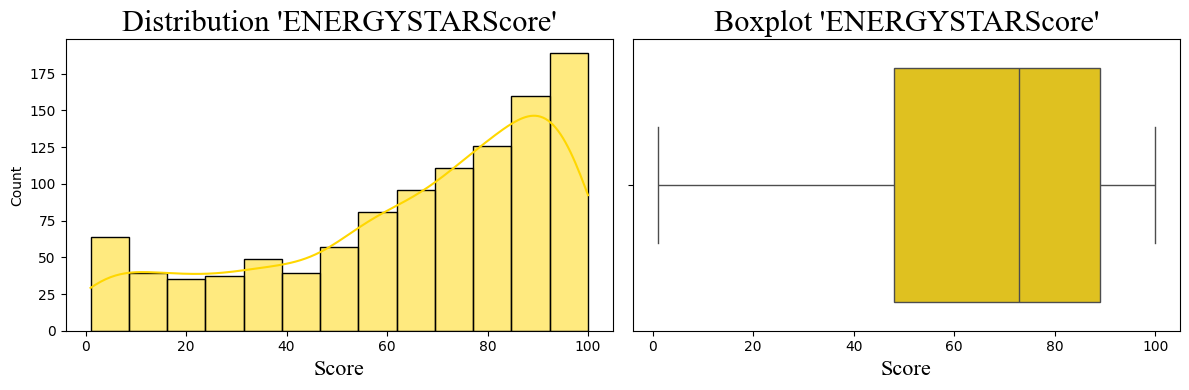

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  48.0     65.2     73.0  89.0        28.4  0.44     -0.77      -0.5

In [73]:
# Courbe
plot_distribution(df_travail, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_travail, "ENERGYSTARScore")
display(df_stat)

#### Imputation par la médiane

Nous allons utiliser l'imputation par le Simple Imputer paramétrer sur la médiane.

In [74]:
# Créez un objet imputer pour l'imputation par la médiane
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Appliquez l'imputation sur un DataFrame
datas_imputed = imputer.fit_transform(df_travail)
df_datas_imputed = pd.DataFrame(datas_imputed, columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

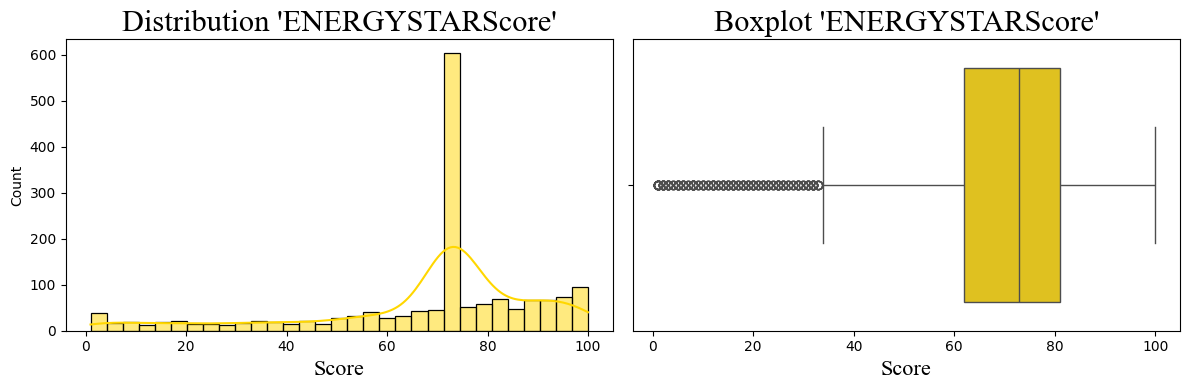

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  62.0     67.9     73.0  81.0        23.3  0.34     -1.25       1.1

In [75]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN n'a pas été bien conservée suite à l'implémentation par la médiane. 

**Nous ne retenons par la méthode d'imputation par la médiane car les résultats sont de mauvaise qualité.**

#### Imputation par l'algorithme KNN

Nous allons utiliser l'imputation par le KNNImputer.

Nous allons d'abord utiliser un GridSearch pour calculer le nombre de voisin optimal pour l'imputation KNN

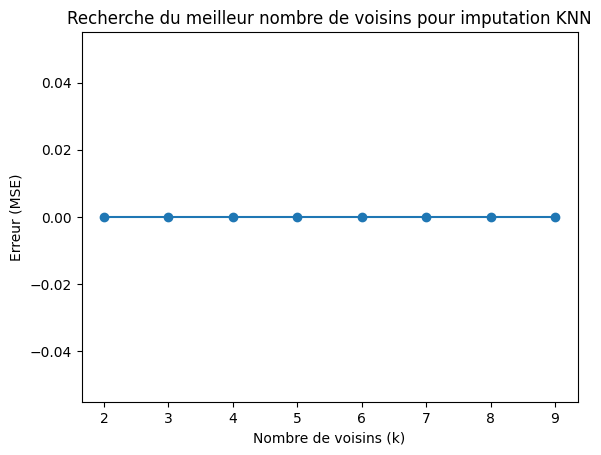

Le meilleur nombre de voisins est : 2


In [76]:
# Bornes du GridSearch
k_min, k_max = 2, 10

# Calcul du meilleur nombre de voisin pour l'imputation KNN
errors = determine_meilleur_voisin_knn(df_travail, k_min, k_max)

Nous réalisons donc l'imputation KNN avec le nombre optimal de voisin trouvés : 2

In [77]:
# Créez un objet d'imputation KNN (2 voisins proches, valeurs manquantes=NaN)
imputerKNN = KNNImputer(n_neighbors=2, missing_values=np.nan)

# Entraînez et applique le modèle d'imputation KNN 
df_datas_imputed = pd.DataFrame(imputerKNN.fit_transform(df_travail), columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

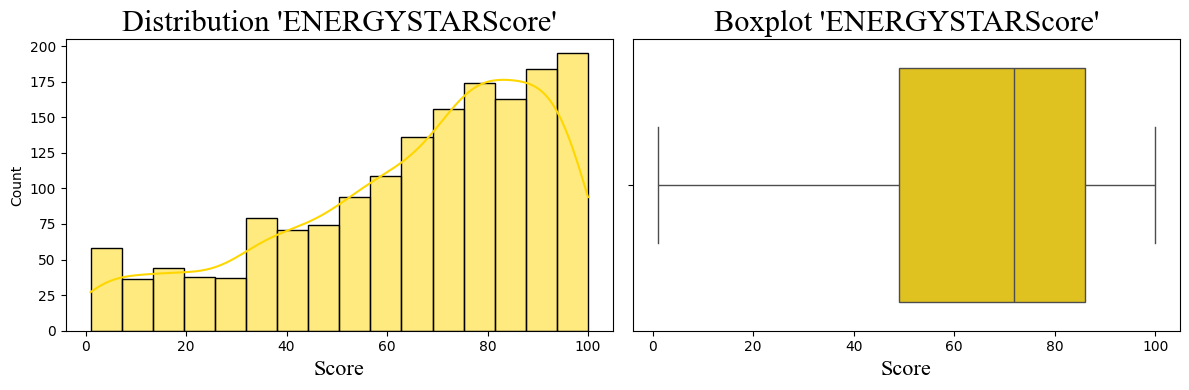

Q1  moyenne  médiane    Q3  ecart-type   CV  skewness  kurtosis
0  49.0     65.1     72.0  86.0        26.1  0.4     -0.75      -0.3

In [78]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN a été bien conservée suite à l'implémentation par KNN.

Vérifions les tailles des 2 dataframes (celui avec les NaN et celui avec les valeurs imputées)

In [79]:
# Affichage dataframe des données d'ENERGYSTARScore imputées
print(df_datas_imputed.shape)

# Affichage dataframe des données quantitatives avec les NaN
print(df_travail.shape)

(1648, 23)
(1648, 23)


Les 2 dataframes présentent bien le même nombre de ligne, donc nous allons pouvoir ajouter une nouvelle feature dans le dataframe avec les valeurs imputées.

In [80]:
# Déterminer contenu et position de la nouvelle colonne
nouvelle_col = df_datas_imputed['ENERGYSTARScore'] 
position = df_travail.columns.get_loc('ENERGYSTARScore') + 1  

# Insertion de la nouvelle colonne
df_travail.insert(position, 'ENERGYSTARScore_KNN', nouvelle_col)

#### Imputation par Iterative Imputer

Nous allons utiliser l'imputation par l'algorithme Iterative Imputer.

In [81]:
# Créez un objet d'imputation Iterative Imputer
imputer = IterativeImputer()

# Entraînez et applique le modèle Iterative Imputer
df_datas_imputed = pd.DataFrame(imputer.fit_transform(df_travail), columns=df_travail.columns)

Nous allons vérifier la distribution et les statitisques descriptives des colonnes après l'imputation.

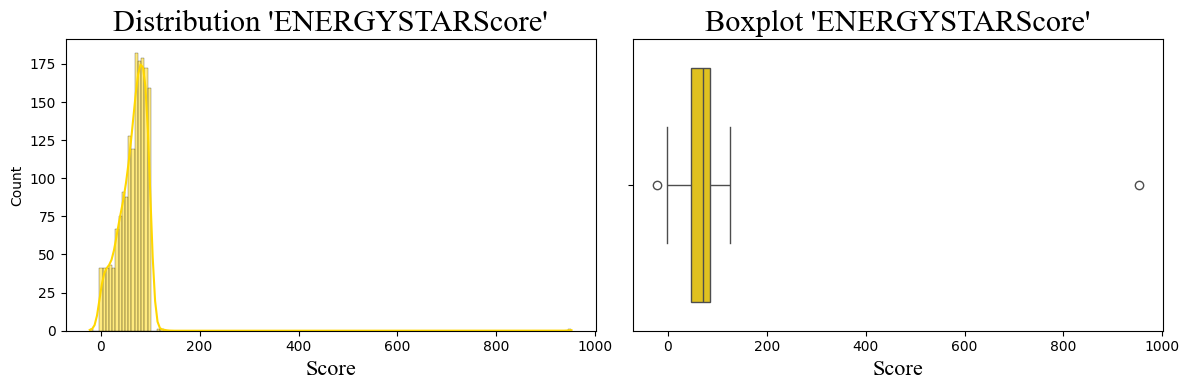

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  47.0     64.8     70.3  85.4        34.2  0.53      10.2     272.0

In [82]:
# Courbe
plot_distribution(df_datas_imputed, "ENERGYSTARScore", colors_list[0], unit="Score")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_datas_imputed, "ENERGYSTARScore")
display(df_stat)

La distribution des données d'ENERGYSTARScore qui présentaient des NaN n'a pas été bien conservée suite à l'implémentation par la méthode Iterative Imputer, notament avec la création d'outlier. 

**Nous ne retenons par la méthode d'imputation par la méthode Iterative Imputer car les résultats sont de mauvaise qualité.**

#### Vérification des taux de remplissage des features imputées

Nous vérifions les NaN restant dans le dataframe d'imputation.

In [83]:
# Tableau des valeurs manquantes
valeur_manquante_text_graph(df_travail, True, False)

Valeurs manquantes (Nan) : 565 / 39552 données (1.43 %)
1 / 24 colonne(s) sont concernés


Seul la feature "ENERGYSTARScore" présente toujours des NaN, ce qui est normal puisque nous avons créer une nouvelle feature avec les données imputées séparée. 

**Nous conservons cet feature avec des Nan pour pouvoir évaluer l'impact de l'imputation sur les corrélations.**

Nous avons imputé toutes les features quantitatives. Nous pouvons reintegrer ces features dans le dataframe des données nettoyées. 

In [84]:
# Copie de la dernière version du dataframe entier
df_data_clean = df_data_clean_usetype_nan.copy()

# Mise à jour des features quantitatives
df_data_clean[feat_quanti_list] = df_travail[feat_quanti_list]

# Insertion de la nouvelle feature des imputation KNN
nouvelle_col = df_travail['ENERGYSTARScore_KNN'] 
position = df_data_clean.columns.get_loc('ENERGYSTARScore') + 1  
df_data_clean.insert(position, 'ENERGYSTARScore_KNN', nouvelle_col)

## <span style='background:green'>10/ Bilan dataset nettoyé</span>

Le dataset est entièrement nettoyé de ses valeurs manquantes, à l'exception de la feature "ENERGYSTARScore", que nous conservons pour pouvoir évaluer l'impact de l'imputation KNN sur les corrélations.

Valeurs manquantes (Nan) : 565 / 51088 données (1.11 %)
1 / 31 colonne(s) sont concernés


1 / 31 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


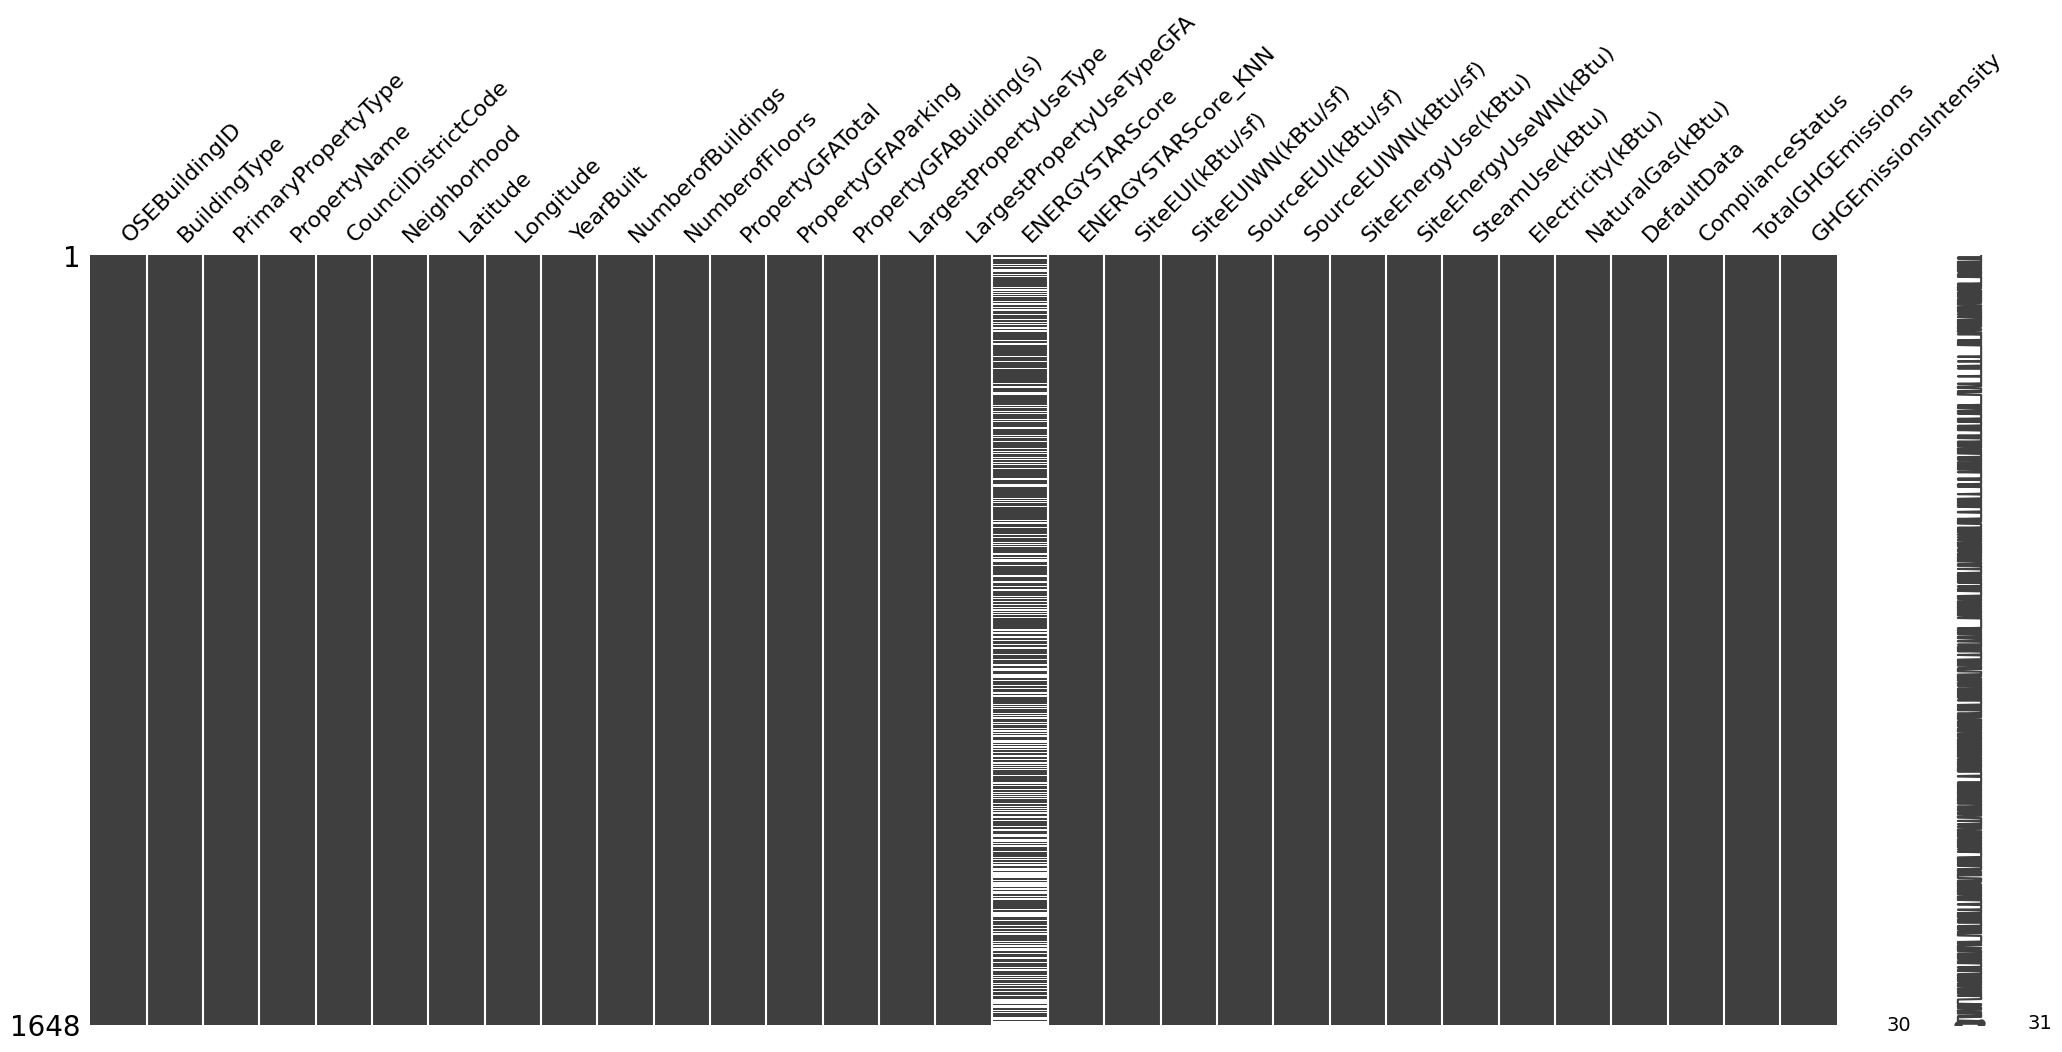

In [85]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean, True, True)

In [86]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean, "df_data_clean", "Nan par imputation", 3)

Voici l'aspect de 'df_data_clean' après nettoyage Nan par imputation


OSEBuildingID    BuildingType PrimaryPropertyType             PropertyName  \
0              1  NonResidential               Hotel     Mayflower park hotel   
1              2  NonResidential               Hotel          Paramount Hotel   
2              3  NonResidential               Hotel  5673-The Westin Seattle   

   CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                    7     DOWNTOWN  47.61220 -122.33799       1927   
1                    7     DOWNTOWN  47.61317 -122.33393       1996   
2                    7     DOWNTOWN  47.61393 -122.33810       1969   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
2                1.0              41            956110              196718   

   PropertyGFABuilding(s) LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                   88434                  Hotel                    88434.0   
1                   88502                  Hotel                    83880.0   
2                  759392                  Hotel                   756493.0   

   ENERGYSTARScore  ENERGYSTARScore_KNN  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
0             60.0                 60.0              81.7                84.3   
1             61.0                 61.0              94.8                97.9   
2             43.0                 43.0              96.0                97.7   

   SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
0           182.50000             189.00000            7226362.5   
1           176.10001             179.39999            8387933.0   
2           241.89999             244.10001           72587024.0   

   SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  \
0              7456910.0       2003882.0          3946027.0         1276453.0   
1              8664479.0             0.0          3242851.0         5145082.0   
2             73937112.0      21566554.0         49526664.0         1493800.0   

   DefaultData ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  
0        False        Compliant             249.98                   2.83  
1        False        Compliant             295.86                   2.86  
2        False        Compliant            2089.28                   2.19

1648 ligne(s) x 31 colonne(s)



# <span style='background:blue'>Etape 3 : Analyse exploratoire</span>
___

## <span style='background:green'>1/ Analyses univariées</span>

### Types de batiment

Nous observons la répartition des types de batiment dans le dataset. 

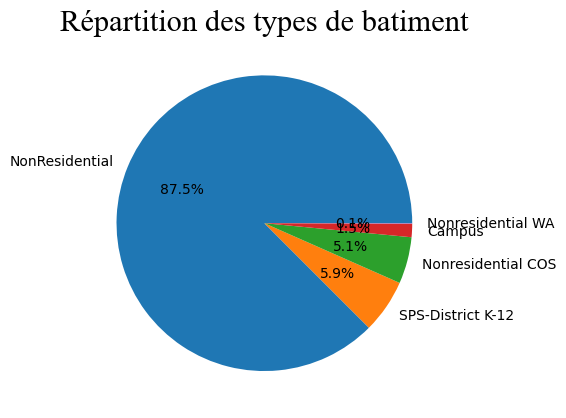

In [87]:
# Compte les ID de batiment par type de batiment (ordre décroissant)
repartition_type_batiment = df_data_clean.groupby(by='BuildingType')['OSEBuildingID'].nunique().sort_values(ascending=False)

# Convert index to list of strings
labels = repartition_type_batiment.index.tolist()

# Diagramme camembert 
plt.pie(repartition_type_batiment, labels=labels, 
    autopct='%1.1f%%') 

# Ajout du titre et légende
plt.title("Répartition des types de batiment", fontdict=font_title)
plt.show()

Le type de batiment le plus représenté est le 'NonResidential' avec 87,5% des batiments.

### Types d'usage

Nous allons explorer la répartition des 10 premiers types d'usage dans 'LargestPropertyUseType'. 

C:\Users\pierr\AppData\Local\Temp\ipykernel_12060\1400072297.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_counts.index, rotation=45, ha='right')


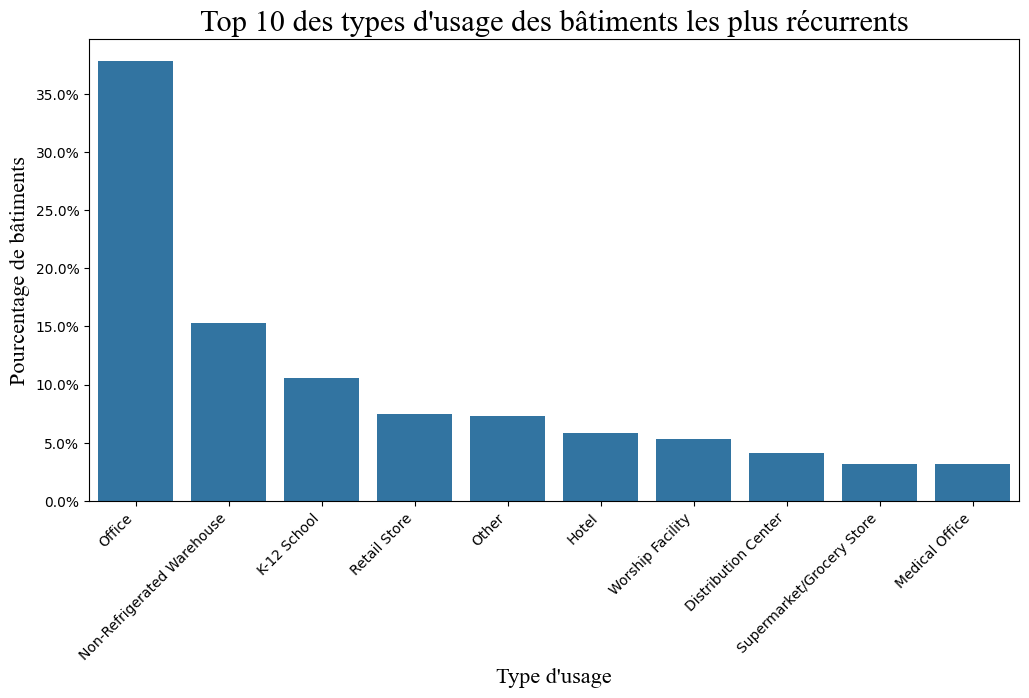

In [88]:
# Compter les occurrences par type d'usage dans feature 'LargestPropertyUseType'
counts = df_data_clean['LargestPropertyUseType'].value_counts()

# Nombre des premières valeurs à afficher
top_nombre = 10
top_counts = counts.head(10)

# Calculez le pourcentage par rapport au total
total = top_counts.sum()
pourcentages = (top_counts / total) * 100

# Créer un barplot avec Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_counts.index, y=pourcentages)

# Ajout du titre du graphique, des axes X et Y
plt.title("Top {} des types d'usage des bâtiments les plus récurrents".format(top_nombre), fontdict=font_title)
plt.xlabel("Type d'usage", fontdict=font_axe)
plt.ylabel("Pourcentage de bâtiments", fontdict=font_axe)
ax.set_xticklabels(top_counts.index, rotation=45, ha='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Les bureaux sont les types d'usage les plus récurrents dans le dataset. Ils représentent plus d'un tiers des types d'usage.

Plus de la moitié des types d'usage sont soit des bureaux, soit des entrepôts non-réfrigérés.

### Features cibles :  émissions de CO2 et la consommation totale d’énergie

Nous devons prédire les émissions de CO2 et la consommation totale d’énergie. Pour cela nous identifions les 2 features cibles dans le dataset: 
- Emission de CO2 : **'TotalGHGEmissions'** exprimé en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e)
<br><br>
- Consommation totale d’énergie : **'SiteEnergyUse(kBtu)'** exprimé en kBtu (unité thermique britannique)

#### TotalGHGEmissions

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale. Pour cela, nous devons émettre les 2 hypothèses de ce test :

**Hypothèse nulle (H0) : la population est distribuée normalement selon la loi gaussienne.**

Hypothèse alternative (HA) : la population n'est pas distribuée normalement selon la loi gaussienne.

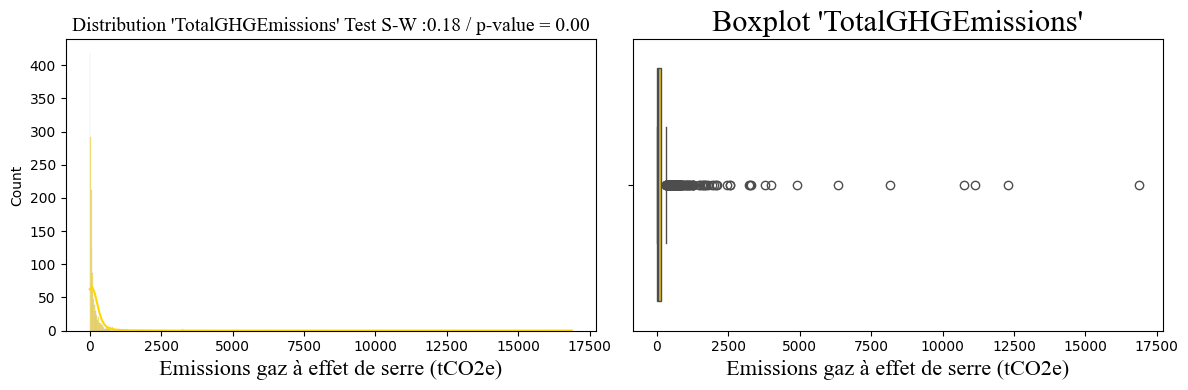

Q1  moyenne  médiane     Q3  ecart-type    CV  skewness  kurtosis
0  20.5    186.5     49.9  143.6       755.6  4.05     14.14     244.6

In [89]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Histogramme
plot_distribution(df_data_clean, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Emissions gaz à effet de serre (tCO2e)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, les relevés officiels de l'Agence de protection de l'environnement des États-Unis (Environmental Protection Agency, EPA) affichent une quantité d'émissions de gaz à effet de serre de l'ordre de 87_000 tCO2e pour le seul campus de l'université de Washington basée à Seattle en 2016. Notre plus grande valeur se situe aux alentours de 17_500 tCO2e soit environ 5 fois moins d'émission.<br><br>
**Toutes nos données d'émission de CO2 sont donc probables.** 

**Source:**<br>
[GHGEmissions of University of Washington Seattle Campus university in 2016 by EPA](https://ghgdata.epa.gov/ghgp/service/facilityDetail/2016?id=1002682&ds=E&et=&popup=true)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique en prenant soin d'utiliser la méthode Log(1+x) pour éviter la valeur infini pour les valeurs nulles (=0).

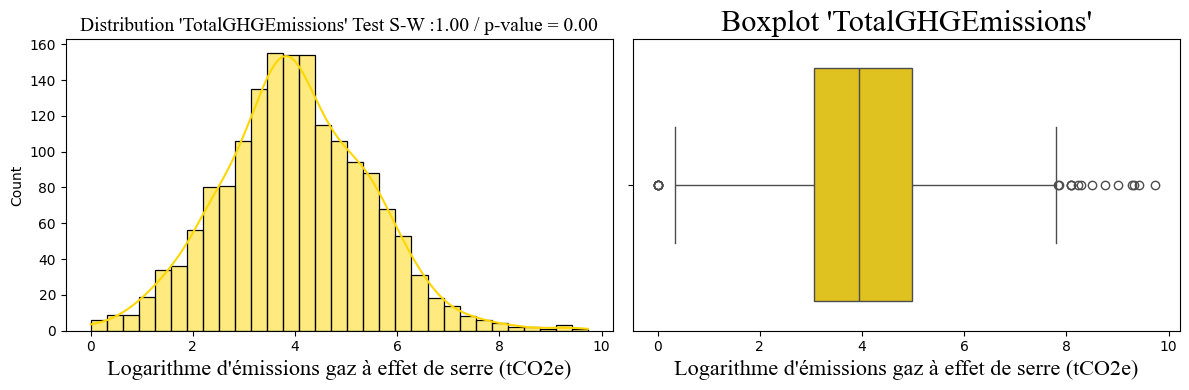

In [90]:
# Copie du dataframe
df_data_log = df_data_clean.copy()

# Transformation logarithmique (log(1+x))
df_data_log[feature_analyzed] = np.log1p(df_data_clean[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont malgré tout pas distribuées normalement.**

#### SiteEnergyUse(kBtu)

Nous appliquons le **test Shapiro-Wilk** pour vérifier si la distribution est normale.

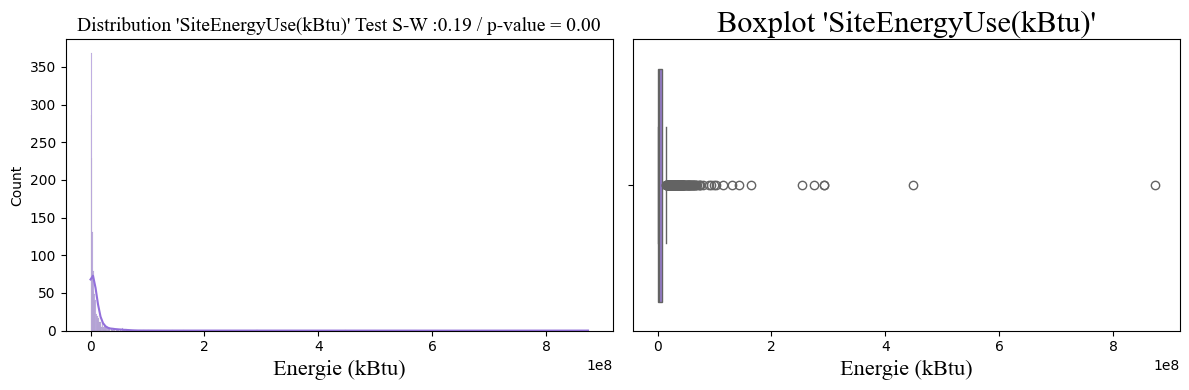

Q1    moyenne    médiane         Q3  ecart-type    CV  skewness  \
0  1251083.4  8476726.3  2582214.4  6928335.0  30375344.3  3.58     17.99   

   kurtosis  
0     441.6

In [91]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Histogramme
plot_distribution(df_data_clean, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_clean, feature_analyzed)
display(df_stat)

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont pas distribuées normalement.**

Nous remarquons qu'il y a des outliers qui sont très éloignées de la moyenne et la médiane. Pour autant, ces valeurs semblent atypiques mais pas aberrantes. En effet, le rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013 affichait une quantité de consommation d'énergie de 15,7 milliards de kBtu pour toute la ville. Si nous considérons les types d'usage des batiments, ceux qui consommaient le plus d'énergie étaient les bureaux avec 3,4 milliard de kBtu pour les 431 bureaux de la ville. Notre plus grande valeur se situe aux alentours de 800 millions kBtu. La probabilité qu'un seul batiment puisse être un gros contributeur de cette consommation n'est pas nulle. <br><br>
**Toutes nos données de consommation d'énergie sont donc probables.** 

**Source:**<br>
[Rapport d'analyse des consommations énergétiques des batiments de la ville de Seattle de 2013](https://www.seattle.gov/documents/departments/ose/ebr-2013-report.pdf)

Nous allons donc conserver ces outliers pour la suite des traitements et nous transformons la distribution de cet feature cible en appliquant une transformation logarithmique en prenant soin d'utiliser la méthode Log(1+x) pour éviter la valeur infini pour les valeurs nulles (=0).

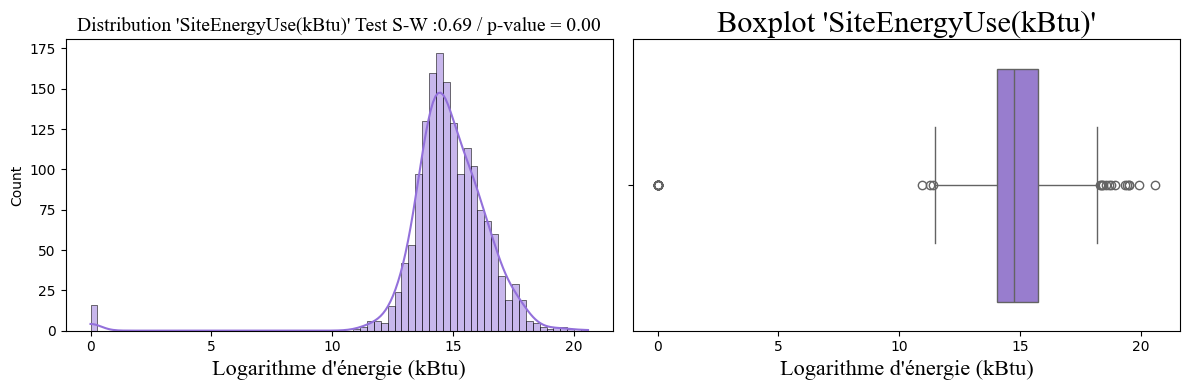

In [92]:
# Transformation logarithmique (log(1+x))
df_data_log[feature_analyzed] = np.log1p(df_data_clean[feature_analyzed])

# Histogramme
plot_distribution(df_data_log, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Logarithme d'énergie (kBtu)")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Les données de cet feature cible ne sont malgré tout pas distribuées normalement.**

### Ancienneté des batiments

Nous calculons l'ancienneté des batiments en soustrayant l'année de mesure (2016) par l'année de construction.

Tout d'abord, nous observons la distribution des années de construction des batiments dans le dataset.

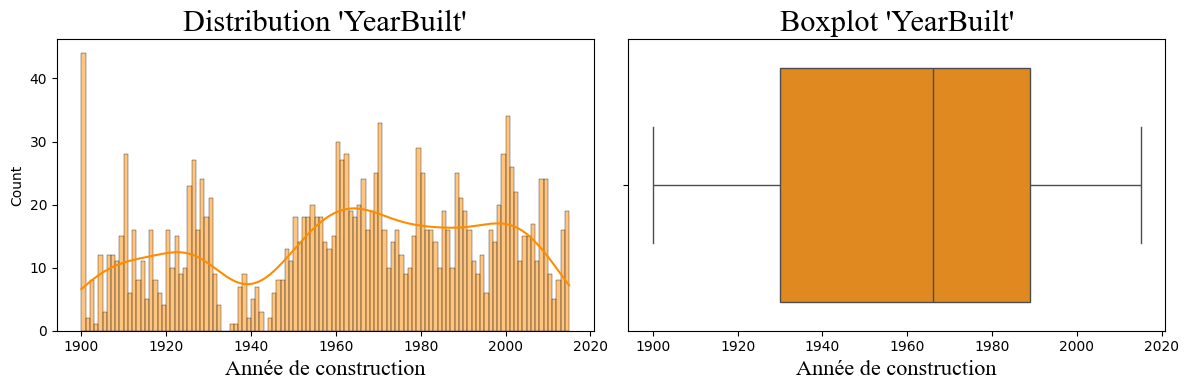

In [93]:
# Histogramme
plot_distribution(df_data_clean, "YearBuilt", colors_list[2], binwidth=1, unit="Année de construction")

Aucun outlier n'est constaté. Nous utilisons ces données pour créer une nouvelle feature qui indique l'ancienneté des batiments.

In [94]:
df_data_log["AncienneteBatiment"] = 2016 - df_data_log["YearBuilt"]

Nous observons la distribution de cette nouvelle feature (directement corrélée à celle des années de construction).

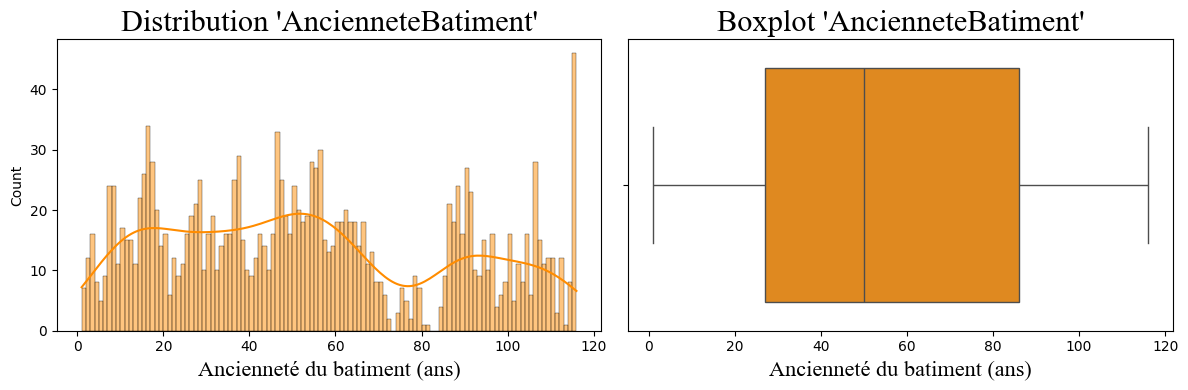

Q1  moyenne  médiane    Q3  ecart-type    CV  skewness  kurtosis
0  27.0     53.8     50.0  86.0        32.6  0.61       0.3      -1.0

In [95]:
# Histogramme
plot_distribution(df_data_log, "AncienneteBatiment", colors_list[2], binwidth=1, unit="Ancienneté du batiment (ans)")

# Calcul des stats descriptives
df_stat = stats_descriptives(df_data_log, "AncienneteBatiment")
display(df_stat)

Résumé de la distribution de l'ancienneté des batiments : 

- **Aspect** : distribution **trimodale** => 3 zones de fortes concentrations (autour de 16, 50 et 90 ans).
  
- **Tendance centrale** : La **moyenne** et la **médiane** sont proches de 50-55 ans.
  
- **Dispersion** : les données forment un groupe hétérogène (CV > 15%).
  
- **Forme** : les données sont étalées à droite (skewness>0) et les observations sont plus aplaties que la loi normale (kurtosis<0).

Nous supprimons la feature des années de construction des batiments car elle est redondante avec la feature de l'ancienneté des batiments.

In [96]:
# Suppression d'une feature dont nous n'avons plus besoin
df_data_log = df_data_log.drop(columns=["YearBuilt"])


## <span style='background:green'>2/ Analyses bivariées</span>

### Matrice de corrélation

Nous affichons une matrice de corrélation de toutes les variables quantitatives de notre dataset pour pouvoir détecter les corrélations linéaires les plus visibles grâce aux coefficients de corrélation de Pearson. 

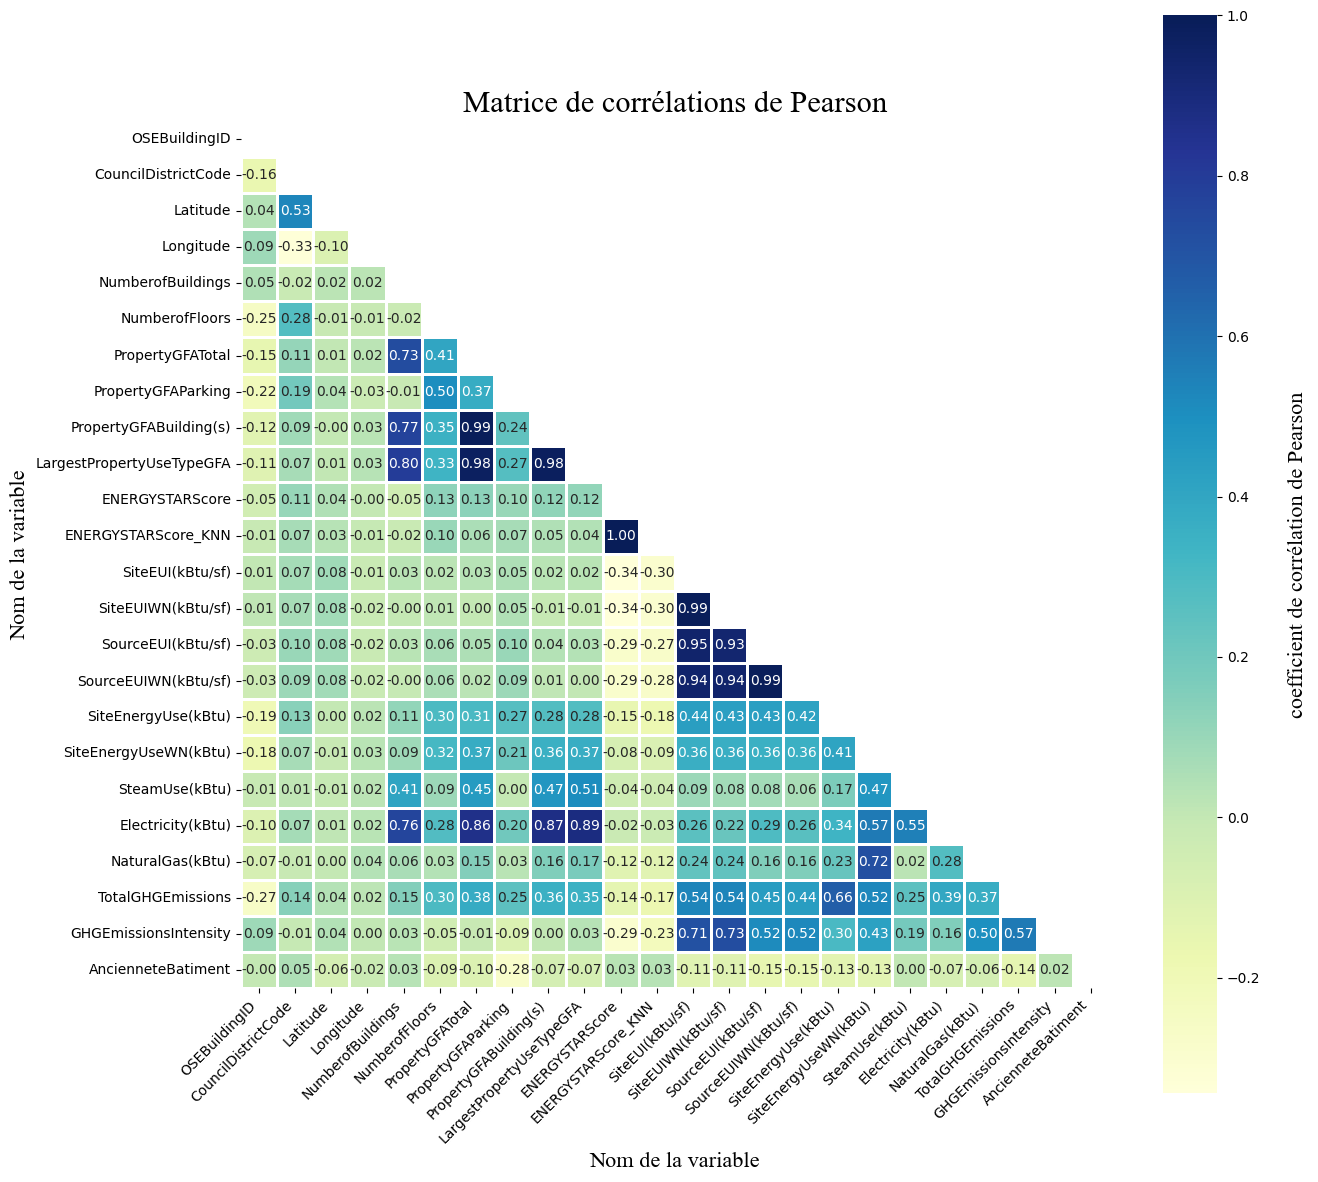

In [97]:
# Comptage du nombre de feature quantitatives
feat_quanti_list = df_data_log.select_dtypes(include=['int', 'float']).columns

# Matrice des corrélations
corr_mat = df_data_log[feat_quanti_list].corr()

# Créer un masque pour masquer les valeurs au-dessus de la diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(14,14))
heatmap = sns.heatmap(corr_mat, square=True, linewidths=1, annot=True, fmt=".2f", cmap='YlGnBu', mask=mask, ax=ax)

# Ajout du titre du graphique, des axes et de la colorbar
plt.title("Matrice de corrélations de Pearson", fontdict=font_title)
plt.xlabel("Nom de la variable", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
plt.xticks(rotation=45, ha='right')
cbar = heatmap.collections[0].colorbar
cbar.set_label('coefficient de corrélation de Pearson', labelpad=20, fontdict=font_axe)  
plt.show()

Les features cibles ne présentent pas de forte corrélation avec la feature d'ENERGYSTARScore : 
- SiteEnergyUse(kBtu) / ENERGYSTARScore => R = -0,15    (R = -0,18 avec imputation KNN)
- TotalGHGEmissions / ENERGYSTARScore => R = -0,14      (R = -0,17 avec imputation KNN)

**Les features cibles ne sont pas corrélées à la valeur de l'ENERGYSTARScore. Cette dernière ne devrait pas être importante pour le modèle.**

Nous supprimons les features qui présentent des corrélations linéaires fortes (R > 0,50) entre elles pour améliorer la performance du modèle de machine learning, en particulier :
- Augmenter la vitesse d'apprentissage
- Augmenter la l'interpretabilité du modèle
- Augmenter la stabilité du modèle
- Réduire le fléau de la dimension  

In [98]:
# Seuil de corrélation
seuil_corr = 0.50

# Matrice des corrélations mise à jour
corr_mat = df_data_log[feat_quanti_list].corr()

Si nous nous concentrons sur la feature cible "SiteEnergyUse(kBtu)" :

In [99]:
# Feature cible
target = "SiteEnergyUse(kBtu)"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

Feature cible   Feature associée  Corrélation
0  SiteEnergyUse(kBtu)  TotalGHGEmissions      0.66159

Cette feature cible présente une corrélation qu'avec l'autre feature cible "TotalGHGEmissions" (R = 0,66). 

Nous affichons l'analyse bivariée de ces 2 features cibles (avec outliers) pour visualiser la corrélation, ainsi que la régression linéaire pour visualiser la tendance.

Pour savoir si ces 2 features sont réellement corrélées ou pas, nous devons poser les hypothèses du test de corrélation de Spearman :

**Hypothèse nulle (H0) : Pas de corrélation entre les 2 variables.**

Hypothèse alternative (HA) : Corrélation entre les 2 variables.

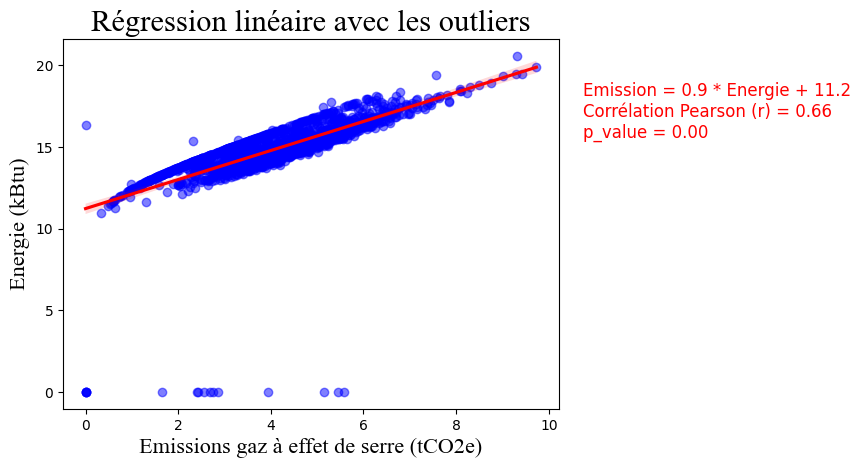

In [100]:
# Regression linéaire
regression_lineaire_emission_energie(df_data_log, "TotalGHGEmissions", "SiteEnergyUse(kBtu)", "Emission", "Energie", outliers_statut="avec")

La p-value < 0.05, nous rejetons l'hypothèse nulle. 

**Il existe une corrélation positive entre les émissions de gaz à effet de serre et la quantité annuelle d'énergie consommée  (R=0.66)**

Si nous nous concentrons sur la feature cible "TotalGHGEmissions" :

In [101]:
# Feature cible
target = "TotalGHGEmissions"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

Feature cible       Feature associée  Corrélation
0  TotalGHGEmissions       SiteEUI(kBtu/sf)      0.53632
1  TotalGHGEmissions     SiteEUIWN(kBtu/sf)      0.53655
2  TotalGHGEmissions    SiteEnergyUse(kBtu)      0.66159
3  TotalGHGEmissions  SiteEnergyUseWN(kBtu)      0.52493
4  TotalGHGEmissions  GHGEmissionsIntensity      0.57206

Nous remarquons que les 2 features cibles "SiteEnergyUse(kBtu)" et "TotalGHGEmissions" sont fortement corrélées entre elles (R = 0,66). 

Nous constatons que **"TotalGHGEmissions"** est corrélée à :
  - "SiteEUI(kBtu/sf)	" (R = 0,54)
  - "SiteEUIWN(kBtu/sf)" (R = 0,54)
  - "SiteEnergyUseWN(kBtu)" (R = 0,52)
  - "GHGEmissionsIntensity" (R = 0,57) **=> meilleure corrélation**

**Ainsi nous regroupons les features "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)" et "SiteEnergyUseWN(kBtu)" dans une liste des features à supprimer.**

Maintenant que nous connaissons la feature corrélée que nous devons conserver pour sa forte corrélation avec une feature cible, à savoir:
- "GHGEmissionsIntensity"
  
Nous allons supprimer les features qui présentent des corrélations linéaires fortes avec cette dernière pour améliorer la stabilité des modèles de machine learning qui seront réalisés par la suite. 

In [102]:
# Feature corrélée à la cible
feat_correle = "GHGEmissionsIntensity"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=feat_correle, seuil=seuil_corr)

Feature cible      Feature associée  Corrélation
0  GHGEmissionsIntensity      SiteEUI(kBtu/sf)      0.71405
1  GHGEmissionsIntensity    SiteEUIWN(kBtu/sf)      0.72807
2  GHGEmissionsIntensity    SourceEUI(kBtu/sf)      0.51622
3  GHGEmissionsIntensity  SourceEUIWN(kBtu/sf)      0.52301
4  GHGEmissionsIntensity     TotalGHGEmissions      0.57206

Nous constatons que **"GHGEmissionsIntensity"** est corrélée à :
  - "SiteEUI(kBtu/sf)	" (R = 0,71)
  - "SiteEUIWN(kBtu/sf)" (R = 0,73)
  - "SourceEUI(kBtu/sf)" (R = 0,52)
  - "SourceEUIWN(kBtu/sf)" (R = 0,52)
  - "TotalGHGEmissions" (R = 0,57) **=> feature cible**

**Ainsi nous ajoutons les features "SourceEUI(kBtu/sf)" et "SourceEUIWN(kBtu/sf)" à la liste des features à supprimer.**

Nous remarquons qu'il reste encore des corrélations supérieurs à notre seuil. Focalisons nous sur la feature "LargestPropertyUseTypeGFA": 

In [103]:
# Feature cible
target = "LargestPropertyUseTypeGFA"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

Feature cible        Feature associée  Corrélation
0  LargestPropertyUseTypeGFA       NumberofBuildings      0.79697
1  LargestPropertyUseTypeGFA        PropertyGFATotal      0.97766
2  LargestPropertyUseTypeGFA  PropertyGFABuilding(s)      0.98225
3  LargestPropertyUseTypeGFA          SteamUse(kBtu)      0.50783
4  LargestPropertyUseTypeGFA       Electricity(kBtu)      0.88520

Ainsi, nous constatons que :

- **"LargestPropertyUseTypeGFA"** est corrélé à :
  - "NumberofBuildings" (R = 0,80)
  - "PropertyGFATotal" (R = 0,98)
  - "PropertyGFABuilding" (R = 0,98)
  - "SteamUse(kBtu)" (R = 0,51)
  - "Electricity(kBtu)" (R = 0,89)

**Ainsi nous ajoutons les features "NumberofBuildings", "PropertyGFATotal", "PropertyGFABuilding(s)", "SteamUse(kBtu)" à la liste des features à supprimer.**

Focalisons nous sur la feature "Latitude": 

In [104]:
# Feature cible
target = "Latitude"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

Feature cible     Feature associée  Corrélation
0      Latitude  CouncilDistrictCode      0.52825

Ainsi, nous constatons que :

- **"Latitude"** est corrélé à :
  - "CouncilDistrictCode" (R = 0,53)

**Ainsi nous ajoutons les features "CouncilDistrictCode" à la liste des features à supprimer.**

Focalisons nous sur la feature "PropertyGFAParking": 

In [105]:
# Feature cible
target = "PropertyGFAParking"

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, target_feature=target, seuil=seuil_corr)

Feature cible Feature associée  Corrélation
0  PropertyGFAParking   NumberofFloors      0.50321

Ainsi, nous constatons que :

- **"PropertyGFAParking"** est corrélé à :
  - "NumberofFloors" (R = 0,50)

Ainsi nous ajoutons les features "NumberofFloors" à la liste des features à supprimer.

Nous supprimons toutes les features qui présentent des corrélations linéaires fortes 

In [106]:
# Liste des features corrélées
corr_feat_list = ["SiteEUI(kBtu/sf)",
                "SiteEUIWN(kBtu/sf)",
                "SiteEnergyUseWN(kBtu)",
                "SourceEUI(kBtu/sf)",
                "SourceEUIWN(kBtu/sf)",
                "NumberofBuildings",
                "PropertyGFATotal",
                "PropertyGFABuilding(s)",
                "SteamUse(kBtu)",
                "Electricity(kBtu)",
                "CouncilDistrictCode",
                "NumberofFloors"]

# Suppression des features corrélées
df_data_clean_corr = df_data_log.drop(columns=corr_feat_list)

Nous vérifions que les dernières corrélations restantes sont celles en lien avec les features cibles.

In [107]:
# Détection des features quantitatives
feat_quanti_list = df_data_clean_corr.select_dtypes(include=['int', 'float']).columns

# Affichage
display("Il reste {} features quantitatives.".format(len(feat_quanti_list)))
display(feat_quanti_list)

# Matrice des corrélations mise à jour
corr_mat = df_data_clean_corr[feat_quanti_list].corr()

# Détection des corrélations supérieures au seuil
detecteur_correlation_sup_target(corr_mat, seuil=seuil_corr)

'Il reste 12 features quantitatives.'

Index(['OSEBuildingID', 'Latitude', 'Longitude', 'PropertyGFAParking',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'ENERGYSTARScore_KNN',
       'SiteEnergyUse(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'AncienneteBatiment'],
      dtype='object')

Feature cible       Feature associée  Corrélation
0      ENERGYSTARScore    ENERGYSTARScore_KNN      1.00000
1  SiteEnergyUse(kBtu)      TotalGHGEmissions      0.66159
2    TotalGHGEmissions  GHGEmissionsIntensity      0.57206

Il s'agit bien des corrélation avec les features cibles. Nous trouvons également les 2 features de l'ENERGYSTARScore qui sont directement corrélées entre elles. 
Nous pouvons donc conserver ces features pour la suite des traitements.

In [108]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(df_data_clean_corr, "df_data_clean_corr", "des features colinéaires", 3)

Voici l'aspect de 'df_data_clean_corr' après nettoyage des features colinéaires


OSEBuildingID    BuildingType PrimaryPropertyType             PropertyName  \
0              1  NonResidential               Hotel     Mayflower park hotel   
1              2  NonResidential               Hotel          Paramount Hotel   
2              3  NonResidential               Hotel  5673-The Westin Seattle   

  Neighborhood  Latitude  Longitude  PropertyGFAParking  \
0     DOWNTOWN  47.61220 -122.33799                   0   
1     DOWNTOWN  47.61317 -122.33393               15064   
2     DOWNTOWN  47.61393 -122.33810              196718   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                  Hotel                    88434.0             60.0   
1                  Hotel                    83880.0             61.0   
2                  Hotel                   756493.0             43.0   

   ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  DefaultData  \
0                 60.0             15.79325         1276453.0        False   
1                 61.0             15.94230         5145082.0        False   
2                 43.0             18.10030         1493800.0        False   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  \
0        Compliant            5.52537                   2.83   
1        Compliant            5.69326                   2.86   
2        Compliant            7.64505                   2.19   

   AncienneteBatiment  
0                  89  
1                  20  
2                  47

1648 ligne(s) x 19 colonne(s)



Valeurs manquantes (Nan) : 565 / 31312 données (1.8 %)
1 / 19 colonne(s) sont concernés


1 / 19 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


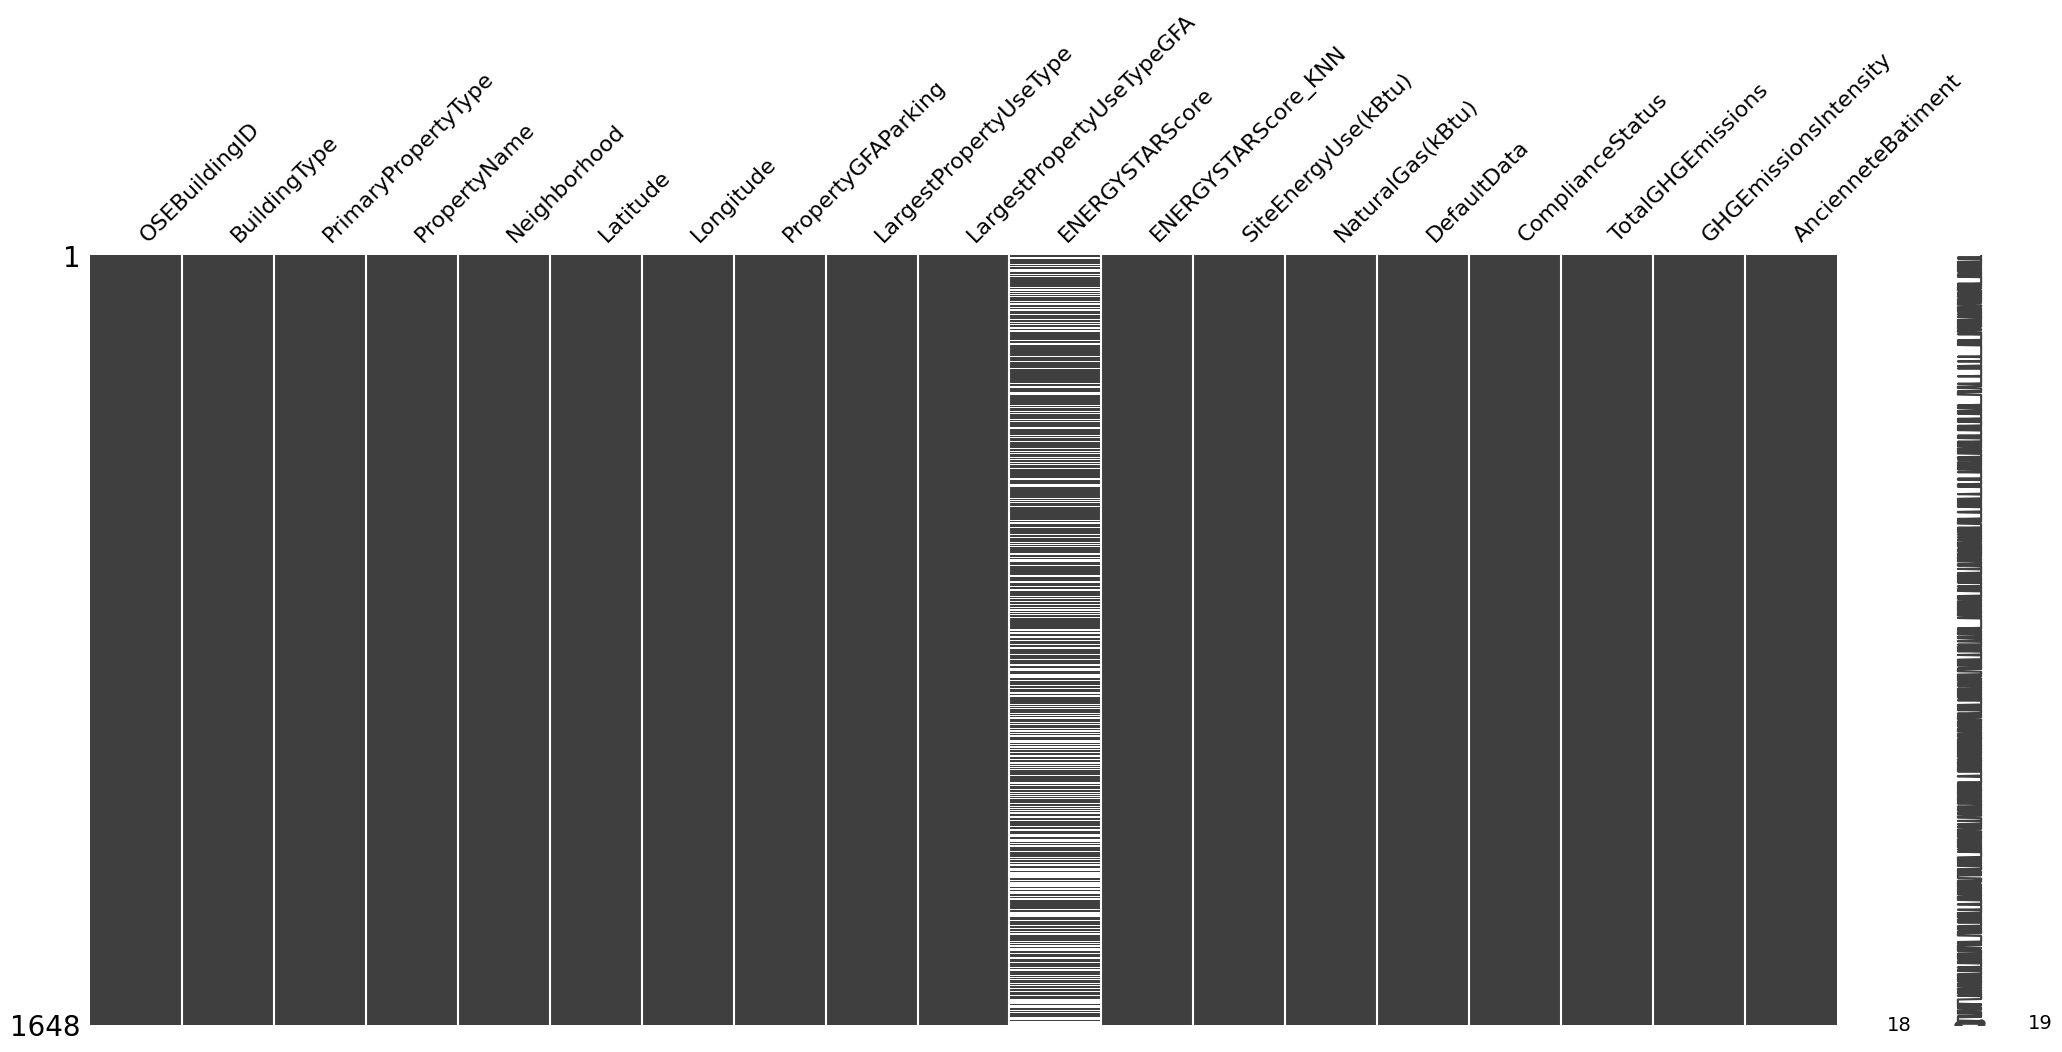

In [109]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_data_clean_corr, True, True)

La feature ENERGYSTARScore présente des valeurs manquantes mais cela est normal puisque nous avons créé une nouvelle feature avec les valeurs imputées. Nous gardons les 2 features. 

### Suppression des outliers des features cibles (valeur atypiques)

Pour réaliser l'ACP, nous devons créer un autre dataframe en reintégrant les valeurs des features cibles avant leur transformation logarithmique. 

In [110]:
# Copie du dataframe avec les log
df_acp = df_data_clean_corr.copy()

# Remplacer des 2 features cibles avec les valeurs originales (avant log)
df_acp['TotalGHGEmissions'] = df_data_clean['TotalGHGEmissions']
df_acp['SiteEnergyUse(kBtu)'] = df_data_clean['SiteEnergyUse(kBtu)']

#### TotalGHGEmissions

Nous affichons la distribution de la feature "TotalGHGEmissions" pour le dataframe initial et celui avec les valeurs transformées avec le log.

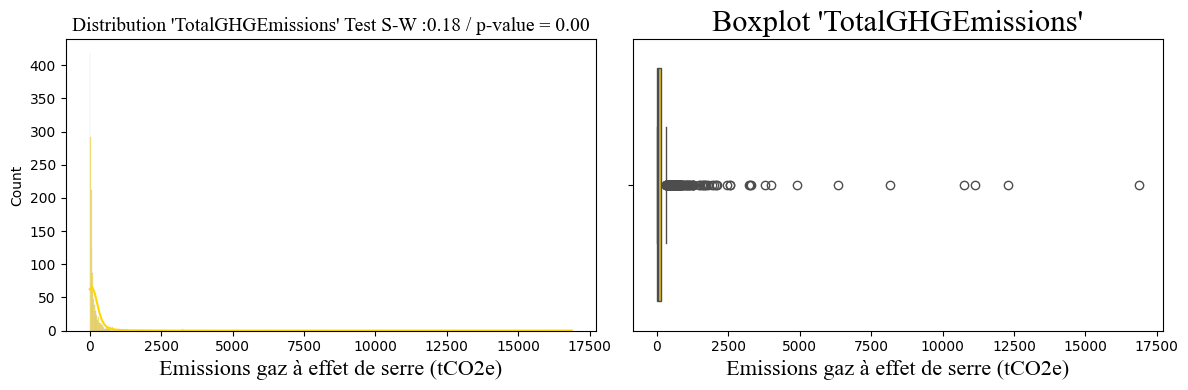

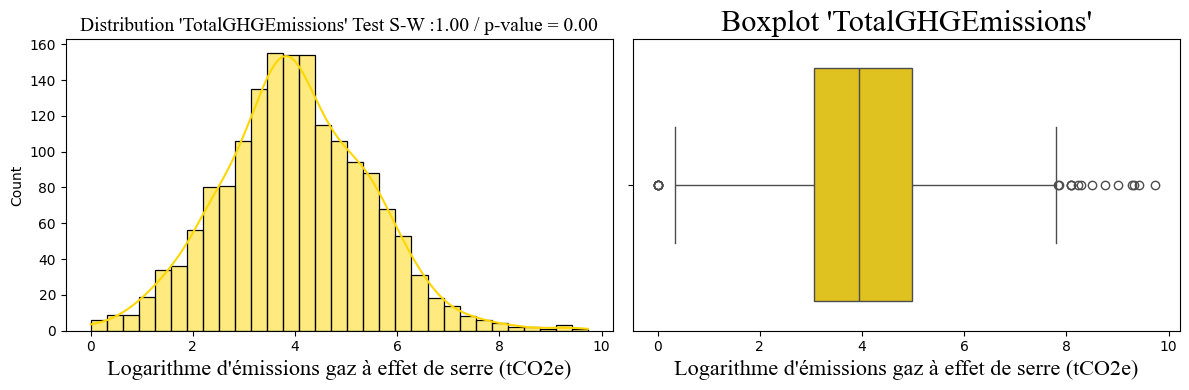

In [111]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Sans Log
plot_distribution(df_acp, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Emissions gaz à effet de serre (tCO2e)")

# Avec Log
plot_distribution(df_data_clean_corr, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

#### SiteEnergyUse(kBtu)

Nous affichons la distribution de la feature "SiteEnergyUse(kBtu)" pour le dataframe initial et celui avec les valeurs transformées avec le log.

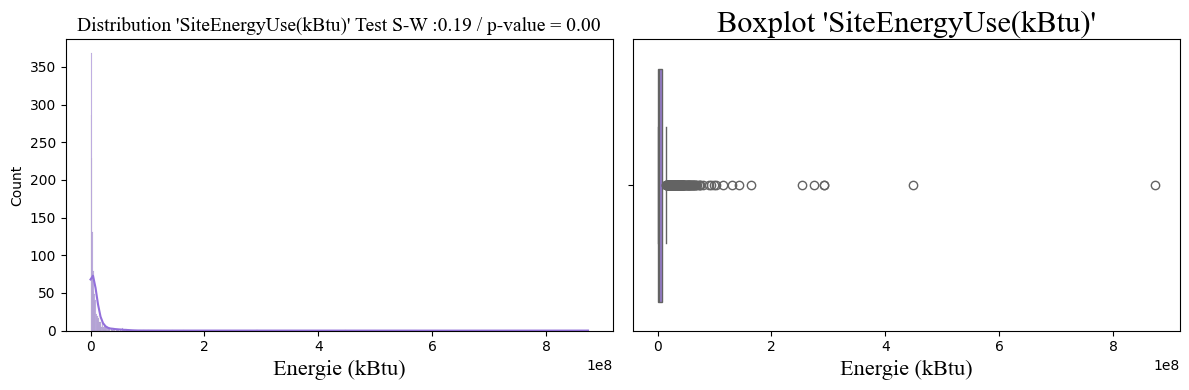

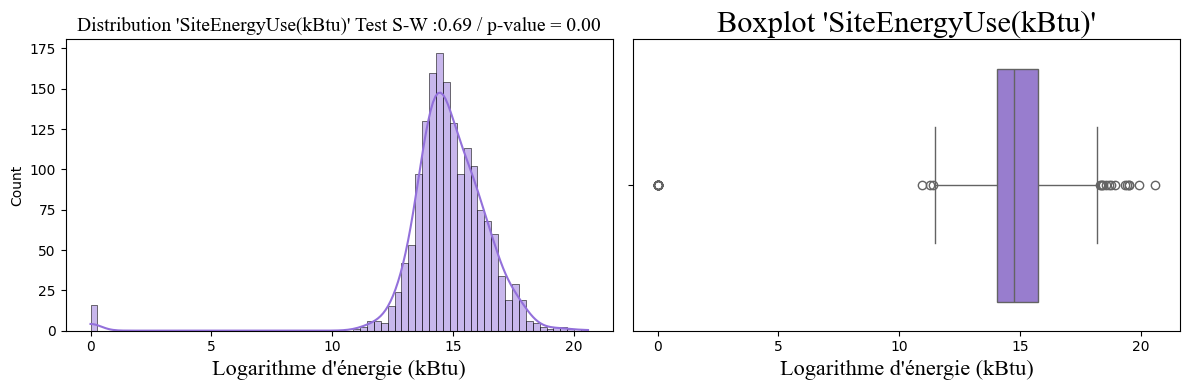

In [112]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Sans Log
plot_distribution(df_acp, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

# Avec Log
plot_distribution(df_data_clean_corr, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Logarithme d'énergie (kBtu)")

#### Suppression des outliers

Avec la méthode interquartile (IQR) :

In [113]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Suppression outliers par la méthode interquartile
df_acp_clean_ghge = supprimer_outliers_iqr(df_acp, feature_analyzed)

df_data_clean_ghge = supprimer_outliers_iqr(df_data_clean_corr, feature_analyzed)

In [114]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Suppression outliers par la méthode interquartile
df_acp_clean_outlier = supprimer_outliers_iqr(df_acp_clean_ghge, feature_analyzed)

df_data_clean_outlier = supprimer_outliers_iqr(df_data_clean_ghge, feature_analyzed)

#### TotalGHGEmissions

Nous affichons les distributions de la feature "TotalGHGEmissions" après la suppression des outliers par la méthode interquartile (IQR).

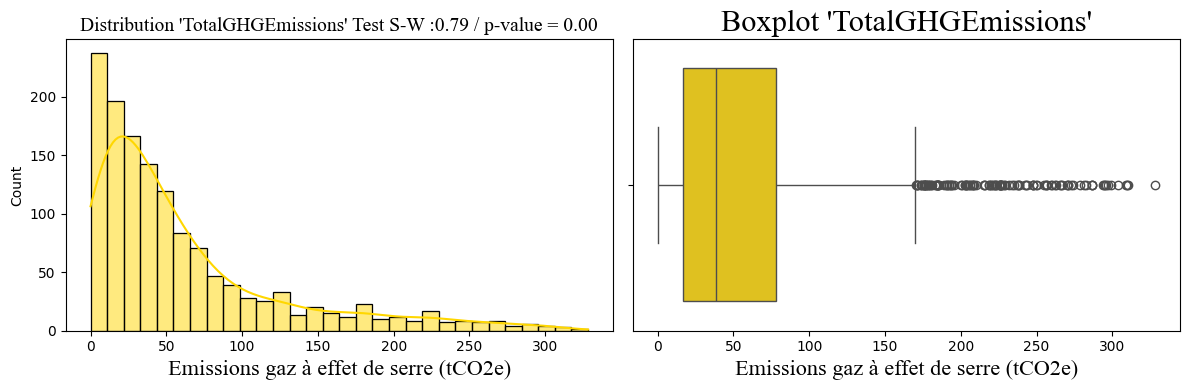

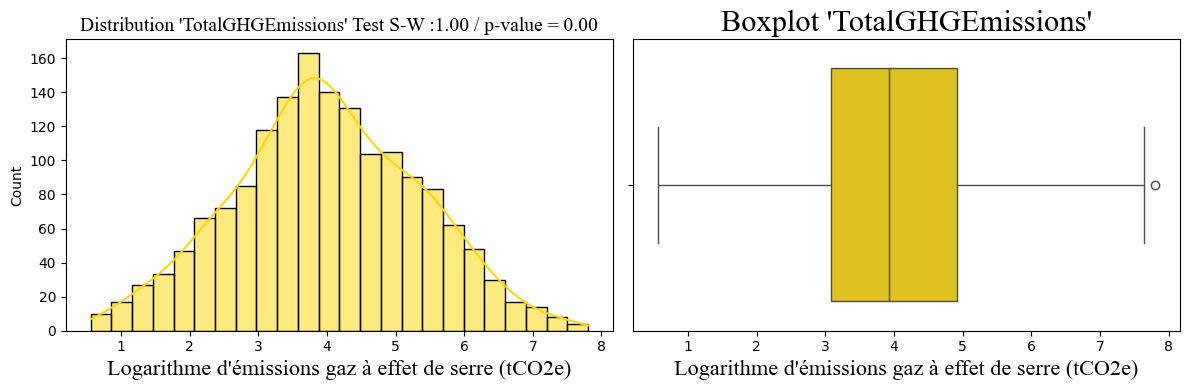

In [115]:
# Feature analysée
feature_analyzed = "TotalGHGEmissions"

# Sans Log
plot_distribution(df_acp_clean_outlier, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Emissions gaz à effet de serre (tCO2e)")

# Avec Log
plot_distribution(df_data_clean_outlier, feature_analyzed, colors_list[0], shapiro_wilk=True, unit="Logarithme d'émissions gaz à effet de serre (tCO2e)")

#### SiteEnergyUse(kBtu)

Nous affichons les distributions de la feature "SiteEnergyUse(kBtu)" après la suppression des outliers par la méthode interquartile (IQR).

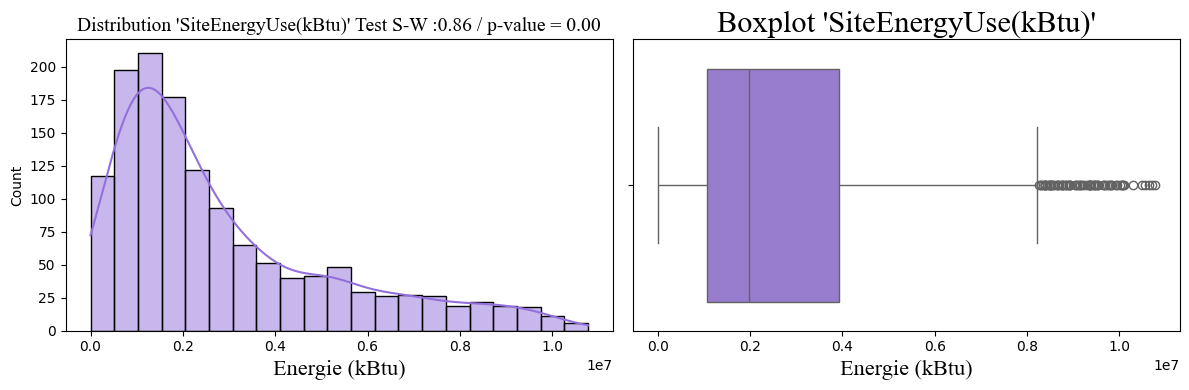

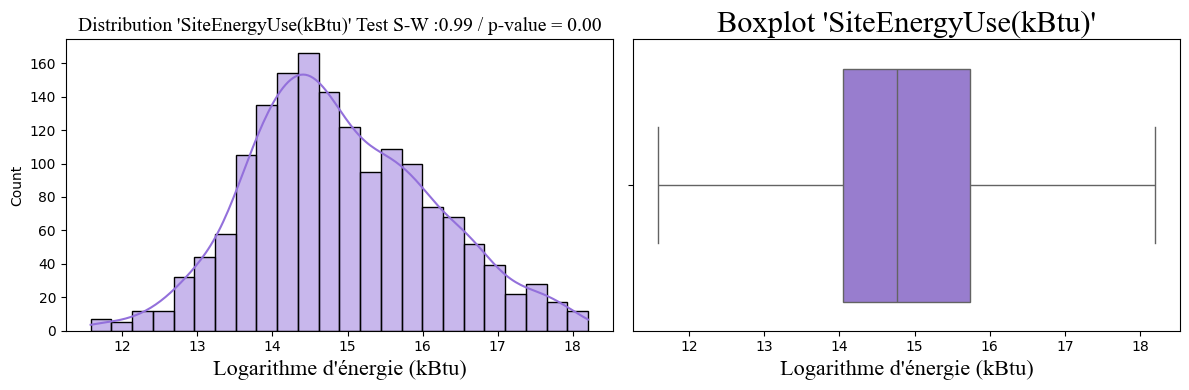

In [116]:
# Feature analysée
feature_analyzed = "SiteEnergyUse(kBtu)"

# Sans Log
plot_distribution(df_acp_clean_outlier, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

# Avec Log
plot_distribution(df_data_clean_outlier, feature_analyzed, colors_list[1], shapiro_wilk=True, unit="Logarithme d'énergie (kBtu)")

**Tous les outliers ont été supprimés pour les 2 dataframes (données initiales et données transformées avec le logarithme).**

Nous affichons l'analyse bivariée de ces 2 features (sans outliers) pour visualiser la corrélation, ainsi que la régression linéaire pour visualiser la tendance.

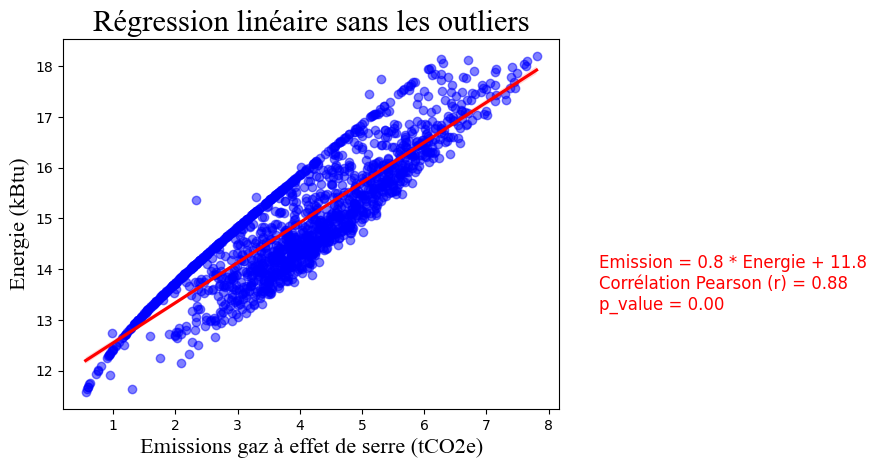

In [117]:
# Regression linéaire
regression_lineaire_emission_energie(df_data_clean_outlier, "TotalGHGEmissions", "SiteEnergyUse(kBtu)", "Emission", "Energie", outliers_statut="sans")

La corrélation entre les 2 features cibles est encore plus forte (R = 0,88).

In [118]:
# Aperçu dataframe nettoyé (données initiales)
affiche_aperçu_df(df_acp_clean_outlier, "df_acp_clean_outlier", "des outliers", 3)

Voici l'aspect de 'df_acp_clean_outlier' après nettoyage des outliers


OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   
1              2  NonResidential               Hotel       Paramount Hotel   
2              5  NonResidential               Hotel             HOTEL MAX   

  Neighborhood  Latitude  Longitude  PropertyGFAParking  \
0     DOWNTOWN  47.61220 -122.33799                   0   
1     DOWNTOWN  47.61317 -122.33393               15064   
2     DOWNTOWN  47.61412 -122.33664                   0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                  Hotel                    88434.0             60.0   
1                  Hotel                    83880.0             61.0   
2                  Hotel                    61320.0             56.0   

   ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  DefaultData  \
0                 60.0            7226362.5         1276453.0        False   
1                 61.0            8387933.0         5145082.0        False   
2                 56.0            6794584.0         1811213.0        False   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  \
0        Compliant             249.98                   2.83   
1        Compliant             295.86                   2.86   
2        Compliant             286.43                   4.67   

   AncienneteBatiment  
0                  89  
1                  20  
2                  90

1364 ligne(s) x 19 colonne(s)



In [119]:
# Aperçu dataframe nettoyé (données transformées avec le log)
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 3)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


OSEBuildingID    BuildingType PrimaryPropertyType             PropertyName  \
0              1  NonResidential               Hotel     Mayflower park hotel   
1              2  NonResidential               Hotel          Paramount Hotel   
2              3  NonResidential               Hotel  5673-The Westin Seattle   

  Neighborhood  Latitude  Longitude  PropertyGFAParking  \
0     DOWNTOWN  47.61220 -122.33799                   0   
1     DOWNTOWN  47.61317 -122.33393               15064   
2     DOWNTOWN  47.61393 -122.33810              196718   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                  Hotel                    88434.0             60.0   
1                  Hotel                    83880.0             61.0   
2                  Hotel                   756493.0             43.0   

   ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  DefaultData  \
0                 60.0             15.79325         1276453.0        False   
1                 61.0             15.94230         5145082.0        False   
2                 43.0             18.10030         1493800.0        False   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  \
0        Compliant            5.52537                   2.83   
1        Compliant            5.69326                   2.86   
2        Compliant            7.64505                   2.19   

   AncienneteBatiment  
0                  89  
1                  20  
2                  47

1611 ligne(s) x 19 colonne(s)



## <span style='background:green'>3/ Analyses multivariées</span>

### Analyse en Composante Principale (ACP)

Nous vérifions d'abord que le dataframe est entièrement rempli.

Valeurs manquantes (Nan) : 469 / 25916 données (1.81 %)
1 / 19 colonne(s) sont concernés
----------------------------------------------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


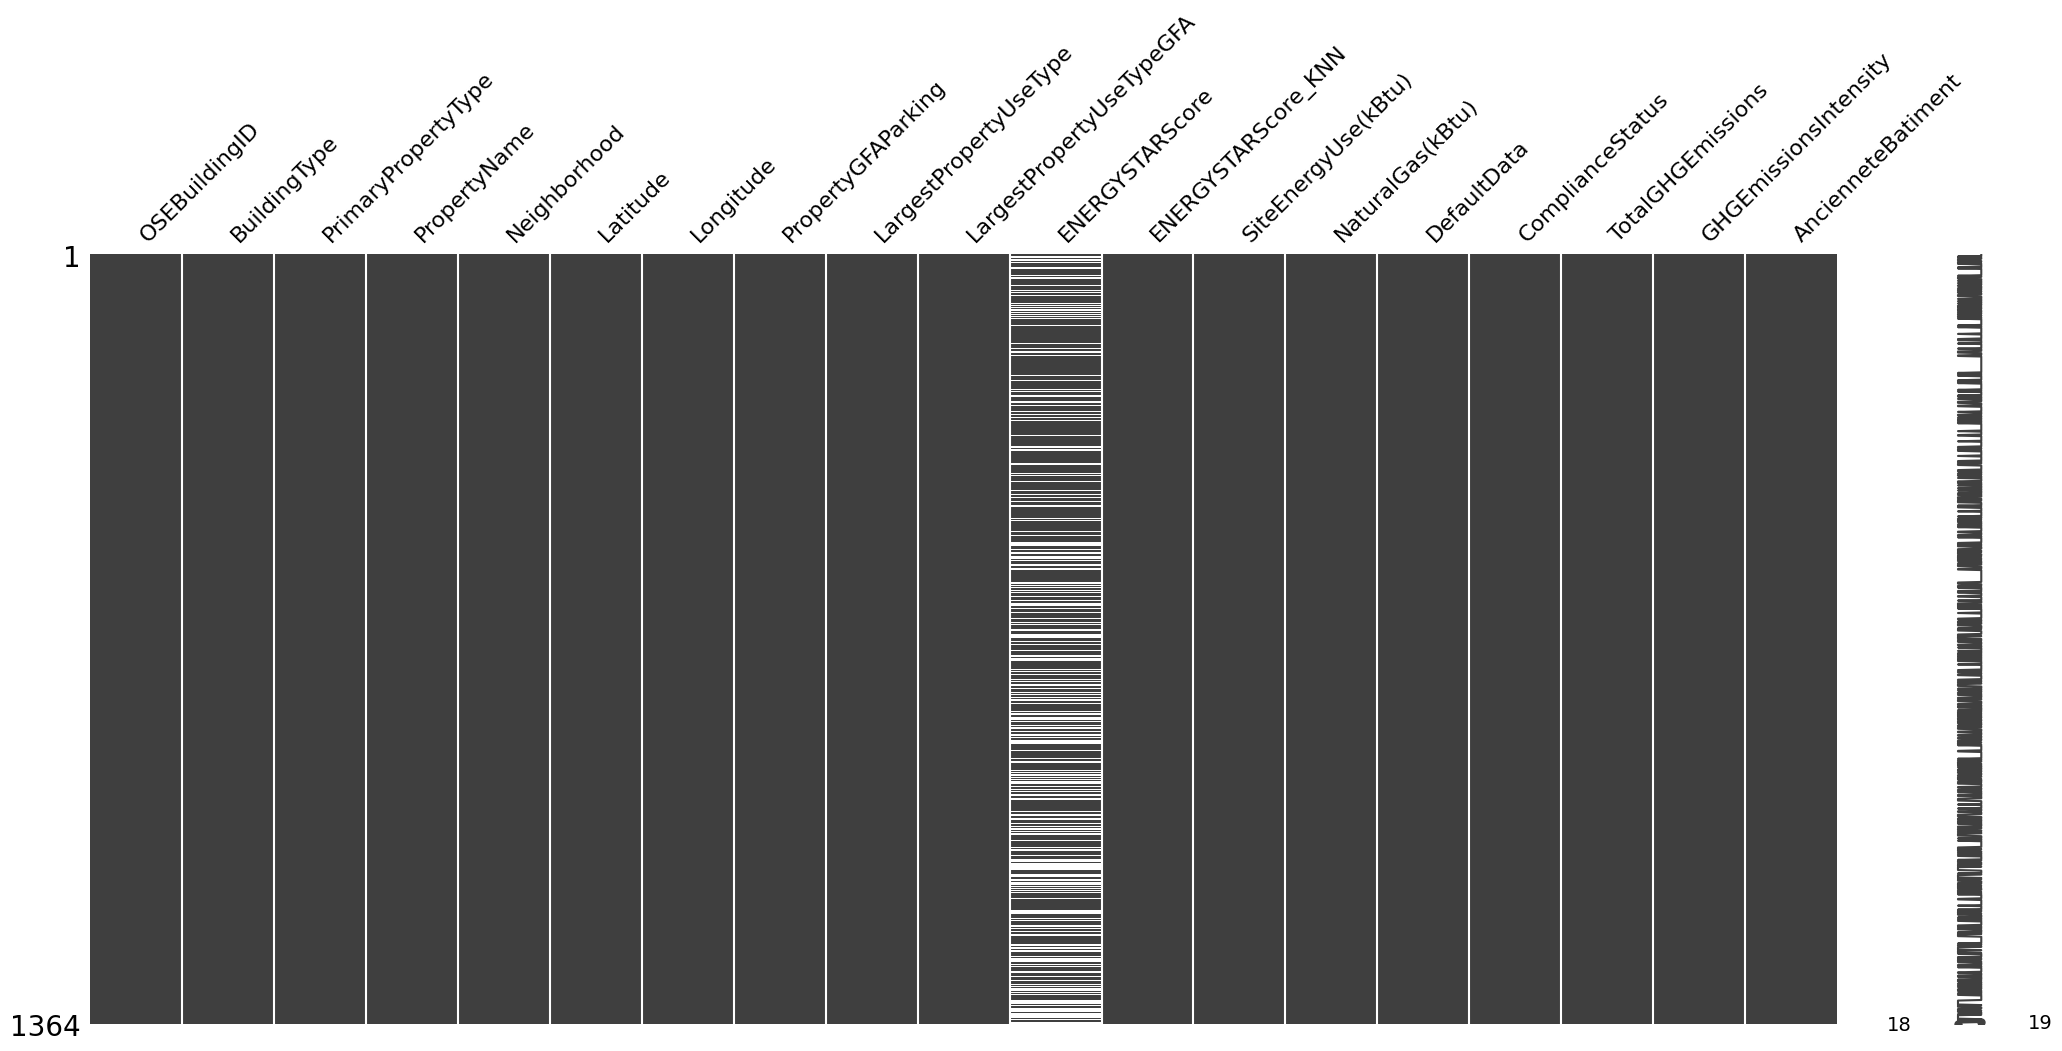

In [120]:
# Tableau et matrice des valeurs manquantes
valeur_manquante_text_graph(df_acp_clean_outlier, False, True)

#### ACP avec TotalGHGEmissions

Nous paramétrons les données d'entrée de l'ACP en retirant la feature ENERGYSTARScore qui présente des valeurs manquantes.

In [121]:
# Dataframe des feature quantitatives (sauf "ENERGYSTARScore" avec des NaN)
feat_quanti_list = df_acp_clean_outlier.select_dtypes(include=['int', 'float']).columns
feat_quanti_list = feat_quanti_list.drop("ENERGYSTARScore")

# Dataframe des valeurs quantitatives (et ses noms de features)
df_data_float = df_acp_clean_outlier[feat_quanti_list]

# Dataframe des valeurs quantitatives (et ses noms de features)
X = df_data_float
features = df_data_float.columns

# Dimension X
display(X.shape)

(1364, 11)

Nous vérifions que nous sommes bien sur les données initiales (pas sur celles après la transformation logarithmique). 

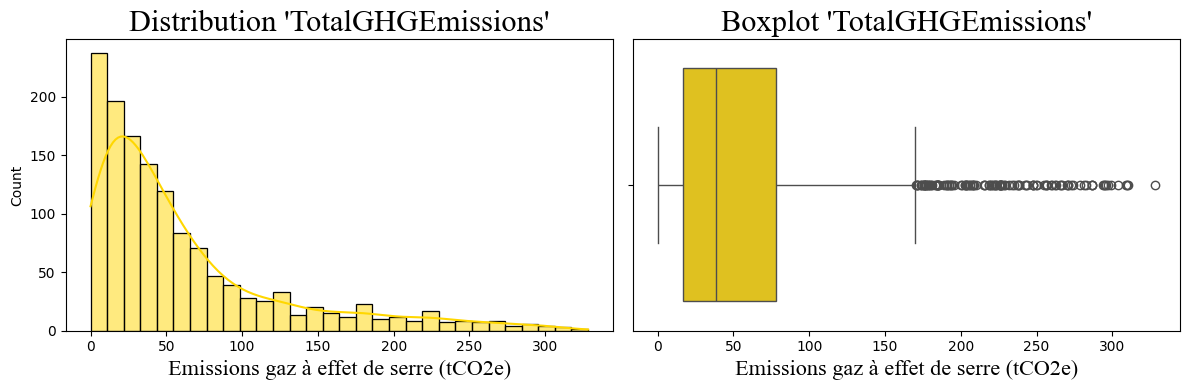

In [122]:
# Sans Log
plot_distribution(df_acp_clean_outlier, "TotalGHGEmissions", colors_list[0], unit="Emissions gaz à effet de serre (tCO2e)")

Ce sont bien les données initiales.

Nous effectuons un centrage et une réduction de nos donnés grâce au Scaler de la librairie "sklearn". 

In [123]:
# On instancie notre scaler
scaler = StandardScaler()

# Application du scaler sur les données (et transformation en df)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Affichage de la moyenne et ecart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

OSEBuildingID  Latitude  Longitude  PropertyGFAParking  \
mean            0.0      -0.0       -0.0                 0.0   
std             1.0       1.0        1.0                 1.0   

      LargestPropertyUseTypeGFA  ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  \
mean                        0.0                 -0.0                  0.0   
std                         1.0                  1.0                  1.0   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
mean              -0.0               -0.0                    0.0   
std                1.0                1.0                    1.0   

      AncienneteBatiment  
mean                 0.0  
std                  1.0

Les données scalées ont bien été centrées (moyenne = 0) et réduites (ecart-type = 1)

##### Eboulis des valeurs propres

Nous allons étudier le nombre de composante utiles à étudier grâce au critère de Kaiser (100 / nombre de composante) et afficher le pourcentage d'inertie totale associé à chaque composante grâce au diagramme de l'éboulis des valeurs propres.

L'ACP a trouvé 11 composantes qui déterminent 100.0 % du dataframe.

Soit un seuil de Kaiser = 9.09, les composantes principales à conserver sont les composantes 1 à 4.


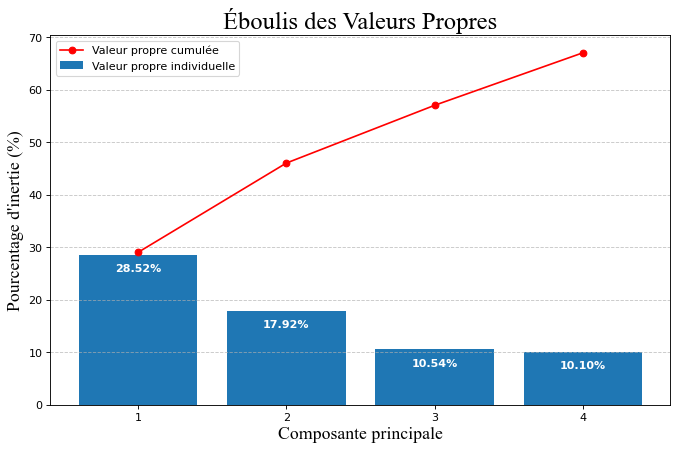

In [124]:
# Instanciation et entrainement de l'ACP
acp = PCA()
acp.fit(X_scaled)

# Fonction qui crée l'éboulis des valeur propres à partir du critère de Kaiser
composante_sup_kaiser_list, x_list = eboulis_valeurs_propres(acp, features)

Nous remarquons que seuls les 4 premières composantes principales respectent le critère de Kaiser. Elles représentent plus de 65% de l'inertie totale. 

##### Heatmap des composantes principales

Nous allons calculer les coefficients assiociés à chaque features pour chacune des composantes principales. 

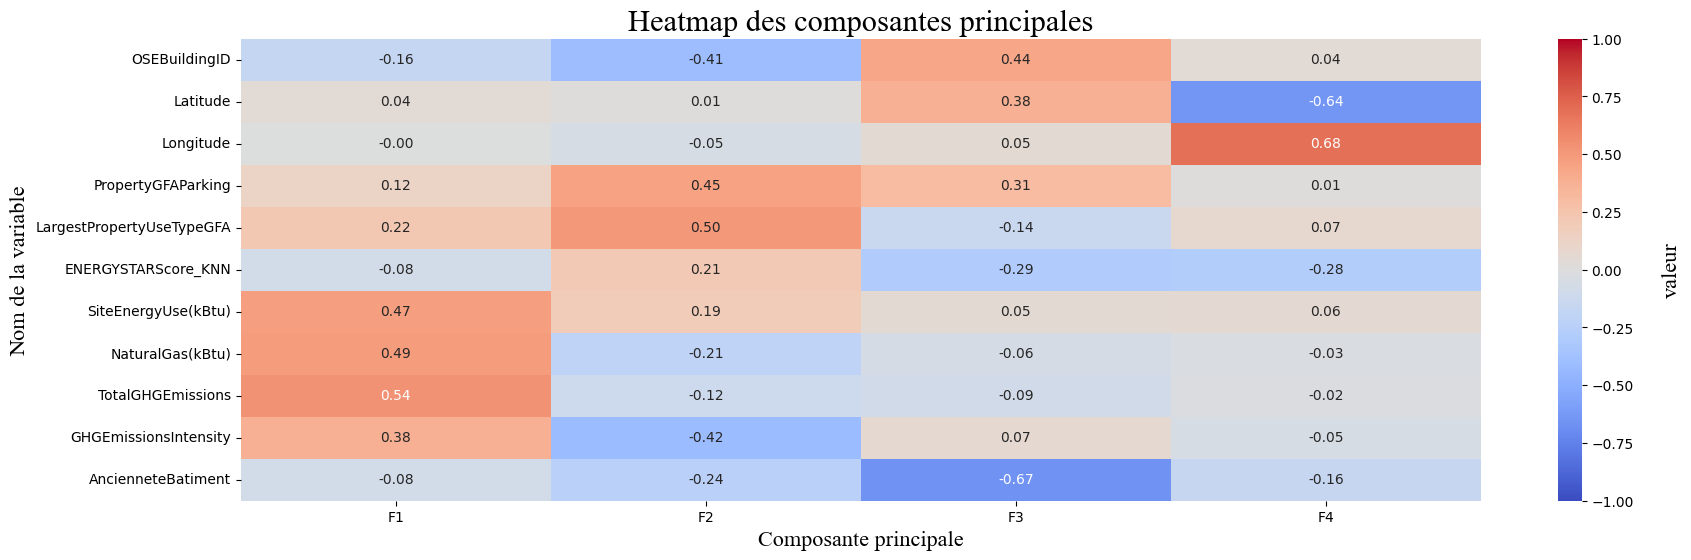

In [125]:
# Nombre de composante principales retenus (suite à Kaiser)
nb_composante_retenues = composante_sup_kaiser_list[-1]

# Instanciation et entrainement ACP sur les composantes principales retenues
acp_retenue = PCA(n_components=nb_composante_retenues)
acp_retenue.fit(X_scaled)

# Séparation des composantes principales retenues (attribution nom de ligne/col)
pcs = pd.DataFrame(acp_retenue.components_)
pcs.columns = features
pcs.index = pd.Index([f"F{i}" for i in x_list])

# Heatmap des composantes principales retenues
fig, ax = plt.subplots(figsize=(20, 6))
heatmap = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

# Ajout titre et label de la color bar
plt.title('Heatmap des composantes principales', fontdict=font_title)
plt.xlabel("Composante principale", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
cbar = ax.collections[0].colorbar
cbar.set_label('valeur', labelpad=20, fontdict=font_axe)
plt.show()

#### Plan factoriel et Cercle de corrélation

Une autre méthode d'affichage des composantes principales consiste à afficher leur plan factoriel et leur cercle de corrélation.

On crée d'abord le dataframe avec la projection des données sur les 4 plans factoriels retenus.

In [126]:
X_proj = acp_retenue.transform(X_scaled)

Plan factoriel et cercle de corrélation F1 et F2 

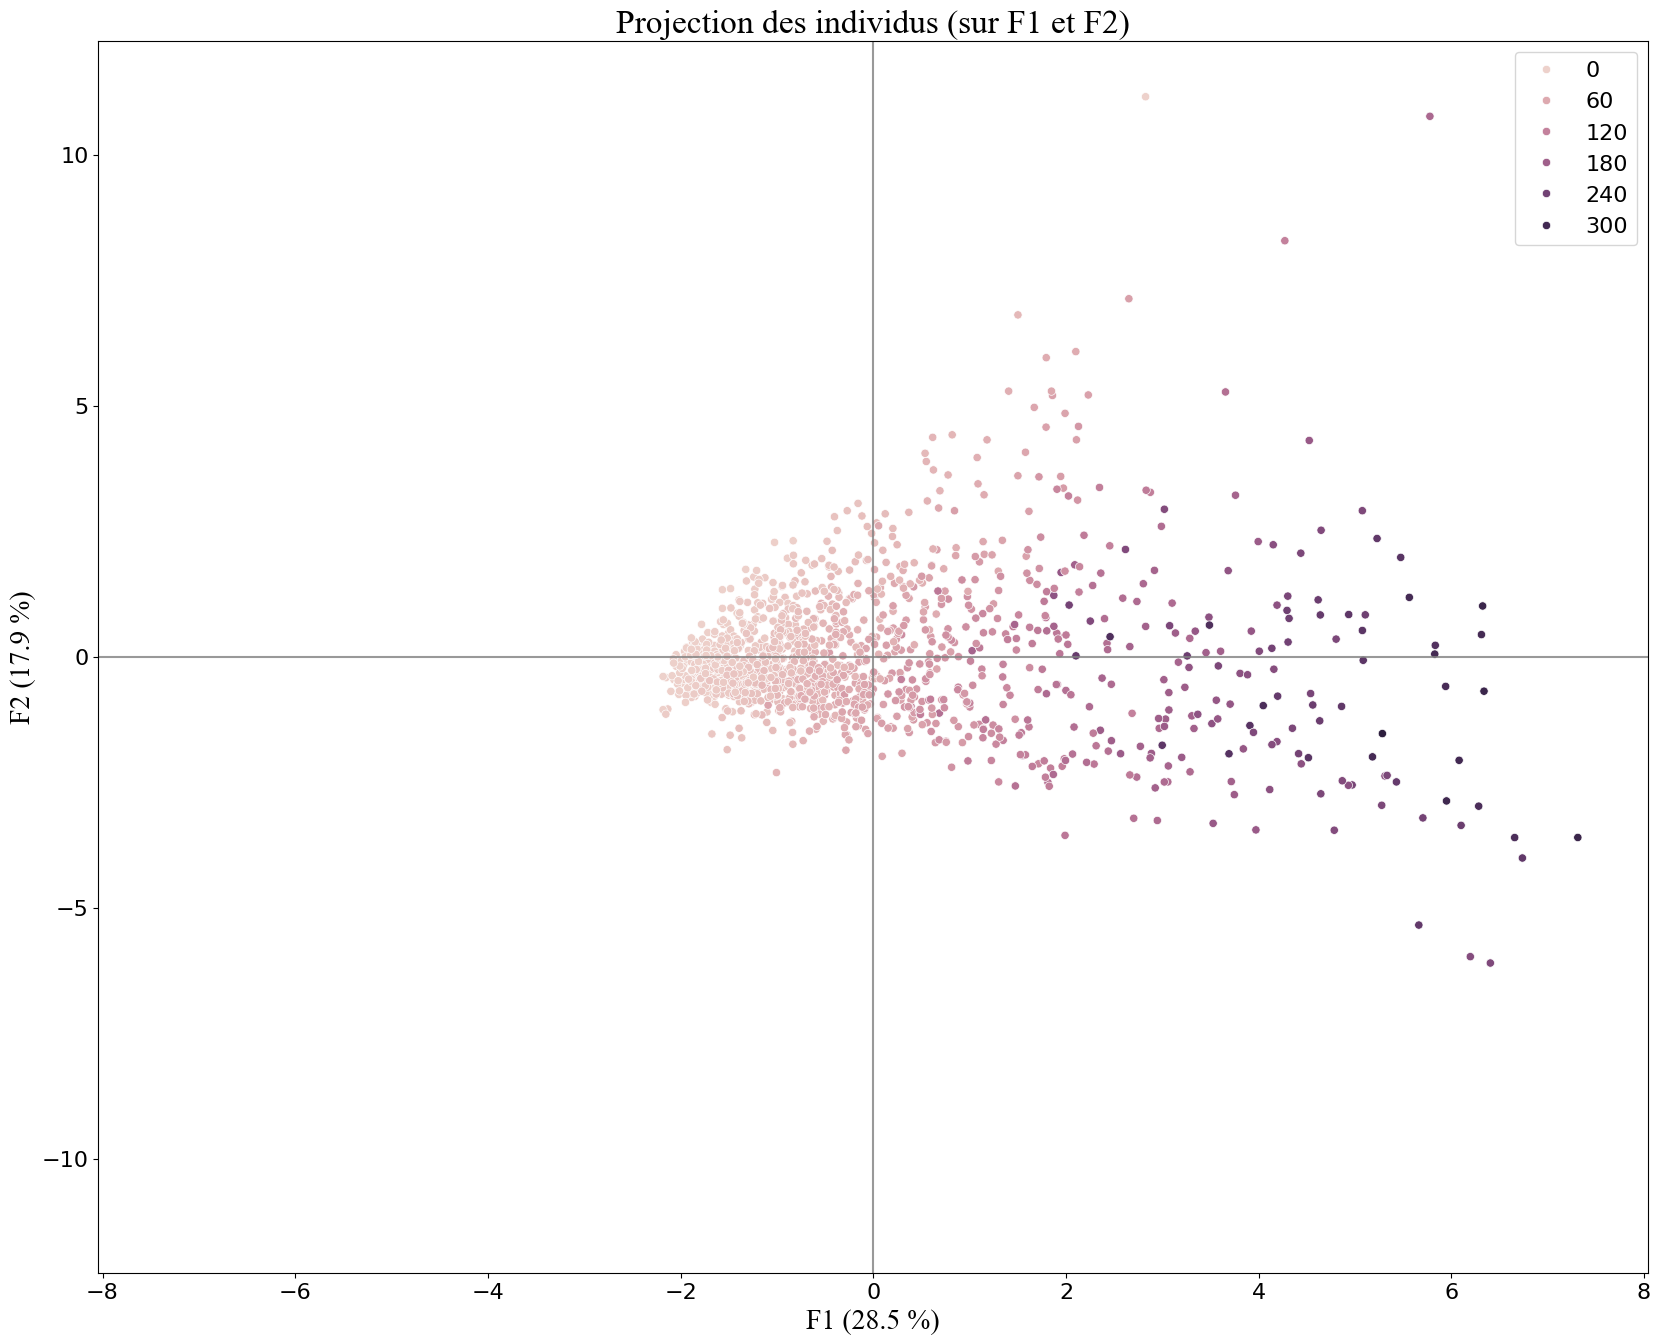

In [127]:
# Plan factoriel composante 1 et 2
x_y = [0, 1]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_acp_clean_outlier['TotalGHGEmissions'], marker="o")

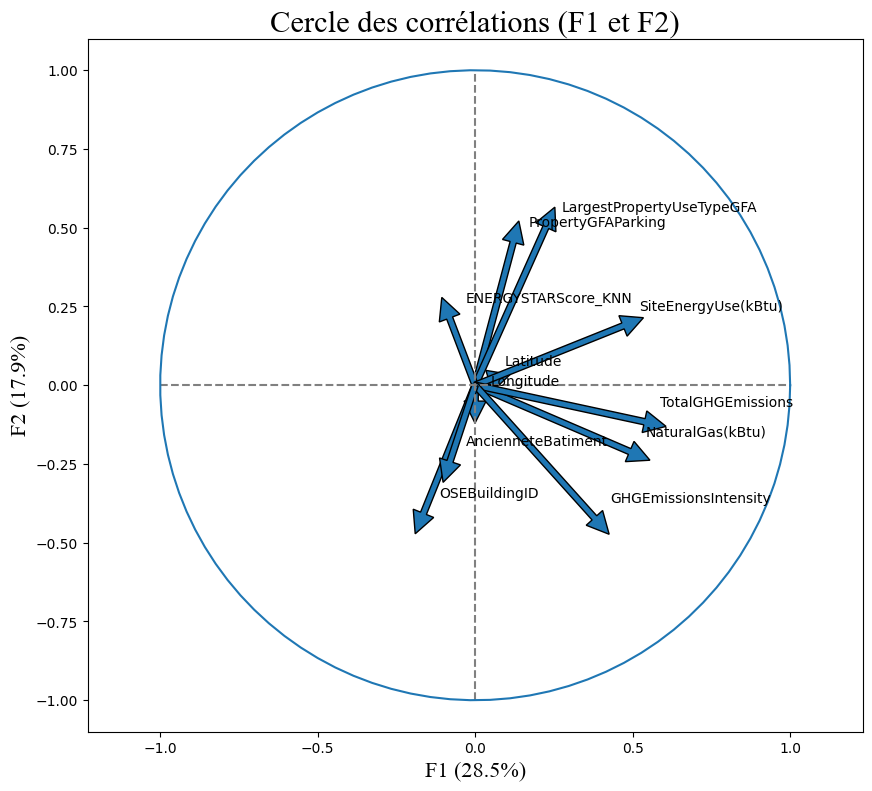

In [128]:
# Cercle des corrélations des composantes 1 et 2
cercle_correlation(acp_retenue, (0, 1), features)

Nous remarquons que la 1ère composante principale (F1) semble corrélée à la quantité d'énergie et de gaz naturel annuelle consommée et à la quantité d'émissions de gaz à effet de serre. 

**F1 semble corrélé à l'impact environnemental négatif du bâtiment**.
<br><br>

La 2ème composante principale (F2) semble corrélée à la surface des parkings du bâtiment et celle dédiée à l'usage principal du bâtiment. Elle est aussi corrélée négativement à l'intensité d'émission de gaz à effet de serre (ratio émission / surface) et au numéro d'identification.

**F2 semble corrélé à la taille du bâtiment. Manifestement, il y aurait davantage de grands bâtiments parmi les premiers à être analysés par les agents municipaux**.
<br><br>

La 3ème composante principale (F3) semble corrélée au numéro d'identification et à la latitude du bâtiment. Elle est aussi corrélée négativement à l'ancienneté du bâtiment.

**F3 semble corrélé à la récence du bâtiment. Manifestement, il y aurait davantage de bâtiment récents dans les quartiers au Nord de la ville, qui ont été parmi les derniers à être analysés par les agents municipaux**.
<br><br>

La 4ème composante principale (F4) semble corrélée à la longitude du bâtiment. Elle est aussi corrélée négativement à la latitude du batiment.

**F4 semble corrélé à la localisation du bâtiment vers la pointe Sud-Est de la ville**.
<br><br>

#### ACP sans TotalGHGEmissions

Nous réalisons à  nouveau une ACP mais ce coup-ci sans la feature "TotalGHGEmissions" pour voir si les résultats sont différents.

Nous paramétrons les données d'entrée de l'ACP.

In [129]:
# Dataframe des feature quantitatives SAUF "TotalGHGEmissions" et "ENERGYSTARScore"
feat_quanti_list = df_acp_clean_outlier.select_dtypes(include=['int', 'float']).columns.drop(["TotalGHGEmissions", "ENERGYSTARScore"])

df_data_float = df_acp_clean_outlier[feat_quanti_list]

# Dataframe des valeurs quantitatives (et ses noms de colonne)
X = df_data_float
features = df_data_float.columns

display(X.shape)

(1364, 10)

Nous vérifions que nous sommes bien sur les données initiales (pas après la transformation logarithmique). 

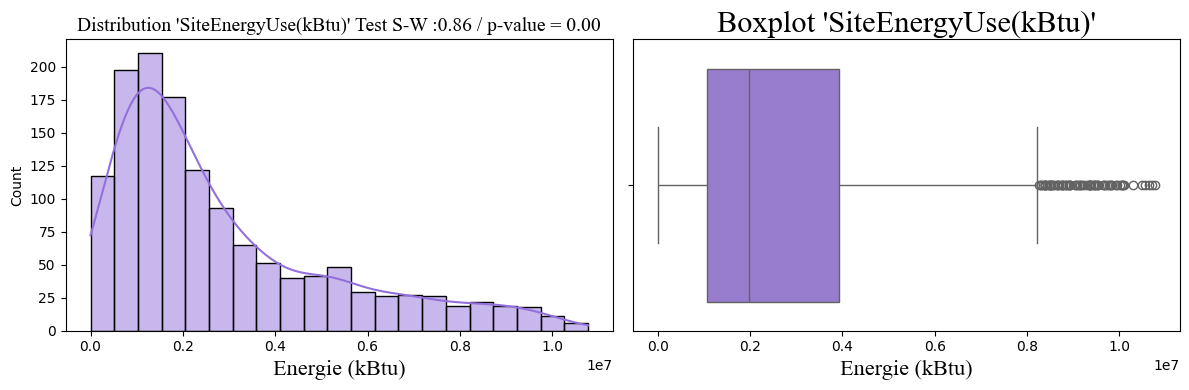

In [130]:
# Sans Log
plot_distribution(df_acp_clean_outlier, "SiteEnergyUse(kBtu)", colors_list[1], shapiro_wilk=True, unit="Energie (kBtu)")

Ce sont bien les données initiales.

Nous effectuons un centrage et une réduction de nos donnés grâce au Scaler de la librairie "sklearn". 

In [131]:
# On instancie notre scaler
scaler = StandardScaler()

# Application du scaler sur les données (et transformation en df)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Affichage de la moyenne et ecart-type
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

OSEBuildingID  Latitude  Longitude  PropertyGFAParking  \
mean            0.0      -0.0       -0.0                 0.0   
std             1.0       1.0        1.0                 1.0   

      LargestPropertyUseTypeGFA  ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  \
mean                        0.0                 -0.0                  0.0   
std                         1.0                  1.0                  1.0   

      NaturalGas(kBtu)  GHGEmissionsIntensity  AncienneteBatiment  
mean              -0.0                    0.0                 0.0  
std                1.0                    1.0                 1.0

Les données scalées ont bien été centrées (moyenne = 0) et réduites (ecart-type = 1)

##### Eboulis des valeurs propres

Nous allons étudier le nombre de composante utiles à étudier grâce au critère de Kaiser (100 / nombre de composante) et afficher le pourcentage d'inertie totale associé à chaque composante grâce au diagramme de l'éboulis des valeurs propres.

L'ACP a trouvé 10 composantes qui déterminent 100.0 % du dataframe.

Soit un seuil de Kaiser = 10.0, les composantes principales à conserver sont les composantes 1 à 4.


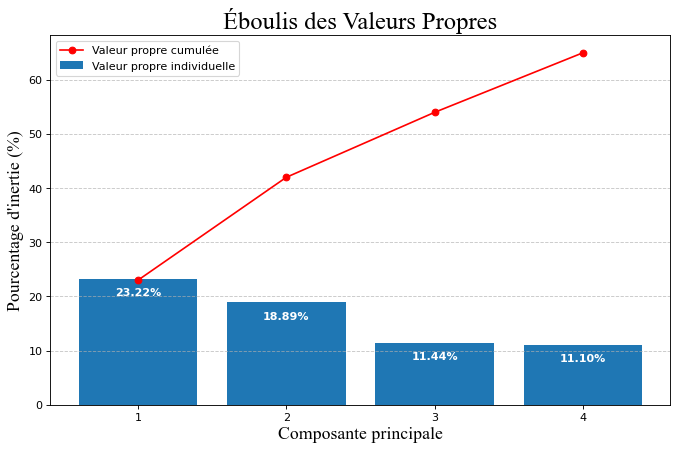

In [132]:
# Instanciation et entrainement de l'ACP
acp = PCA()
acp.fit(X_scaled)

# Fonction qui crée l'éboulis des valeur propres à partir du critère de Kaiser
composante_sup_kaiser_list, x_list = eboulis_valeurs_propres(acp, features)

Nous remarquons que seuls les 4 premières composantes principales respectent le critère de Kaiser. Elles représentent plus de 65% de l'inertie totale. 

##### Heatmap des composantes principales

Nous allons calculer les coefficents assiociés à chaque variable pour chacune des composantes principales. 

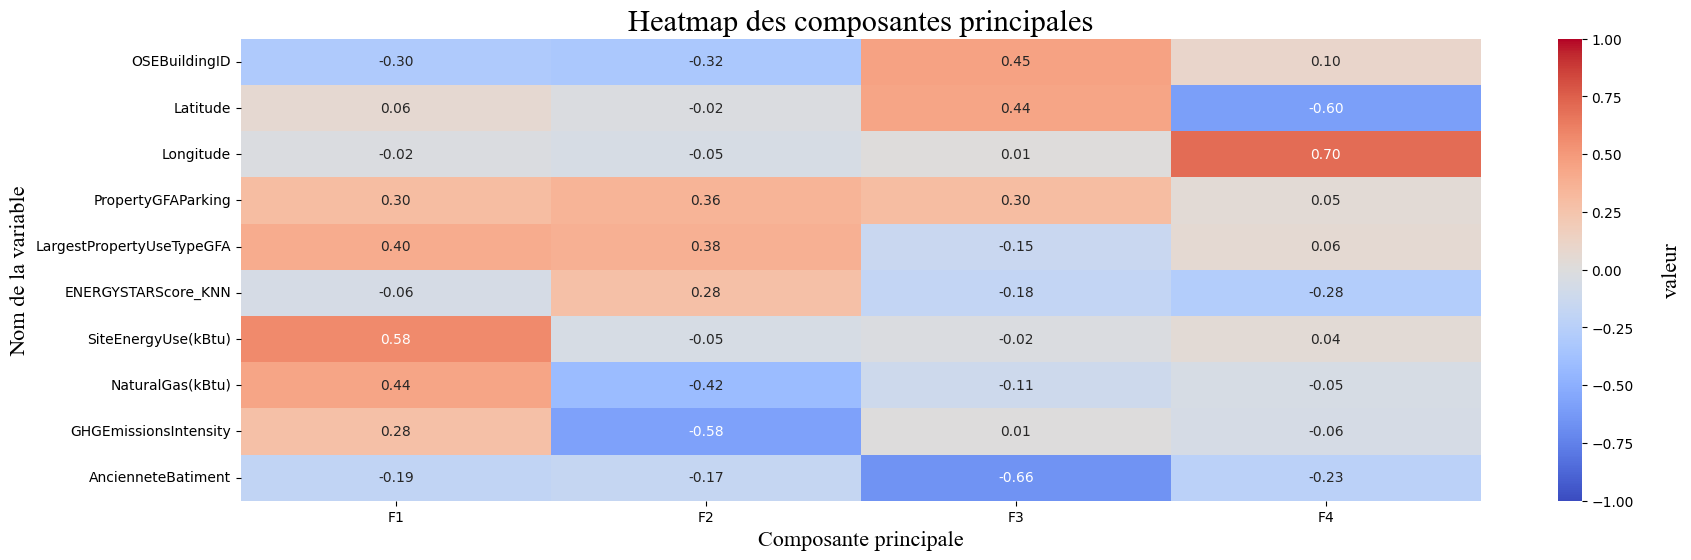

In [133]:
# Nombre de composante principales retenus (suite à Kaiser)
nb_composante_retenues = composante_sup_kaiser_list[-1]

# Instanciation et entrainement ACP sur les composantes principales retenues
acp_retenue = PCA(n_components=nb_composante_retenues)
acp_retenue.fit(X_scaled)

# Séparation des composantes principales retenues (attribution nom de ligne/col)
pcs = pd.DataFrame(acp_retenue.components_)
pcs.columns = features
pcs.index = pd.Index([f"F{i}" for i in x_list])

# Heatmap des composantes principales retenues
fig, ax = plt.subplots(figsize=(20, 6))
heatmap = sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

# Ajout titre et label de la color bar
plt.title('Heatmap des composantes principales', fontdict=font_title)
plt.xlabel("Composante principale", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
cbar = ax.collections[0].colorbar
cbar.set_label('valeur', labelpad=20, fontdict=font_axe)
plt.show()

#### Plan factoriel et Cercle de corrélation

Une autre méthode d'affichage des composantes principales consiste à afficher leur plan factoriel et leur cercle de corrélation.

On crée d'abord le dataframe avec la projection des données sur les 4 plans factoriels retenus.

In [134]:
X_proj = acp_retenue.transform(X_scaled)

Plan factoriel et cercle de corrélation F1 et F2

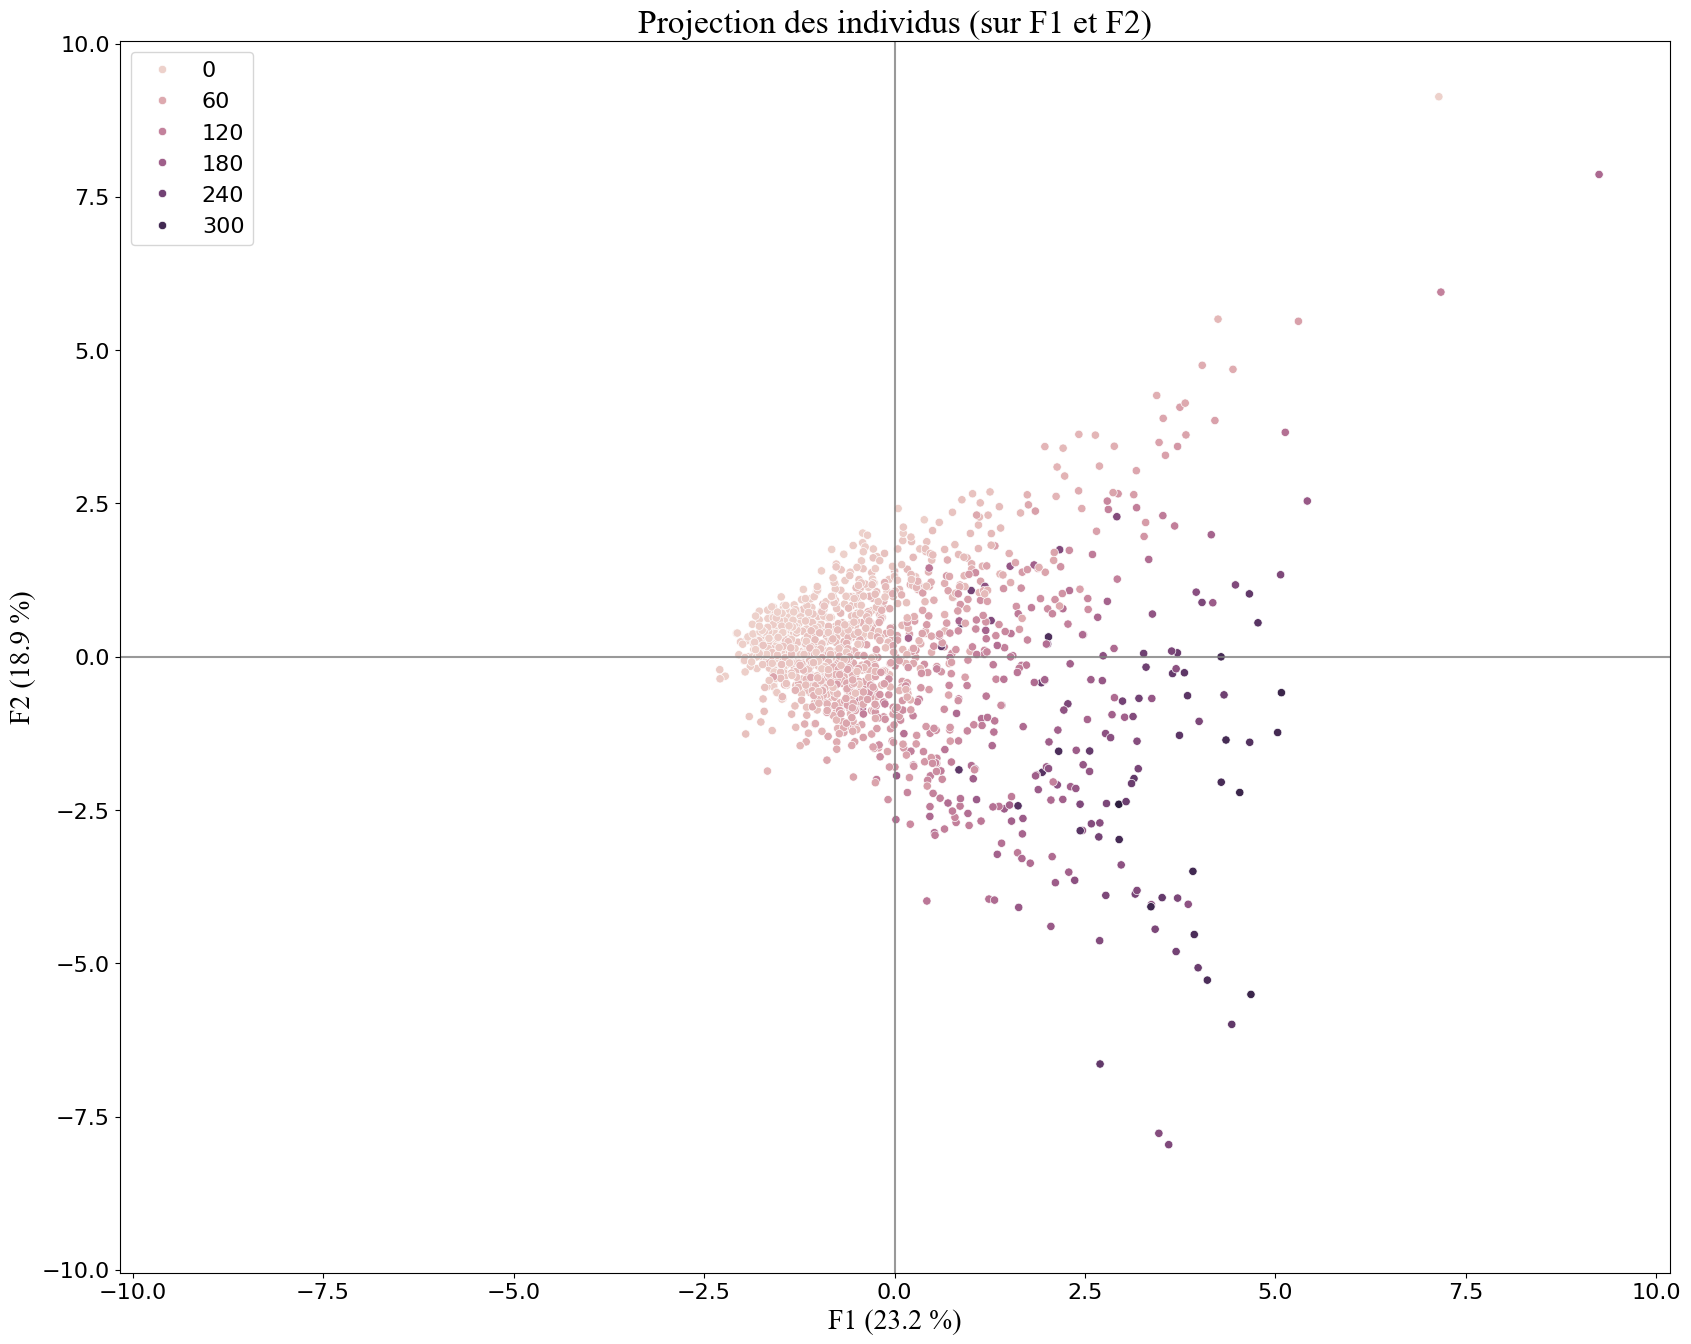

In [135]:
# Plan factoriel composante 1 et 2
x_y = [0, 1]
plan_factoriel(X_proj, x_y, acp_retenue, figsize=(20,16), clusters=df_acp_clean_outlier['TotalGHGEmissions'], marker="o")

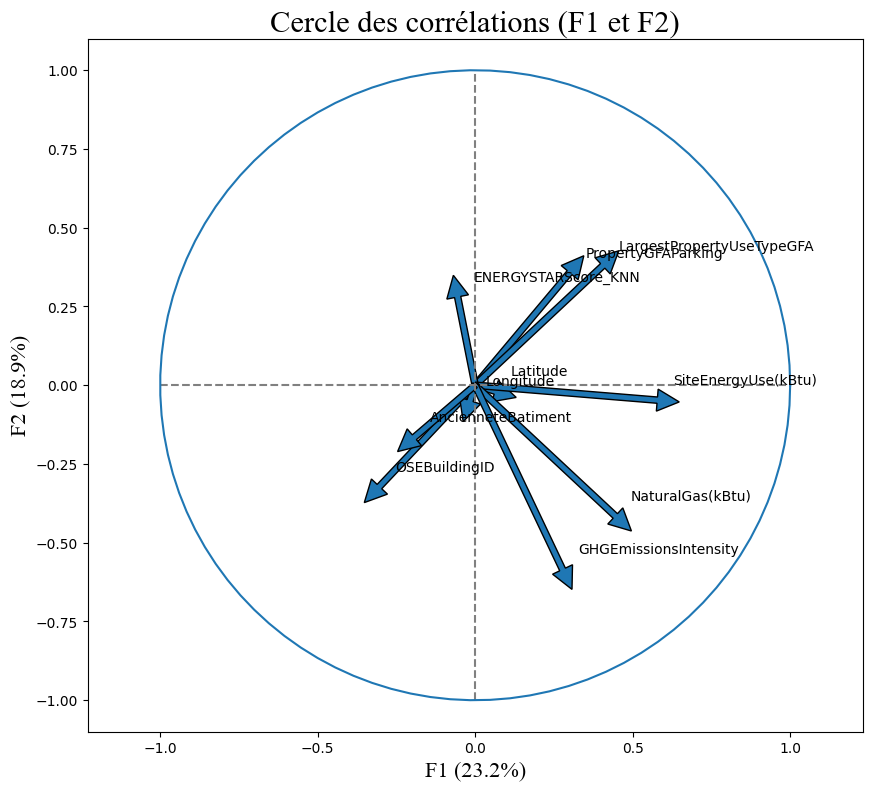

In [136]:
# Cercle des corrélations des composantes 1 et 2
cercle_correlation(acp_retenue, (0, 1), features)

Nous remarquons que la 1ère composante principale (F1) semble corrélée à la quantité d'énergie et de gaz naturel annuelle consommée et la surface du bâtiment. 

**F1 semble corrélé à l'impact environnemental négatif du bâtiment**.
<br><br>

La 2ème composante principale (F2) semble corrélée à la surface des parkings du bâtiment et celle dédiée à l'usage principal du bâtiment. Elle est aussi corrélée négativement à l'intensité d'émission de gaz à effet de serre (ratio émission / surface) et à la quantité de gaz naturel annuelle consommée.

**F2 semble corrélé à la taille du bâtiment. Manifestement, plus un bâtiment est grand et plus sa proportion d'utilisation du gaz naturel comme source d'énergie se réduit**.
<br><br>

La 3ème composante principale (F3) semble corrélée au numéro d'identification et à la latitude du bâtiment. Elle est aussi corrélée négativement à l'ancienneté du bâtiment.

**F3 semble corrélé à la récence du bâtiment. Manifestement, il y aurait davantage de bâtiment récents dans les quartiers au Nord de la ville, qui ont été parmi les derniers à être analysés par les agents municipaux**.
<br><br>

La 4ème composante principale (F4) semble corrélée à la longitude du bâtiment. Elle est aussi corrélée négativement à la latitude du bâtiment et à l'ancienneté du bâtiment.

**F4 semble corrélé à la localisation du bâtiment vers la pointe Sud-Est de la ville où il y a également des bâtiments récents**.
<br><br>

# <span style='background:blue'>Etape 4 : Exportation du dataset nettoyé</span>
___

Nous allons sauvegarder le dataset nettoyé (celui avec les transformation logarithmiques) pour l'utiliser dans nos modèles de machine learning.

In [137]:
# Aperçu dataframe nettoyé (données transformées avec le log)
affiche_aperçu_df(df_data_clean_outlier, "df_data_clean_outlier", "des outliers", 3)

Voici l'aspect de 'df_data_clean_outlier' après nettoyage des outliers


OSEBuildingID    BuildingType PrimaryPropertyType             PropertyName  \
0              1  NonResidential               Hotel     Mayflower park hotel   
1              2  NonResidential               Hotel          Paramount Hotel   
2              3  NonResidential               Hotel  5673-The Westin Seattle   

  Neighborhood  Latitude  Longitude  PropertyGFAParking  \
0     DOWNTOWN  47.61220 -122.33799                   0   
1     DOWNTOWN  47.61317 -122.33393               15064   
2     DOWNTOWN  47.61393 -122.33810              196718   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
0                  Hotel                    88434.0             60.0   
1                  Hotel                    83880.0             61.0   
2                  Hotel                   756493.0             43.0   

   ENERGYSTARScore_KNN  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  DefaultData  \
0                 60.0             15.79325         1276453.0        False   
1                 61.0             15.94230         5145082.0        False   
2                 43.0             18.10030         1493800.0        False   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  \
0        Compliant            5.52537                   2.83   
1        Compliant            5.69326                   2.86   
2        Compliant            7.64505                   2.19   

   AncienneteBatiment  
0                  89  
1                  20  
2                  47

1611 ligne(s) x 19 colonne(s)



In [212]:
# Chemin du dossier et nom du fichier de l'export nettoyé
output_directory = "data/cleaned"
nomFichier_export = "2016_Building_Energy_Benchmarking_cleaned.csv"

# Vérification de l'existence du dossier
os.makedirs(output_directory, exist_ok=True)

# Chemin complet du fichier export
output_file = os.path.join(output_directory, nomFichier_export)

# export df nettoyé en CSV (tabulation en séparateur)
df_data_clean_outlier.set_index("OSEBuildingID").to_csv(output_file, sep='\t', encoding='utf-8', index=False)

# <span style='background:blue'>Conclusion</span>

Les données de ce dataset ont été nettoyées de ses features inutiles ou redondantes, des batiments non-tile pour nos analyses et des outliers. Les valeurs manquantes ont été imputées par des algorithmes de machine learning de type KNN.

L'analyse exploratoire nous apprend que plus des 3/4 des batiments sont des bâtiments non résidentiels (notamment des bureaux et des entrepôts non-réfrigérés).

Nous avons identifié les 2 features cibles, à savoir :
- Emission de CO2 : 'TotalGHGEmissions' exprimé en tonnes métriques d'équivalent de dioxyde de carbone (tCO2e)
- Consommation totale d’énergie : 'SiteEnergyUse(kBtu)' exprimé en kBtu (unité thermique britannique)
Ces 2 features cibles présentent une corrélation linéaire forte entre elles (R = 0,88). 

Une ACP nous a permis de déterminer les 4 composantes principales qui expliquent plus de 65% de l'inertie totale. Ses résultats sont similaires si nous supprimons la feature cible "TotalGHGEmissions".

**Le dataset nettoyé est prêt à être utilisé pour la réalisation de modèles de machine learning dans les 2 autres notebooks du projet.**

In [138]:
# Calculer et afficher la durée totale
total_time = time.time() - start_time

# Convertir en minutes et secondes
minutes, seconds = divmod(total_time, 60)

# Afficher la durée totale
print("Durée totale pour faire tourner le notebook : {0} minute(s) {1} seconde(s)".format(int(minutes), int(seconds)))

Durée totale pour faire tourner le notebook : 3 minute(s) 31 seconde(s)
